In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths and other changable arguments

In [2]:
BASE_DIR = '/DIR'
DATA_DIR = os.path.join(BASE_DIR, 'results_save_new')
NEW_DATA_DIR = os.path.join(BASE_DIR, 'Brain-to-Brain/Analyzed_Results')
SAVE_FIGS_DIR = os.path.join(BASE_DIR, 'figs_for_paper')
SAVE_FIGS = False
WITH_LEGEND_AND_AXES = True
SHAREY = False

In [3]:
class NameAndColor:
    dct = {}
    def __init__(self, name, color):
        self.name = name
        self.color = f"C{color}" if isinstance(color, int) else color
        self.c = self.color
        self.c_num = color if isinstance(color, int) else None
        NameAndColor.dct[self.name] = self.c
        
from enum import Enum
class EncoderKinds(Enum):
    Baseline = NameAndColor('Baseline', 'grey')
    TeacherImageNet = NameAndColor("Teacher ImageNet", 'purple')
    TeacherNSD = NameAndColor("Teacher NSD", 1)
    TeacherNSDLessExamples = NameAndColor("Teacher NSD more examples", 'C3')

class TransfKinds(Enum):
    S_Small = NameAndColor('s (200)', 'C0')
    S = NameAndColor('Baseline', 'g')
    S_NS = NameAndColor('s+ns', 4)
    S_NS_E = NameAndColor('s+ns+e', 2)
    S_NS_E_Small = NameAndColor('s+ns+e little', 7)
    NS_E = NameAndColor('ns+e', 3)
    NS_E_Small = NameAndColor('ns+e little', 8)
    TeacherImageNet = NameAndColor('Teacher ImageNet', 'purple')
    TeacherNSD = NameAndColor('Teacher NSD', 1)
    EncoderBaseline = NameAndColor("Encoder without teacher", 'gray')
    Anatomical = NameAndColor('Anatomical', 'c')

# Utils

In [4]:
def np_load(fn, base_dir=DATA_DIR):
    if not fn.endswith("npy") or fn.endswith("npz"):
        fn += ".npy"
    fn = os.path.join(base_dir, fn)
    return np.load(fn)

def csv_load(fn, base_dir=DATA_DIR):
    fn = os.path.join(base_dir, fn)
    return pd.read_csv(fn)

In [5]:
def cohens_d(arr1, arr2, axis=0):
    return (arr1-arr2).mean(axis=axis) / (arr1 - arr2).std(axis=axis, ddof=1)

In [6]:
def ttest_rel(arr1, arr2):
    import scipy
    ttest = scipy.stats.ttest_rel(arr1, arr2)
    print(f"Res: group 1 (M={arr1.mean(axis=0)}, SD={arr1.std(axis=0, ddof=1)}), group2 (M={arr2.mean(axis=0)}, SD={arr2.std(ddof=1, axis=0)}), N={len(arr1)}, t={ttest.statistic}, p={ttest.pvalue}, d={cohens_d(arr1, arr2, axis=0)}")
    return ttest

In [7]:
def permutation_test(arr1, arr2, iterations=100000):
    def statistic(x, y, axis):
        return np.mean(x-y, axis=axis)
    from scipy.stats import permutation_test as perm_test
    ptest = perm_test((arr1, arr2), statistic, vectorized=True,
                       n_resamples=iterations, alternative='greater', permutation_type="samples")
    print(f"Res: group 1 (M={arr1.mean(axis=0)}, SD={arr1.std(axis=0, ddof=1)}), group2 (M={arr2.mean(axis=0)}, SD={arr2.std(ddof=1, axis=0)}), N={len(arr1)}, t_perm={ptest.statistic}, p={ptest.pvalue}, d={cohens_d(arr1, arr2, axis=0)}")
    return ptest

In [8]:
TESTS = (permutation_test, )

In [9]:
def get_total_min_and_max(*args):
    return min([arg.min() for arg in args]), max([arg.max() for arg in args])

In [10]:
import pandas as pd

def stack_dfs(dfs):
    def f(n):
        return list(np.stack([np.array(df[n]) for df in dfs], axis=0).T)
    return pd.DataFrame({"shared": dfs[0].shared, "non_shared": dfs[0].non_shared,
                            "external": dfs[0].external, "teacher": dfs[0].teacher,
                            'test_corr': f('test_correlation'),
                            "perc_d": f('ref_d_correlation_perc'),
                            'd': f('ref_d_correlation')})

def get_csvs(graph_number=1, exclude_sub=None, stack=True, fsaverage=False):
    loads = [(eval(fn[len('fsaverage_'*fsaverage + 'graph0_')]), eval(fn[len('fsaverage_'*fsaverage+'graph0_0_to_')]), csv_load(fn)) 
          for fn in sorted(os.listdir(DATA_DIR)) if fn.endswith("csv") and fn.startswith('fsaverage_'*fsaverage+f"graph{graph_number}_")]
    s1s = np.array([l[0] for l in loads if exclude_sub is None or exclude_sub not in l[:2]])
    s2s = np.array([l[1] for l in loads if exclude_sub is None or exclude_sub not in l[:2]])
    dfs = [l[2] for l in loads if exclude_sub is None or exclude_sub not in l[:2]]
    if stack:
        dfs = stack_dfs(dfs)
    if 'perc_d' in dfs.columns:
        dfs.perc_d *= 100
    return s1s, s2s, dfs

In [11]:
def get_df_from_dfs(dfs, field, mask, i):
    return np.array([arr[i] for _, arr in dfs[field][mask].items()])

# Plot utils

In [12]:
X_LABEL_EXPS = '# of fMRI examples'
X_LABEL_NS_EXPS = '# of non-shared fMRI examples'

BIGGER_TICKSIZE = 13.5

CORRELATION = "correlation"
MEAN_CORRELATION = "Mean correlation"
RETRIEVAL_ACCURACY = "Retrieval accuracy"

YLABEL_PERCENT = lambda percents: "% "*bool(percents) + "improvement of " + MEAN_CORRELATION

In [13]:
def save_as_pdf(name, path=SAVE_FIGS_DIR):
    if SAVE_FIGS:
        fn = os.path.join(path, name + ".pdf"*(not name.endswith('.pdf')))
        plt.savefig(fn, format="pdf", bbox_inches="tight")
        print(f"saved {fn}")

In [14]:
FIGURE_SIZE = (6, 5)

def get_figsize(columns=1, rows=1):
    return tuple([(s+0.5)*n - 0.5 for s, n in zip(FIGURE_SIZE, (columns,rows))])

In [15]:
def simpleaxis(ax, remove_left=False):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if remove_left:
        ax.spines['left'].set_visible(False)
    else:
        ax.get_yaxis().tick_left()
    ax.get_xaxis().tick_bottom()

In [16]:
def set_ticks_style(fig, remove_left=False, ticksize=12):
    for ax in fig.axes:
        ax.tick_params(axis='x', labelsize=ticksize)
        ax.tick_params(axis='y', labelsize=ticksize)
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)
        simpleaxis(ax, remove_left=remove_left)

In [17]:
def set_legend(*args, fontsize=10, fig=None, **kwargs):
    if WITH_LEGEND_AND_AXES:
        plt.legend(*args, **kwargs, frameon=False, fontsize=fontsize)

In [18]:
def set_figure(figsize=FIGURE_SIZE, suptitle=None):
    fig = plt.figure(figsize=figsize, facecolor='w')
    if suptitle:
        suptitle = plt.suptitle(suptitle)
        suptitle.set_position([.5, 1.05])
    return fig

In [19]:
def calculate_d(data, reference, percents=False):
    if percents:
        return 100 * (data / reference - 1)
    else:
        return (data - reference)

In [20]:
def plot_with_err(x, y, c="C0", p_thresh=0.95, label='', percents=False, fill_between=False, plot=True, alpha=0.3, 
                  plot_std=True, asterisk_diff=None, diff=True, ylabel=True):
    from scipy.stats import norm, t as t_pack
    t_crit = t_pack.ppf(p_thresh, y.shape[0]-1)
    stderr = y.std(axis=0, ddof=1)/np.sqrt(y.shape[0])
    err = t_crit*stderr
    err_plot = stderr if plot_std else err
    if isinstance(c, str):
        plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o', 
                     label=label, markersize=7, capsize=10, fmt='.')
    else:
        for i in range(len(c)):
            plt.errorbar(x[i], y.mean(axis=0)[i], err_plot[i], alpha=alpha, color=c[i], marker='o', 
                         label=label, markersize=7, capsize=10, fmt='.')
    cur_mean = y.mean(axis=0)
    mask = (cur_mean - err) > 0
    asterisk_diff = y.mean(axis=0).max() / 10 if asterisk_diff is None else asterisk_diff
    if fill_between:
        plt.fill_between(x, y.mean(axis=0) - err_plot, y.mean(axis=0) + err_plot, alpha=0.1, color=c)
    if plot:
        plt.plot(x, y.mean(axis=0), color=c)
    if ylabel:
        if WITH_LEGEND_AND_AXES:
            plt.ylabel(YLABEL_PERCENT(percents) if diff else MEAN_CORRELATION)
    return asterisk_diff

In [21]:
BAR_WIDTH = 70

def p_to_asteriks(p):
    if p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    return ''

def plot_bar_with_err(arr, kind, loc, width=BAR_WIDTH, label=False):
    if hasattr(kind, "value"):
        kind = kind.value
    plt.bar(loc, arr.mean(), width=width, color=kind.c, alpha=.6, zorder=0, label=kind.name if label else None)
    plt.errorbar(loc, arr.mean(), arr.std(ddof=1)/np.sqrt(len(arr)), c='k', zorder=2, capsize=3, label=None)


def plot_significance(arr1, arr2, loc1, loc2=None, dist=0, vertical=False, dist_from_line=10, y1=None, y2=None, t=False):
    mask = ~(np.isnan(arr1) | np.isnan(arr2))
    arr1 = arr1[mask]
    arr2 = arr2[mask]
    significance_str = p_to_asteriks((ttest_rel if t else permutation_test)(arr1, arr2).pvalue)
    if significance_str:
        if not vertical:
            assert loc2 is not None
            y = arr1.mean() + arr1.std(ddof=1) / np.sqrt(arr1.size) + 0.01 *(1+1.5*dist)
            plt.plot([loc1, loc2], [y]*2,
                     c='k', linestyle=':')
            plt.text((loc1 + loc2)/2, y, significance_str, ha='center')
        else:
            if y1 is None:
                y1 = arr1.mean() 
            if y2 is None:
                y2 = arr2.mean() 
            plt.plot([loc1]*2, [y1 - 0.1*(y1-y2), 
                                y2 + 0.1*(y1-y2)], 
                     c='k', linestyle=':')
            plt.text(loc1 +dist_from_line, (y1 + y2)/2, '\n'.join([a for a in significance_str]), 
                     ha='center', va='center', linespacing=.5)

In [22]:
def load_retrieval_mat(s=700, ns=6400, e=6400, teacher=None, teacher_code=None, encoder_only=False, ver2=False, image_num=None,
                       s1_ds="NSD", s2_ds="NSD", with_encoder=False, anatomical=False, fsaverage=True, repeats=False, snr_w=False, corr_w=False,
                       retrieval_path=os.path.join(BASE_DIR, "keras_transf_models/retrieval_res"), rank=False):
    assert encoder_only or (s1_ds == "NSD" and s2_ds=="NSD") or (s1_ds == "NSD" and s2_ds=="Kn" and not anatomical) or (s1_ds=="Kn" and s2_ds=="Kn")
    name = f"ret_"
    if image_num:
        name += f"n{image_num}_"
        
    if ver2:
        name += "ver2_"
    
    if rank:
        name += 'rank_'
    else:
        name += 'acc_'
        
    if encoder_only:
        name += 'enc_'
        name += s1_ds + f'_s_{s}_ns_{ns}'
    else:
        name += "transf_"
        if s1_ds == "NSD":
            name += 'NSD_'
            if s2_ds == 'Kn':
                name += f"to_Kn_"
            name += f"s{s}_ns{ns}_e{e}" if not anatomical else "anatomical"
            
        elif s1_ds == "Kn":
            if s2_ds == 'Kn':
                name += f"Kn_to_Kn_ns1_{ns}_ns2_{ns}"

    if repeats:
        name += '_repeats'
            
    if teacher_code:
        name += f"_t{tc}"
    if with_encoder:
        name += "_enc"
    if fsaverage and not anatomical:
        name += f"_fsaverage"

    if snr_w:
        name += "_snrw"

    if corr_w:
        name += "_corrw"
    
    if not name:
        raise ValueError()
    
    full_name = os.path.join(retrieval_path, f'{name}.npy')
    print(f"loading {name}")
    if os.path.exists(full_name):
        with open(full_name, 'rb') as f:
            mat = np.load(f)
        return mat
    else:
        print("failed...")
        return None

In [23]:
def df_to_mat(row, s1s, s2s):
    mat = np.full((max(s1s), max(s2s)), np.nan)
    mat[s1s-1, s2s-1] = row.test_corr.item()
    return mat

def find_relevant_row_in_df(df, **params):
    return df[(df.shared == params.get('s', 0)) & (df.non_shared == params.get('ns', 0)) & (df.external == params.get('e', 0))]

In [24]:
def heatmap_individual(mat, is_diff=False, cbar_label="Pearson's r", ranges=None, vmax=None, text_c='k', percentages=False):
    import matplotlib
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, ax = plt.subplots(figsize=np.array(FIGURE_SIZE), facecolor='white')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)


    cmap = matplotlib.cm.seismic if is_diff else matplotlib.cm.Greens
    cmap.set_bad('black',1.)
    # ax = plt.subplot(121)
    abs_max = np.nanmax(np.abs(mat)) * 1.2
    im = ax.imshow(mat, vmin=(-abs_max if is_diff else 0 if ranges else None) if vmax is None else -vmax, vmax=(abs_max if is_diff else 1 if ranges else None) if vmax is None else vmax, cmap=cmap, origin='lower')
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, f"{mat[i, j]:.2f}" if not percentages else f"{int(mat[i, j]*100) if not np.isnan(mat[i,j]) else ''}", 
                    ha='center', va='center', c=text_c)
    from matplotlib.ticker import PercentFormatter
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', 
                        format=PercentFormatter(xmax=1, decimals=0) if percentages else None)    
    
    if WITH_LEGEND_AND_AXES:
        cbar.set_label(cbar_label)
        ax.set_xlabel("target subject")
        ax.set_ylabel("domain subject")
    ax.set_xticks(np.arange(mat.shape[1])[::2], np.arange(mat.shape[1])[::2]+1)
    ax.set_yticks(np.arange(mat.shape[0])[::2], np.arange(mat.shape[0])[::2]+1)
    # set_ticks_style(fig)

def heatmap_individual_diff(params=None, baseline_params=None, corr_df=None, s1s=None, s2s=None, mat1=None, mat2=None, 
                            name1=None, name2=None, mean_axis=None, text_c='k', transpose=False, ret=False, ax=None, **kwargs):

    
    if mat1 is None:
        if corr_df is None:
            assert params is not None
            mat1 = load_retrieval_mat(**params)
        else:
            mat1 = df_to_mat(find_relevant_row_in_df(corr_df, **params), s1s, s2s)
    
    if mat2 is None:
        if baseline_params is not None:
            if corr_df is None:
                mat2 = load_retrieval_mat(**baseline_params)
            else:
                mat2 = df_to_mat(find_relevant_row_in_df(corr_df, **baseline_params), s1s, s2s)
                
#     ptest = permutation_test(mat1, mat2)
    diff = mat1 - mat2 if mat2 is not None else mat1
    if mean_axis is not None:
        diff = diff.mean(axis=mean_axis)
    if transpose:
        diff = diff.T
    heatmap_individual(diff, is_diff=mat2 is not None, ranges=True, 
                       cbar_label=(RETRIEVAL_ACCURACY if ret else "Pearson's r") +(" difference" if mat2 is not None else ""), text_c=text_c, percentages=ret, **kwargs)

    if ax is not None:
        ax.set_title(f"{params if name1 is None else params}" + (f" - {baseline_params if name2 is None else baseline_params}" if baseline_params is not None or name2 is not None else ""))
    save_name = 'retrieval_accurracy_' if corr_df is None else "pearson_r_"
    name1 = '_'.join([f"{key}_{val}" for key, val in params.items()]) if name1 is None else name1
    name2 = ('_' + '_'.join([f"{key}_{val}" for key, val in baseline_params.items()]) if mat2 is not None else "") if name2 is None else ('_' + name2)
    if name2:
        save_name += "diff_" + name1 + name2
    else:
        save_name += name1
    save_as_pdf(name=save_name)

# Figure 4 and transformations statistical tests

In [25]:
exp_arr_Kn = np.array([300,600,900,1200])
subjects_k = np.arange(5) + 1
subject_4k = 4
NSD_transf_anatomical_corr_calc_mat = np_load('transf_anatomical_NSD_fsaverage_corr_calc_mat.npy')

In [26]:
s1s4_fsaverage, s2s4_fsaverage, df4_fsaverage = get_csvs(4, fsaverage=True)
s1s6_fsaverage, s2s6_fsaverage, df6_fsaverage = get_csvs(6, fsaverage=True)

### Figure 4a

In [27]:
def plot_how_the_amount_non_shared_examples_affect_transformations(df, percents=False,
                                                                   calc_delta = True,
                                                                   save_name = '', anatomical=None, baseline_dct=None,
                                                                   with_ns=True, with_only_ns=True, xlabel=X_LABEL_EXPS, 
                                                                   **kwargs):
    mask_shared = np.array(df.shared > 0)
    shared_number_of_non_shared_examples = df.non_shared[mask_shared]
    non_shared_number_of_non_shared_examples = df.non_shared[~mask_shared]
    if(calc_delta):
        data = np.stack(df['perc_d' if percents else 'd'], axis=-1)
    else:
        data = np.stack(df['test_corr' ], axis=-1)

    fig, ax = plt.subplots(figsize=FIGURE_SIZE, facecolor='white')
    set_ticks_style(fig)
    if calc_delta:
        ax.axhline(0, 0, np.max(df.non_shared), color=TransfKinds.S.value.c, linestyle=':', label=f'reference ({df.shared[0]} shared)', linewidth=4)    
    else:
        plot_with_err([0], df.test_corr[0][None].T, diff=calc_delta,
                      c=TransfKinds.S.value.c, label=f'{df.shared[0]} shared', percents=percents, **kwargs)
        plt.plot([0, (df.shared + df.non_shared).max()], [df.test_corr[0].mean()]*2, c=TransfKinds.S.value.c, linestyle=':',)
        if baseline_dct:
            for kind, val in baseline_dct.items():
                plot_with_err([0], val.test_corr[0][None].T, diff=calc_delta,
                              c=kind.value.c, label=f'{val.shared[0]} shared', percents=percents, **kwargs)
                plt.plot([0, (df.shared + df.non_shared).max()], [val.test_corr[0].mean()]*2, c=kind.value.c, linestyle=':')
    if with_ns:
        plot_with_err(df.shared[mask_shared] + df.non_shared[mask_shared], data[..., mask_shared], diff=calc_delta,
                      label=f'{df.shared[0]} shared+non-shared', percents=percents, c=TransfKinds.S_NS_E.value.c, **kwargs)
    if with_only_ns:
        plot_with_err(df.shared[~mask_shared] + df.non_shared[~mask_shared], data[..., ~mask_shared], diff=calc_delta,
                      c=TransfKinds.NS_E.value.c, label='only non-shared', percents=percents, **kwargs)
    if anatomical is not None:
        anatomical_val = calculate_d(anatomical, df.test_corr[0], percents=percents) if calc_delta else anatomical
        plot_with_err([0], anatomical_val[None].T, 
                      c=TransfKinds.Anatomical.value.c, label='anatomical', percents=percents, diff=calc_delta, **kwargs)
        plt.plot([0, (df.shared + df.non_shared).max()], [anatomical_val.mean()]*2, c=TransfKinds.Anatomical.value.c, linestyle=':')
    set_legend()
    if WITH_LEGEND_AND_AXES:
        plt.xlabel(xlabel)
    plt.xticks(df.shared[~mask_shared] + df.non_shared[~mask_shared])

    if(len(save_name) >0):
        save_as_pdf(name=save_name)


/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


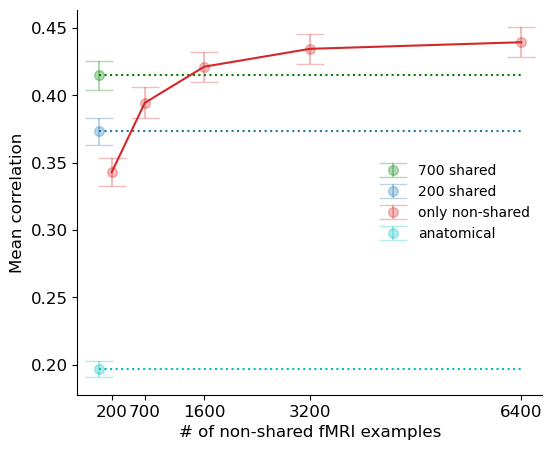

In [28]:
save_name = 'transf_NSD_plot_s200_and_s700_anatomical_ns_only_fsaverage'
plot_how_the_amount_non_shared_examples_affect_transformations(df4_fsaverage, calc_delta=False,
                                                               percents=False,
                                                               with_ns=False, fill_between=False,
                                                               save_name=save_name, plot_std=True,
                                                               baseline_dct={TransfKinds.S_Small: df6_fsaverage},
                                                               anatomical=NSD_transf_anatomical_corr_calc_mat[0][s1s4_fsaverage-1, s2s4_fsaverage-1], 
                                                               xlabel=X_LABEL_NS_EXPS)

### Statistical tests

In [29]:
s1s4, s2s4, df4 = get_csvs(4)
df4

shared  non_shared  external  teacher  \
0     700           0         0      NaN   
1     700         900      6400      NaN   
2     700        2500      6400      NaN   
3     700        5700      6400      NaN   
4       0         200      6400      NaN   
5       0         700      6400      NaN   
6       0        1600      6400      NaN   
7       0        3200      6400      NaN   
8       0        6400      6400      NaN   

                                           test_corr  \
0  [0.5605440414716945, 0.4193004441015606, 0.430...   
1  [0.5728506781191594, 0.4365351600329374, 0.450...   
2  [0.5797877669094775, 0.4443210268478528, 0.461...   
3  [0.5739409772969176, 0.446148404878625, 0.4580...   
4  [0.4531854179877452, 0.3384924145587249, 0.357...   
5  [0.5369917116247761, 0.3922021375520152, 0.427...   
6  [0.5549378725432825, 0.4267775378269776, 0.446...   
7  [0.5682069252806144, 0.4368019049910496, 0.451...   
8  [0.5662303161850462, 0.4343830975822419, 0.447...   

                                              perc_d  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [2.19548077170781, 4.11035003034776, 4.5318443...   
2  [3.4330443308716796, 5.96722066438639, 7.05197...   
3  [2.38998808908035, 6.40303657073195, 6.3573092...   
4  [-19.15257598708601, -19.27210683403493, -16.9...   
5  [-4.20169123287481, -6.4627421532093, -0.66710...   
6  [-1.00012996546945, 1.7832305762132499, 3.6381...   
7  [1.36704402187584, 4.17396669516763, 4.8900046...   
8  [1.01442068644999, 3.59709933362915, 3.9442015...   

                                                   d  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0123066366474648, 0.0172347159313768, 0.019...  
2  [0.019243725437783, 0.0250205827462922, 0.0303...  
3  [0.0133969358252231, 0.0268479607770644, 0.027...  
4  [-0.1073586234839492, -0.0808080295428356, -0....  
5  [-0.0235523298469183, -0.0270983065495453, -0....  
6  [-0.0056061689284119, 0.0074770937254169, 0.01...  
7  [0.0076628838089199, 0.017501460889489, 0.0210...  
8  [0.0056862747133517, 0.0150826534806813, 0.016...

In [30]:
s1s6, s2s6, df6 = get_csvs(6)
df6

shared  non_shared  external  teacher  \
0     200           0         0      NaN   
1     200         500      6400      NaN   
2     200        1400      6400      NaN   
3     200        3000      6400      NaN   
4     200        6200      6400      NaN   
5       0         200      6400      NaN   
6       0         700      6400      NaN   
7       0        1600      6400      NaN   
8       0        3200      6400      NaN   
9       0        6400      6400      NaN   

                                           test_corr  \
0  [0.5025875842474513, 0.3819743214835104, 0.383...   
1  [0.5435117201232706, 0.3982170190789115, 0.419...   
2  [0.5534416403598371, 0.4158033607925731, 0.441...   
3  [0.5593561956845654, 0.4251451346515161, 0.441...   
4  [0.5571359816061457, 0.4256119294313665, 0.446...   
5  [0.4531854179877452, 0.3384924145587249, 0.357...   
6  [0.5369917116247761, 0.3922021375520152, 0.427...   
7  [0.5549378725432825, 0.4267775378269776, 0.446...   
8  [0.5682069252806144, 0.4368019049910496, 0.451...   
9  [0.5662303161850462, 0.4343830975822419, 0.447...   

                                              perc_d  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [8.14268739588881, 4.25230092230224, 9.5033801...   
2  [10.11844655663989, 8.85636478852232, 15.16972...   
3  [11.29526737555932, 11.30201972748823, 15.3326...   
4  [10.853510724975909, 11.424225528662891, 16.49...   
5  [-9.82956360405885, -11.38346335845579, -6.594...   
6  [6.845399380257231, 2.6776187542612897, 11.664...   
7  [10.41615231586308, 11.729379129324851, 16.504...   
8  [13.05629965599293, 14.35373542771147, 17.9116...   
9  [12.66301316075886, 13.72049720389225, 16.8484...   

                                                   d  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0409241358758193, 0.016242697595401, 0.0364...  
2  [0.0508540561123858, 0.0338290393090626, 0.058...  
3  [0.056768611437114, 0.0431708131680056, 0.0587...  
4  [0.0545483973586944, 0.043637607947856, 0.0631...  
5  [-0.0494021662597061, -0.0434819069247855, -0....  
6  [0.0344041273773247, 0.0102278160685047, 0.044...  
7  [0.0523502882958312, 0.0448032163434671, 0.063...  
8  [0.0656193410331631, 0.0548275835075391, 0.068...  
9  [0.0636427319375948, 0.0524087760987314, 0.064...

In [31]:
print("Hypothesis: 200ns > anatomical")
for test in TESTS:
    print(test.__name__)
    t = test(df6.iloc[5].test_corr, NSD_transf_anatomical_corr_calc_mat[0][s1s6_fsaverage-1, s2s6_fsaverage-1])
    print(t.pvalue < 0.05)

Hypothesis: 200ns > anatomical
permutation_test
Res: group 1 (M=0.34450995594547884, SD=0.06632131236946154), group2 (M=0.19678655314092394, SD=0.04581250489055878), N=56, t_perm=0.1477234028045549, p=9.99990000099999e-06, d=2.482470934109969
True


In [32]:
print("Hypothesis: 700ns > 200s")
for test in TESTS:
    print(test.__name__)
    t= test(df6.iloc[6].test_corr, df6.iloc[0].test_corr)
    print(t.pvalue < 0.05)
    print()

Hypothesis: 700ns > 200s
permutation_test
Res: group 1 (M=0.407579271496751, SD=0.07405773355938966), group2 (M=0.3851313410894251, SD=0.07401556503321913), N=56, t_perm=0.022447930407325872, p=9.99990000099999e-06, d=1.6152775556056744
True



In [33]:
print("Hypothesis: 1600ns > 700s")
for test in TESTS:
    print(test.__name__)
    t = test(df4.iloc[6].test_corr, df4.iloc[0].test_corr)
    print(t.pvalue < 0.05)
    print()

Hypothesis: 1600ns > 700s
permutation_test
Res: group 1 (M=0.4349668440211059, SD=0.0730337133894574), group2 (M=0.42900663905833086, SD=0.07162248183369495), N=56, t_perm=0.005960204962775022, p=0.0005899941000589994, d=0.44362392856918514
True



## Figure 4b (and S3)

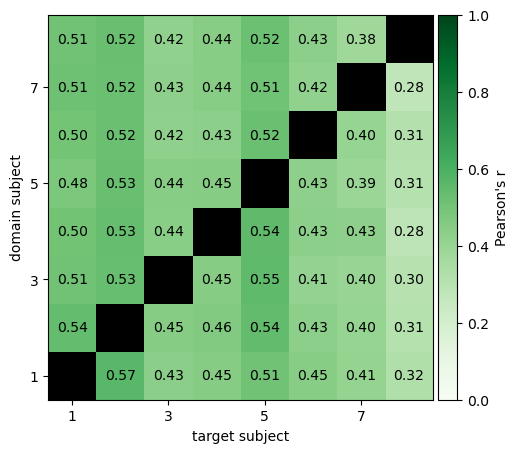

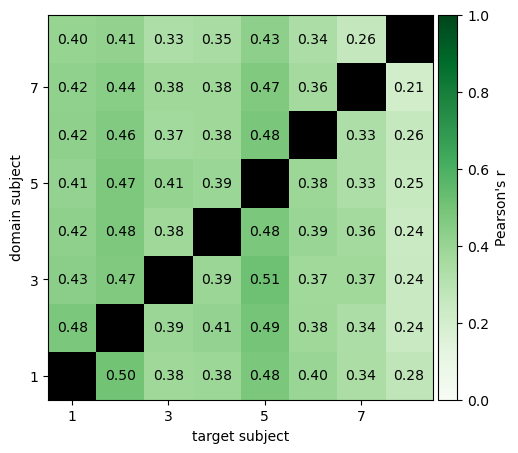

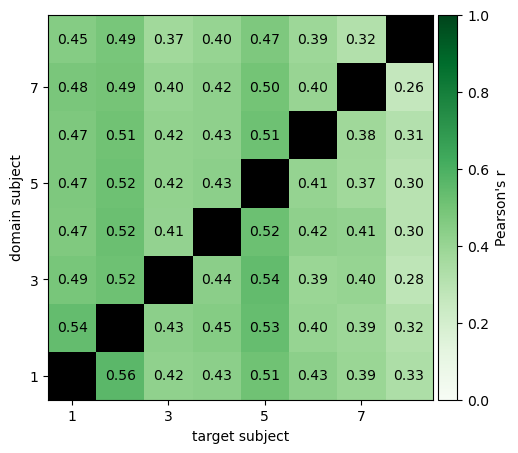

In [34]:
for s, ns, e in ((0, 6400, 6400), (200, 0, 0), (700, 0, 0)):
    heatmap_individual_diff(dict(s=s, ns=ns, e=e, fsaverage=True), 
                            corr_df=(df6 if s in (0, 200) else df4), 
                            s1s=s1s6 if s in (0, 200) else s1s4, s2s=s2s6 if s in (0, 200) else s2s4)

# Figure 6 and encoder improvement statistical tests

## Figure 6a (and S1d, and the rest of the subjects - S9 left)

In [35]:
enc_corr_Kn_teacher = np_load("encoders_GOD_corr_calc_mat.npy", NEW_DATA_DIR)

In [36]:
teacher_kinds = [EncoderKinds.Baseline, EncoderKinds.TeacherImageNet, EncoderKinds.TeacherNSD]

In [37]:
# (teacher {no teacher, 4k, 1n, 2n}, repeats, statistic {mean, median, 75%, 95%}, subject, examples)
enc_corr_Kn_teacher.shape

(4, 3, 4, 5, 8)

In [38]:
exp_arr_Kn_repeats_ticks = np.array([f'{exp_arr_Kn[-1]}x{rep}' for rep in np.arange(1,6)])     

In [39]:
ylim_corr = [f(enc_corr_Kn_teacher[:len(teacher_kinds), :, 0][enc_corr_Kn_teacher[:len(teacher_kinds), :, 0] > 0]) for f in (np.nanmin, np.nanmax)]

/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


Res: group 1 (M=0.2668968326886874, SD=0.07410663173467189), group2 (M=0.1583994499761318, SD=0.0526650907830832), N=12, t_perm=0.10849738271255562, p=0.000244140625, d=3.3189522121001502
Res: group 1 (M=0.33710135991178314, SD=0.09445408324533112), group2 (M=0.1583994499761318, SD=0.0526650907830832), N=12, t_perm=0.17870190993565127, p=0.000244140625, d=3.449113956718305
Res: group 1 (M=0.3305897722291185, SD=0.08741738618626753), group2 (M=0.20144253702486958, SD=0.08226733829135553), N=12, t_perm=0.12914723520424895, p=0.000244140625, d=7.115838985290446
Res: group 1 (M=0.39251096427871307, SD=0.09786416970512074), group2 (M=0.20144253702486958, SD=0.08226733829135553), N=12, t_perm=0.19106842725384357, p=0.000244140625, d=6.693901595392765
Res: group 1 (M=0.3596065461815941, SD=0.09561842853288643), group2 (M=0.2273387102030852, SD=0.10286035255604445), N=12, t_perm=0.13226783597850897, p=0.000244140625, d=9.861149304183089
Res: group 1 (M=0.4165169863273215, SD=0.1035598441677838

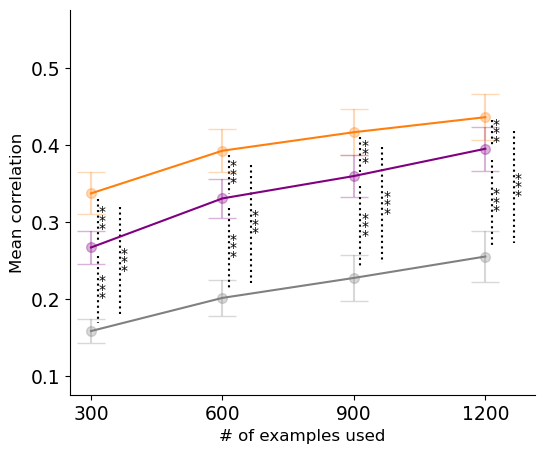

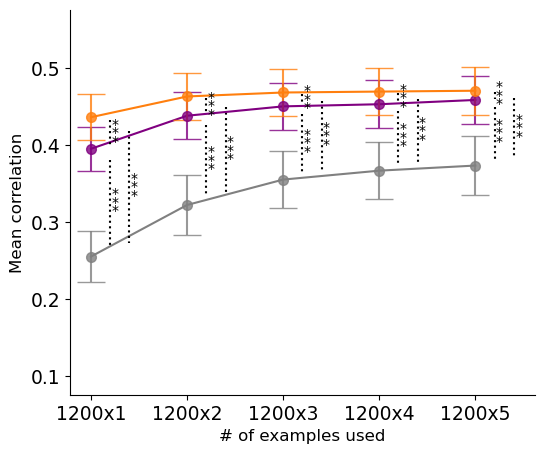

In [40]:
significance = True

for repeats in [False, True]:
    fig = set_figure()
    subjects_mask = np.arange(1,6) != 4
    for i in range(3):
        kind = teacher_kinds[i]
        if not repeats:
            plot_with_err(exp_arr_Kn, enc_corr_Kn_teacher[i, :, 0][..., subjects_mask, :].reshape(-1, enc_corr_Kn_teacher.shape[-1])[..., :len(exp_arr_Kn)], 
                          ylabel=False, label=kind.value.name, c=kind.value.c, fill_between=False)
            if significance:
                    for sample_ind, sample_num in enumerate(exp_arr_Kn):
                        for j in range(i+1, 3):
                            plot_significance(enc_corr_Kn_teacher[j, :, 0, ... , sample_ind][..., subjects_mask].flatten(), 
                                              enc_corr_Kn_teacher[i, :, 0, ... , sample_ind][..., subjects_mask].flatten(),
                                              loc1=sample_num + 50*(j - i - 1) + 15, 
                                              vertical=True)                            
        else:
            plot_with_err(np.arange(enc_corr_Kn_teacher.shape[-1] - len(exp_arr_Kn) + 1), 
                          enc_corr_Kn_teacher[i,:,0][:, subjects_mask].reshape(-1, enc_corr_Kn_teacher.shape[-1])[..., len(exp_arr_Kn)-1:],
                          label=kind.value.name, c=kind.value.c, alpha=0.8, fill_between=False)
            if significance:                
                for repeat_ind, repeats in enumerate(np.arange(enc_corr_Kn_teacher.shape[-1] - len(exp_arr_Kn) + 1)):
                    for j in range(i+1, 3):
                        plot_significance(enc_corr_Kn_teacher[j, :, 0, ... , len(exp_arr_Kn)-1+repeat_ind][..., subjects_mask].flatten(), 
                                          enc_corr_Kn_teacher[i, :, 0, ... , len(exp_arr_Kn)-1+repeat_ind][..., subjects_mask].flatten(),
                                          loc1=repeat_ind + 0.2*(j - i),
                                          vertical=True, dist_from_line=0.05) 
    if WITH_LEGEND_AND_AXES:
        plt.ylabel(MEAN_CORRELATION)
        plt.xlabel("# of examples used")
    if not repeats:
        plt.xticks(exp_arr_Kn)
    else:
        plt.xticks(np.arange(exp_arr_Kn_repeats_ticks.size), exp_arr_Kn_repeats_ticks)
    plt.ylim(ylim_corr)
    set_ticks_style(fig, ticksize=BIGGER_TICKSIZE)
    save_as_pdf('Kn_mean_encoders' + ("_repeats" if repeats else ""))

In [41]:
def plot_single_subject_Kn(corr_calc_dict, subject=2, suptitle='Kamitani - Visual encoder', name=None, ticksize=BIGGER_TICKSIZE, significance=True, ret=False, ylim=None):

    min_val, max_val = get_total_min_and_max(*[arr[0, subject-1] for arr in corr_calc_dict.values()])
    ylim = (min_val - min_val/25, max_val + max_val/25) if ylim is None else ylim
    figs = []
    
    for repeats in [False, True]:
        
        fig = set_figure(figsize=FIGURE_SIZE, suptitle='')
        ax = fig.add_subplot(111)
        figs.append(fig)
        for kind, arr in corr_calc_dict.items():
            if not repeats:
                plot_with_err(exp_arr_Kn, arr[:, subject - 1, :len(exp_arr_Kn)],
                              label=kind.value.name, c=kind.value.c, alpha=0.8)
                if significance:
                    for i, sample_num in enumerate(exp_arr_Kn):
                        for other_kind in list(corr_calc_dict.keys())[list(corr_calc_dict.keys()).index(kind)+1:]:
                            plot_significance(corr_calc_dict[other_kind][:, subject-1, i], 
                                              arr[:, subject-1, i],
                                              loc1=sample_num + 50*(list(corr_calc_dict.keys()).index(other_kind) - list(corr_calc_dict.keys()).index(kind) - 1), 
                                              vertical=True)
            else:
                plot_with_err(np.arange(arr.shape[-1] - len(exp_arr_Kn) + 1), arr[:, subject - 1, len(exp_arr_Kn)-1:],
                              label=kind.value.name, c=kind.value.c, alpha=0.8)
                if significance:
                    for i, repeats in enumerate(np.arange(arr.shape[-1] - len(exp_arr_Kn) + 1)):
                        for other_kind in list(corr_calc_dict.keys())[list(corr_calc_dict.keys()).index(kind)+1:]:
                            plot_significance(corr_calc_dict[other_kind][:, subject - 1, len(exp_arr_Kn)-1+i], 
                                              arr[:, subject - 1, len(exp_arr_Kn)-1+i],
                                              loc1=repeats + 0.1*(list(corr_calc_dict.keys()).index(other_kind) - list(corr_calc_dict.keys()).index(kind) - 1), 
                                              vertical=True, dist_from_line=0.05)
        if ret:
            from matplotlib.ticker import PercentFormatter
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
            
        if not repeats:
            plt.xticks(exp_arr_Kn)
        else:
            plt.xticks(np.arange(exp_arr_Kn_repeats_ticks.size), exp_arr_Kn_repeats_ticks)
        if WITH_LEGEND_AND_AXES:
            plt.xlabel(X_LABEL_EXPS)
            if ret:
                plt.ylabel(RETRIEVAL_ACCURACY)
            else:
                plt.ylabel(MEAN_CORRELATION)
        set_legend(fontsize = 12)
        set_ticks_style(fig, ticksize=ticksize)
        if ylim is not None:
            plt.ylim(ylim)
        if name is not None:
            save_as_pdf(name=name + ("_ret" if ret else "") + ("_repeats" if repeats else ""))
    return figs


/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument 

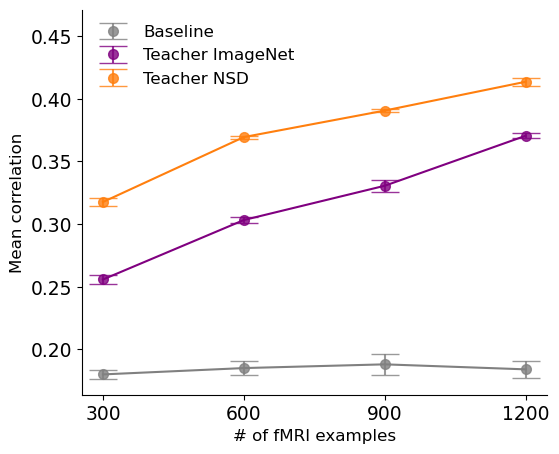

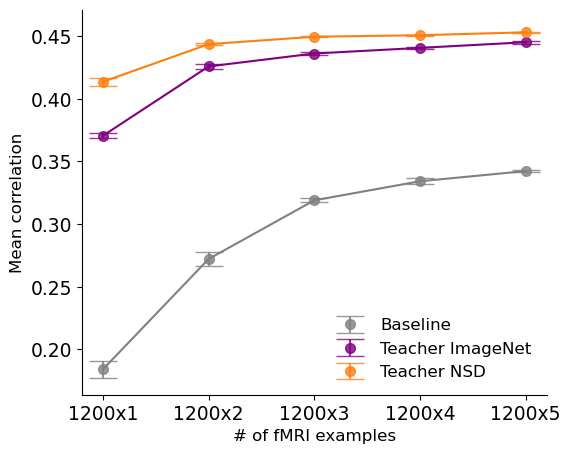

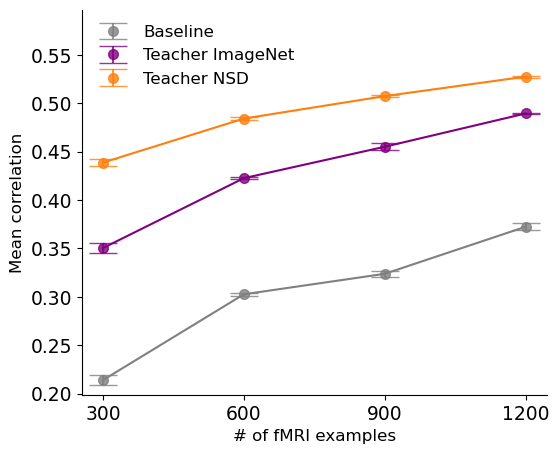

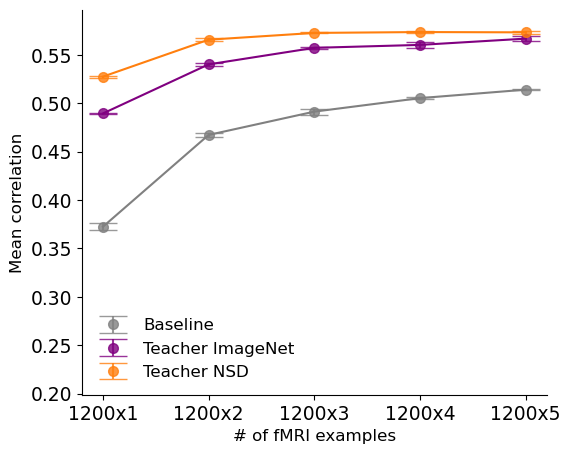

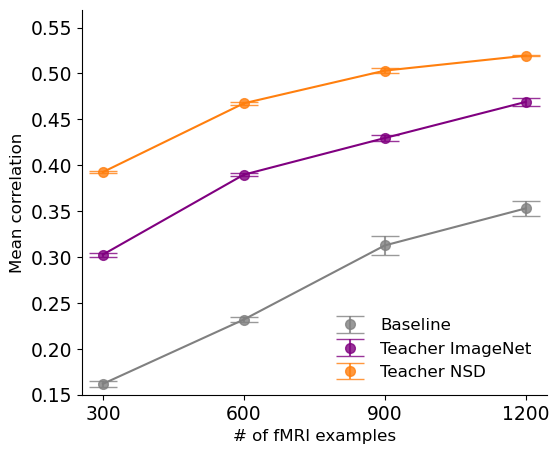

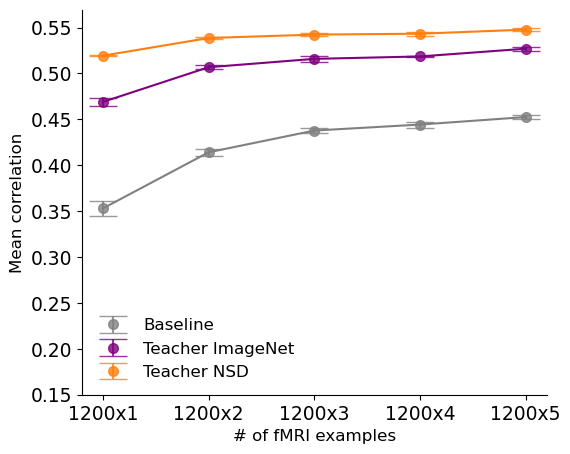

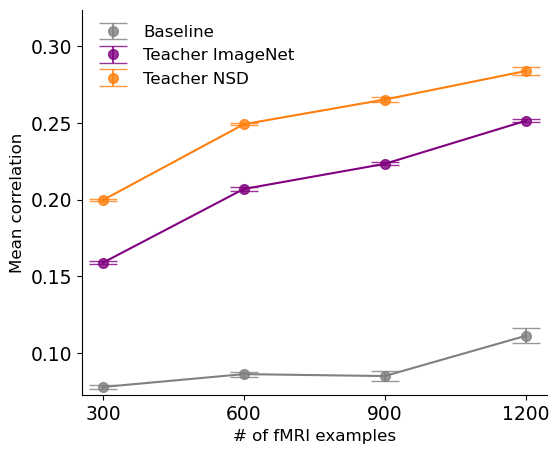

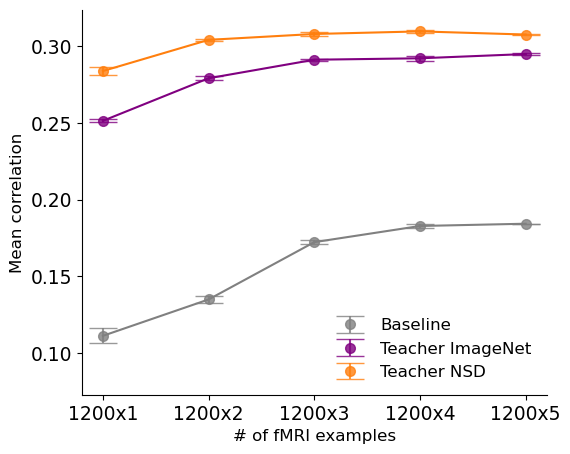

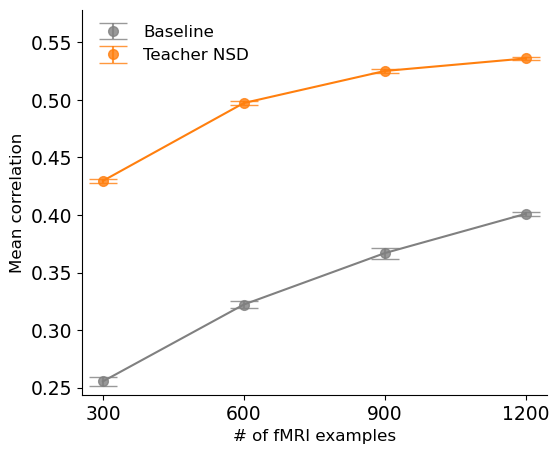

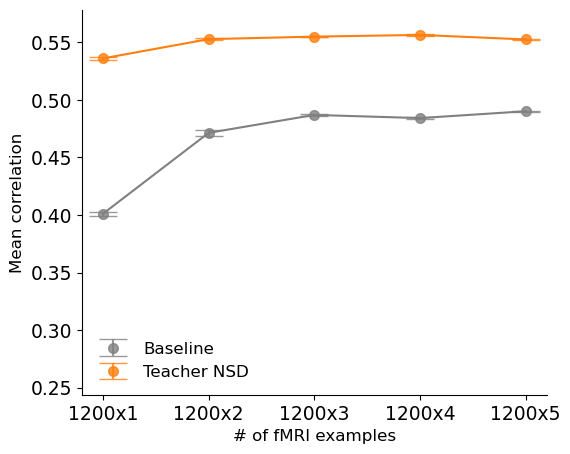

In [42]:
# enc_corr_Kn_mean = enc_corr_Kn.mean(axis=-1)
for subj in subjects_k:
    if subj == subject_4k: continue
    fig = plot_single_subject_Kn({enc_kind: enc_corr_Kn_teacher[i, :, 0] for i, enc_kind in enumerate(teacher_kinds)}, 
                                 subject=subj, name='Encoder_improvment_Kamitani_example_subj_' + str(subj), significance=False,
                                 ylim=ylim_corr if SHAREY else None)
_ = plot_single_subject_Kn({EncoderKinds.Baseline: enc_corr_Kn_teacher[0, :, 0],
                            EncoderKinds.TeacherNSD: enc_corr_Kn_teacher[2, :, 0]}, 
                           subject=subject_4k, name='Encoder_imporvment_Kamitani_example_subj_4', significance=False, ylim=ylim_corr if SHAREY else None)

## Statistical tests

In [43]:
cur_baseline = enc_corr_Kn_teacher[0, :, 0][:, subjects_mask][..., :len(exp_arr_Kn)]
cur_teacher_imagenet = enc_corr_Kn_teacher[1, :, 0][:, subjects_mask][..., :len(exp_arr_Kn)]
cur_teacher_nsd = enc_corr_Kn_teacher[2, :, 0][:, subjects_mask][..., :len(exp_arr_Kn)]

In [44]:
print("Hypothesis: teacher imagenet > baseline per number of examples")
for test in TESTS:
    print(test.__name__)
    t = test(cur_teacher_imagenet.flatten(), cur_baseline.flatten())
    print(t.pvalue < 0.05)
    print()

Hypothesis: teacher imagenet > baseline per number of examples
permutation_test
Res: group 1 (M=0.3380298158585344, SD=0.09871333101693261), group2 (M=0.2105807505195203, SD=0.09569972867886448), N=48, t_perm=0.12744906533901415, p=9.99990000099999e-06, d=4.703142100635696
True



In [45]:
print("Hypothesis: teacher NSD > teacher imagenet")
for test in TESTS:
    print(test.__name__)
    t = test(cur_teacher_nsd.flatten(), cur_teacher_imagenet.flatten())
    print(t.pvalue < 0.05)
    print()

Hypothesis: teacher NSD > teacher imagenet
permutation_test
Res: group 1 (M=0.3955370887293996, SD=0.10360473605024535), group2 (M=0.3380298158585344, SD=0.09871333101693261), N=48, t_perm=0.05750727287086512, p=9.99990000099999e-06, d=3.143887364556861
True



## Figure 6b

In [46]:
exp_arr_vim = np.array(list(exp_arr_Kn) + [1750])

In [47]:
# (teacher {ref, 4k, 1n}, runs, statistic {mean, median, 75%, 95%}, subject, examples)
enc_corr_vim = np_load("encoders_Vim1_corr_calc_mat.npy", NEW_DATA_DIR)[:, :, 0]
ylim_vim = [enc_corr_vim.min(), enc_corr_vim.max()]

In [48]:
teacher_kinds = [EncoderKinds.Baseline, EncoderKinds.TeacherImageNet, EncoderKinds.TeacherNSD]

Res: group 1 (M=0.3258575677711251, SD=0.001973129594929565), group2 (M=0.2720738996988032, SD=0.002328801979291894), N=6, t_perm=0.053783668072321954, p=0.015625, d=21.253485740797988
Res: group 1 (M=0.36183804939513325, SD=0.003469352878002075), group2 (M=0.2720738996988032, SD=0.002328801979291894), N=6, t_perm=0.08976414969633013, p=0.015625, d=20.98528696675814
Res: group 1 (M=0.3813385921953592, SD=0.0020931765084593037), group2 (M=0.35058068283284166, SD=0.003379841739675198), N=6, t_perm=0.030757909362517644, p=0.015625, d=9.32863683225647
Res: group 1 (M=0.39441133587865873, SD=0.002164012484516966), group2 (M=0.35058068283284166, SD=0.003379841739675198), N=6, t_perm=0.04383065304581709, p=0.015625, d=9.305583090467199
Res: group 1 (M=0.40024147783231556, SD=0.0013108018494874518), group2 (M=0.3689120943023134, SD=0.0033719835196504167), N=6, t_perm=0.03132938353000217, p=0.015625, d=8.4618749541416
Res: group 1 (M=0.4061748452784579, SD=0.0014518763481835642), group2 (M=0.36

/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


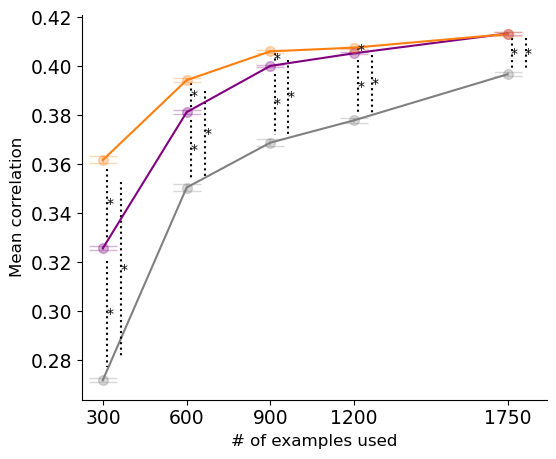

In [49]:
significance = True

fig = set_figure()
for i in range(3):
    kind = teacher_kinds[i]
    plot_with_err(exp_arr_vim, enc_corr_vim[i].reshape(-1, enc_corr_vim.shape[-1]), 
                  ylabel=False, label=kind.value.name, c=kind.value.c, fill_between=False)
    if significance:
            for sample_ind, sample_num in enumerate(exp_arr_vim):
                for j in range(i+1, 3):
                    plot_significance(enc_corr_vim[j, ... , sample_ind].flatten(), 
                                      enc_corr_vim[i, ... , sample_ind].flatten(),
                                      loc1=sample_num + 50*(j - i - 1) + 15, 
                                      vertical=True
                                     )                       
if WITH_LEGEND_AND_AXES:
    plt.ylabel(MEAN_CORRELATION)
    plt.xlabel("# of examples used")
plt.xticks(exp_arr_vim)
if SHAREY:
    plt.ylim(ylim_vim)
set_ticks_style(fig, ticksize=BIGGER_TICKSIZE)
save_as_pdf('vim_mean_encoders')

In [50]:
def plot_single_subject_vim(corr_calc_mat, kinds, subject=2, save=False, 
                            dataset='VIM1', examples=exp_arr_vim, axhline={}, ticksize=BIGGER_TICKSIZE, ylim=None):
    fig = set_figure()
    for encoder_kind, arr in zip(kinds, corr_calc_mat):
        plot_with_err(examples, arr[:, subject-1], label=encoder_kind.value.name, c=encoder_kind.value.color)
        # plt.plot(examples, arr[subject-1], marker='.', markersize=10, 
        #          label=encoder_kind.value.name, alpha=0.8, c=encoder_kind.value.color)
    # for encoder_kind, arr in axhline.items():
    #     plt.plot(examples, arr[subject-1], markersize=10, 
    #              label=encoder_kind.value.name, alpha=0.8, c=encoder_kind.value.color, linestyle=':')
    plt.xticks(examples)
    if ylim is not None:
        plt.ylim(ylim)
    if WITH_LEGEND_AND_AXES:
        plt.xlabel(X_LABEL_EXPS)
        plt.ylabel(MEAN_CORRELATION)
    set_legend()    
    set_ticks_style(fig, ticksize=ticksize)
    if save:
        save_as_pdf(f'{dataset}_improved_encoders_single_example_subject{subject}')

/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


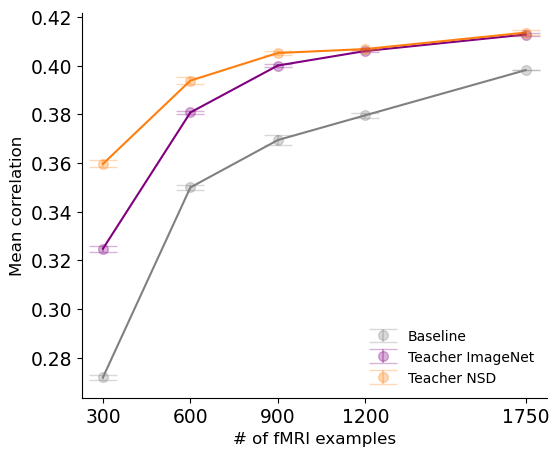

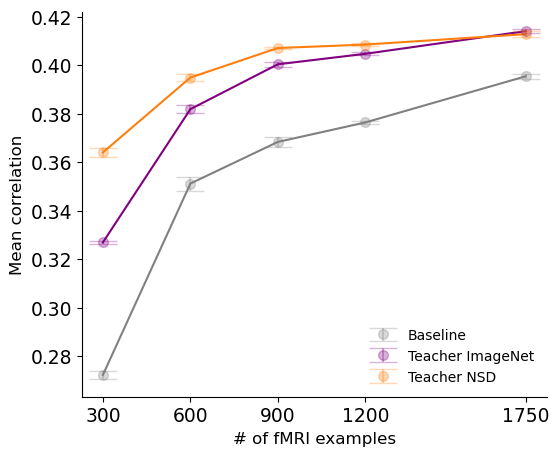

In [51]:
for subj in (1,2):
    plot_single_subject_vim(enc_corr_vim, 
                            [EncoderKinds.Baseline, EncoderKinds.TeacherImageNet, EncoderKinds.TeacherNSD], 
                            subject=subj, save=True, ylim=ylim_vim if SHAREY else None)

# Figure 7

## Figure 7a (and S9 right)

In [52]:
# (teacher {no teacher, 4k, 1n, 2n}, repeats, subject, examples)
enc_ret_Kn_teacher = np.full(enc_corr_Kn_teacher[:, :, 0].shape, np.nan)

for i, tc in enumerate((None, '4k', "1n")):
    for j, exp in enumerate(np.concatenate([exp_arr_Kn, exp_arr_Kn[-1]*np.arange(2, 6)])):
        ret_mat = load_retrieval_mat(s=0, ns=exp, e=0, teacher=None, teacher_code=tc, ver2=True, image_num=1000,
                                                           encoder_only=True, s1_ds="Kn", repeats=True, fsaverage=False)
        if ret_mat is not None:
            enc_ret_Kn_teacher[i, ..., j] = ret_mat.T
ylim_ret = [f(enc_ret_Kn_teacher[:len(teacher_kinds), :, ][enc_ret_Kn_teacher[:len(teacher_kinds), :, ] > 0]) for f in (np.nanmin, np.nanmax)]

loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_300_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_600_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_900_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_1200_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_2400_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_3600_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_4800_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_6000_repeats
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_300_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_600_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_900_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_1200_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_2400_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_3600_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_4800_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_6000_repeats_t4k
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_300_repeats_t1n
loading ret_n1000_ver2_acc_enc_Kn_s_0_ns_600_repeats_

Res: group 1 (M=0.35666666666666663, SD=0.1985095982718735), group2 (M=0.09666666666666668, SD=0.07571877794400365), N=12, t_perm=0.26, p=0.000244140625, d=1.745720763354368
Res: group 1 (M=0.48666666666666664, SD=0.17190554136360803), group2 (M=0.09666666666666668, SD=0.07571877794400365), N=12, t_perm=0.38999999999999996, p=0.000244140625, d=3.3852014771791485
Res: group 1 (M=0.4983333333333333, SD=0.2269895205163499), group2 (M=0.18666666666666668, SD=0.14480917432848298), N=12, t_perm=0.3116666666666667, p=0.000244140625, d=2.6981928267350597
Res: group 1 (M=0.59, SD=0.15643761463512307), group2 (M=0.18666666666666668, SD=0.14480917432848298), N=12, t_perm=0.4033333333333333, p=0.000244140625, d=6.985938257194469
Res: group 1 (M=0.5966666666666667, SD=0.16945545584356828), group2 (M=0.24, SD=0.1697056274847714), N=12, t_perm=0.3566666666666667, p=0.000244140625, d=5.07799527727587
Res: group 1 (M=0.6766666666666666, SD=0.12557745406599458), group2 (M=0.24, SD=0.1697056274847714), N

/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


Res: group 1 (M=0.6766666666666666, SD=0.12557745406599458), group2 (M=0.5966666666666667, SD=0.16945545584356828), N=12, t_perm=0.08, p=0.00146484375, d=1.313579154858371
Res: group 1 (M=0.7333333333333333, SD=0.10030257255228332), group2 (M=0.7100000000000001, SD=0.13170214328345056), N=12, t_perm=0.02333333333333333, p=0.14453125, d=0.34517003331832347
Res: group 1 (M=0.7100000000000001, SD=0.13170214328345056), group2 (M=0.2816666666666667, SD=0.18359210387721092), N=12, t_perm=0.42833333333333345, p=0.000244140625, d=3.0711791805288153
Res: group 1 (M=0.7333333333333333, SD=0.10030257255228332), group2 (M=0.2816666666666667, SD=0.18359210387721092), N=12, t_perm=0.4516666666666667, p=0.000244140625, d=4.501008569447626
Res: group 1 (M=0.8450000000000001, SD=0.09690670302362522), group2 (M=0.58, SD=0.23525614666880554), N=12, t_perm=0.26500000000000007, p=0.000244140625, d=1.7076593381734657
Res: group 1 (M=0.835, SD=0.09839623052646977), group2 (M=0.58, SD=0.23525614666880554), N=

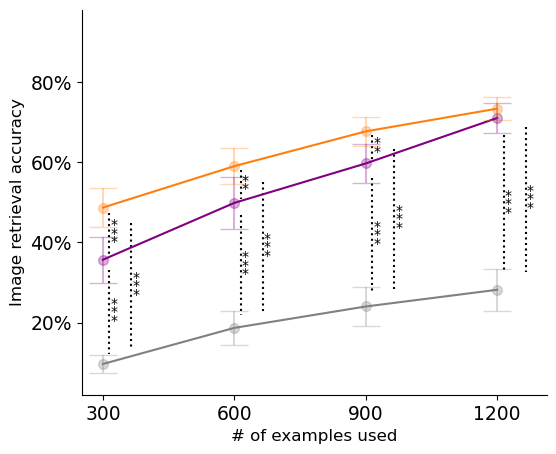

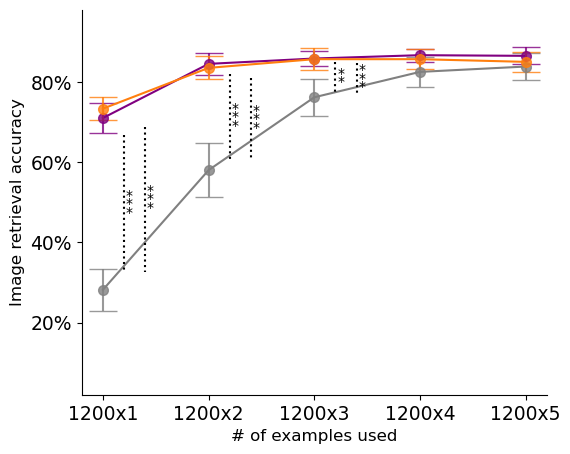

In [53]:
significance = True

for repeats in [False, True]:
    fig = set_figure()
    ax = fig.add_subplot(111)
    subjects_mask = np.arange(1,6) != 4
    for i in range(0,3):
        kind = teacher_kinds[i]
        if not repeats:
            plot_with_err(exp_arr_Kn, enc_ret_Kn_teacher[i][..., subjects_mask, :].reshape(-1, enc_ret_Kn_teacher.shape[-1])[..., :len(exp_arr_Kn)], 
                          ylabel=False, label=kind.value.name, c=kind.value.c, fill_between=False)
            if significance:
                    for sample_ind, sample_num in enumerate(exp_arr_Kn):
                        for j in range(i+1, 3):
                            plot_significance(enc_ret_Kn_teacher[j, ... , sample_ind][..., subjects_mask].flatten(), 
                                              enc_ret_Kn_teacher[i, ... , sample_ind][..., subjects_mask].flatten(),
                                              loc1=sample_num + 50*(j - i - 1) + 15, 
                                              vertical=True
                                             )                            
        else:
            plot_with_err(np.arange(enc_ret_Kn_teacher.shape[-1] - len(exp_arr_Kn) + 1), 
                          enc_ret_Kn_teacher[i][:, subjects_mask].reshape(-1, enc_ret_Kn_teacher.shape[-1])[..., len(exp_arr_Kn)-1:],
                          label=kind.value.name, c=kind.value.c, alpha=0.8, )
            if significance:                
                for repeat_ind, repeats in enumerate(np.arange(enc_ret_Kn_teacher.shape[-1] - len(exp_arr_Kn) + 1)):
                    for j in range(i+1, 3):
                        plot_significance(enc_ret_Kn_teacher[j, ... , len(exp_arr_Kn)-1+repeat_ind][..., subjects_mask].flatten(), 
                                          enc_ret_Kn_teacher[i, ... , len(exp_arr_Kn)-1+repeat_ind][..., subjects_mask].flatten(),
                                          loc1=repeat_ind + 0.2*(j - i),
                                          vertical=True, 
                                          dist_from_line=0.05) 
    from matplotlib.ticker import PercentFormatter
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    
    if WITH_LEGEND_AND_AXES:
        plt.ylabel("Image r" + RETRIEVAL_ACCURACY[1:])
        plt.xlabel("# of examples used")
    if not repeats:
        plt.xticks(exp_arr_Kn)
    else:
        plt.xticks(np.arange(exp_arr_Kn_repeats_ticks.size), exp_arr_Kn_repeats_ticks)
    plt.ylim(ylim_ret)
    set_ticks_style(fig, ticksize=BIGGER_TICKSIZE)
    save_as_pdf('Kn_mean_ret_acc_ver2_n1000_encoders' + ("_repeats" if repeats else ""))

/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',
/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument 

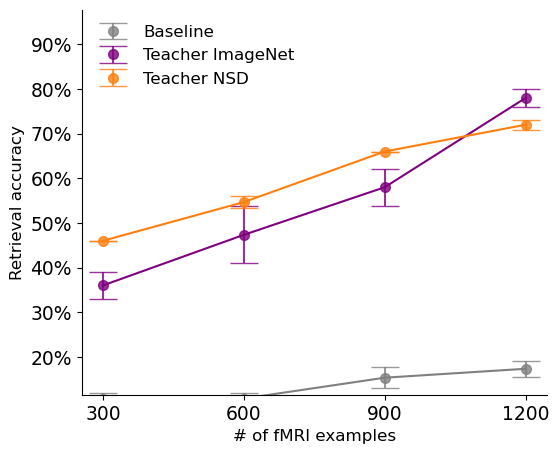

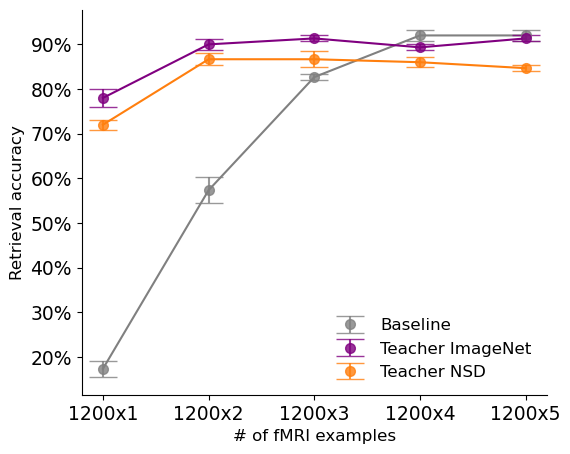

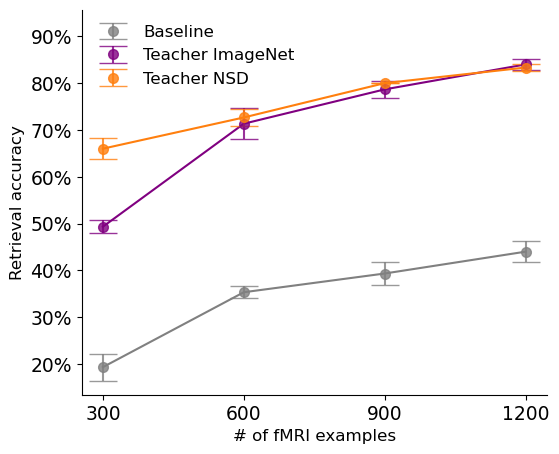

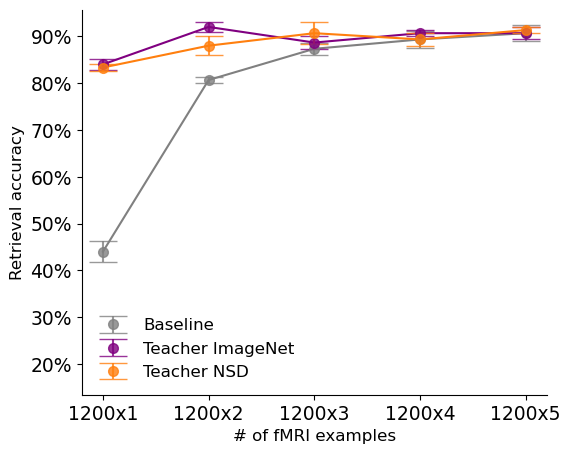

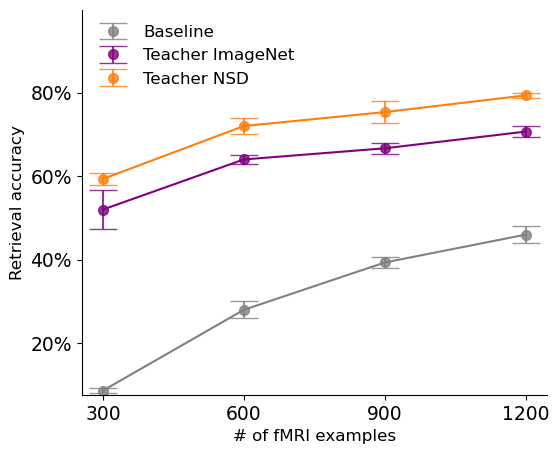

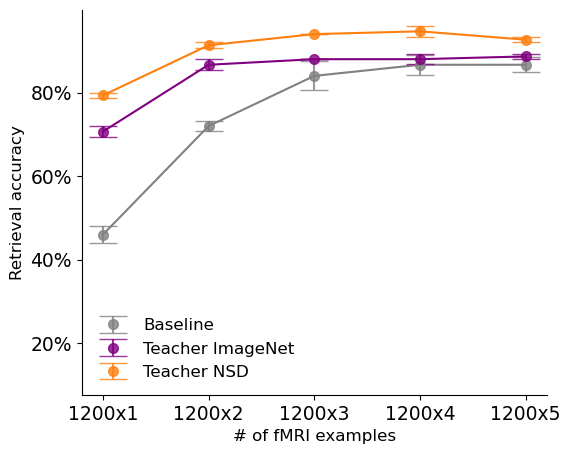

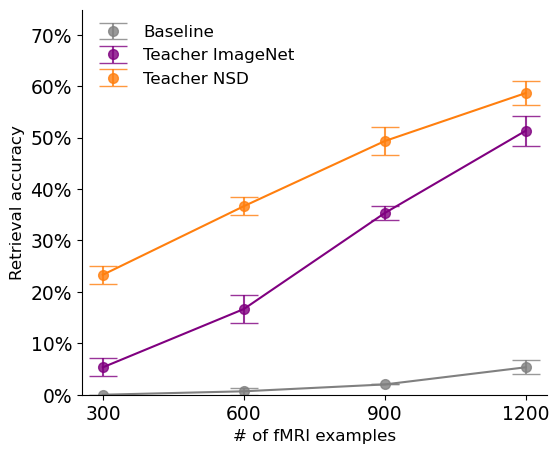

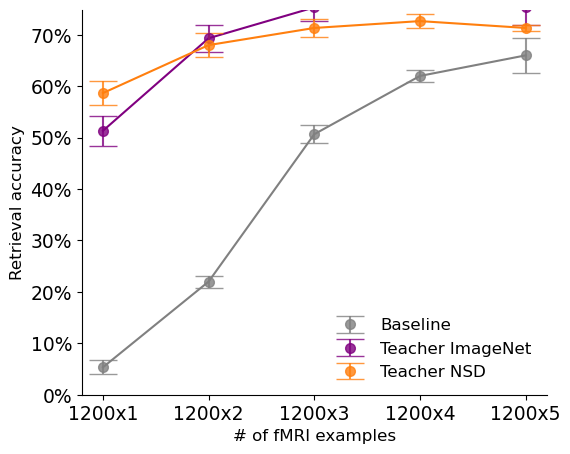

In [54]:
for subj in subjects_k:
    if subj == subject_4k: continue
    fig = plot_single_subject_Kn({enc_kind: enc_ret_Kn_teacher[i] for i, enc_kind in enumerate(teacher_kinds)}, 
                                 subject=subj, name='Encoder_improvment_Kamitani_example_subj_' + str(subj), 
                                 ret=True, significance=False, ylim=ylim_ret if SHAREY else None)

# Figure 8 (and S11) and classification statistical tests

## Figure

In [55]:
classification_df = csv_load("class_100_allsub_addruns_fix.csv")

In [56]:
for samples in pd.unique(classification_df.samples):
    for repeat in range(1,4):
        ref_acc = classification_df[(classification_df.samples == samples) & (classification_df.type == 'ref') & (classification_df.subj == 4) & (classification_df.run == repeat)].acc.item()
        classification_df = pd.concat([classification_df, pd.DataFrame.from_records([{"Unnamed: 0": 0, 'samples': samples, 'acc': ref_acc, "type": "SS_with_4o", 'subj': 4, 'run': repeat}])])

In [57]:
kinds = [EncoderKinds.Baseline, EncoderKinds.TeacherImageNet, EncoderKinds.TeacherNSD]
dct = {'ref': kinds[0], 'SS_with_4o': kinds[1], 'SS_with_1n': kinds[2]}
classification_df['kind'] = [dct[s] for s in classification_df['type']]

In [58]:
number_of_samples = sorted(classification_df.samples.unique())
acc_as_arr = np.full((len(kinds), 3, len(classification_df.subj.unique()), len(number_of_samples)), np.nan)
for i, row in classification_df.iterrows():
    acc_as_arr[kinds.index(row.kind), row.run-1, row.subj-1, number_of_samples.index(row.samples)] = row.acc

Res: group 1 (M=0.13522533333333334, SD=0.024096976060039046), group2 (M=0.11334933333333333, SD=0.024493558181304588), N=15, t_perm=0.021876000000000003, p=0.00048828125, d=1.3174619806557892
Res: group 1 (M=0.153932, SD=0.025802975243730552), group2 (M=0.11334933333333333, SD=0.024493558181304588), N=15, t_perm=0.04058266666666667, p=3.0517578125e-05, d=2.1895397452088092
Res: group 1 (M=0.153932, SD=0.025802975243730552), group2 (M=0.13522533333333334, SD=0.024096976060039046), N=15, t_perm=0.018706666666666663, p=0.002685546875, d=0.8246828080812221
Res: group 1 (M=0.14939466666666668, SD=0.011629112401129129), group2 (M=0.111672, SD=0.035606133340038086), N=15, t_perm=0.037722666666666654, p=0.00048828125, d=1.063612547593924
Res: group 1 (M=0.17096933333333333, SD=0.023944435520198693), group2 (M=0.111672, SD=0.035606133340038086), N=15, t_perm=0.05929733333333331, p=3.0517578125e-05, d=4.015058371424689
Res: group 1 (M=0.17096933333333333, SD=0.023944435520198693), group2 (M=0.1

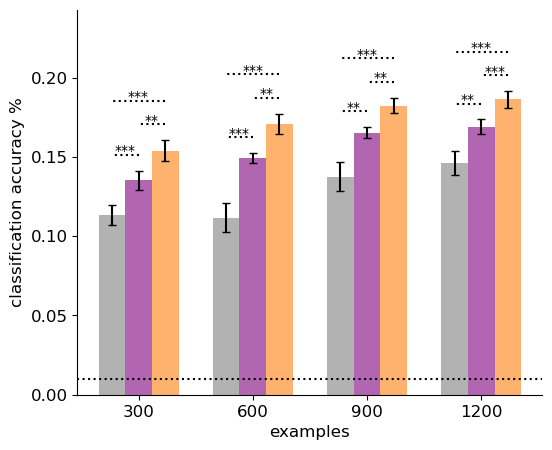

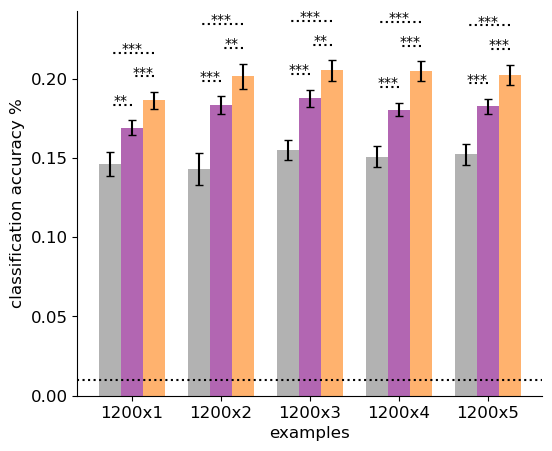

In [59]:
ymax = acc_as_arr.max()
for repeats in [False, True]:
    width = 0.25 if repeats else BAR_WIDTH
    chance_level = 1/100
    
    fig = set_figure()
    for i, num_samples in enumerate(np.arange(exp_arr_Kn_repeats_ticks.size) if repeats else exp_arr_Kn):
        for j, kind in enumerate(kinds):
            plot_bar_with_err(acc_as_arr[j, ..., i+len(exp_arr_Kn)-1 if repeats else i].flatten(), 
                              kind=kind, width=width, loc=num_samples + width*(j-1))
        for kind_j in range(len(kinds)-1):
            for kind_bigger_j in range(kind_j+1, len(kinds)):   
                plot_significance(acc_as_arr[kind_bigger_j, ..., i+len(exp_arr_Kn)-1 if repeats else i].flatten(), 
                                  acc_as_arr[kind_j, ..., i+len(exp_arr_Kn)-1 if repeats else i].flatten(), 
                                  num_samples + width*(kind_bigger_j-1),
                                  num_samples + width*(kind_j-1), dist=kind_bigger_j - kind_j - 1)
        
    plt.axhline(chance_level, c='k', linestyle=':')
    if not repeats:
        plt.xticks(exp_arr_Kn)
    else:
        plt.xticks(np.arange(exp_arr_Kn_repeats_ticks.size), exp_arr_Kn_repeats_ticks)
    if WITH_LEGEND_AND_AXES:
        plt.xlabel("examples")
        plt.ylabel("classification accuracy %")
    plt.ylim(0, ymax)
    set_ticks_style(fig)
    save_as_pdf("encoder_improv_allruns_classifiaction_Kn" + ("_repeats" if repeats else ""))

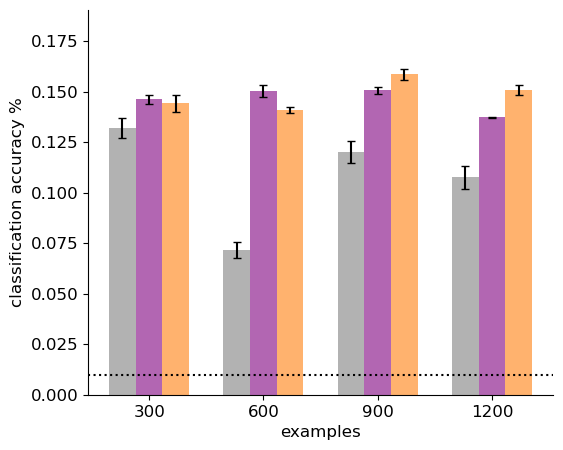

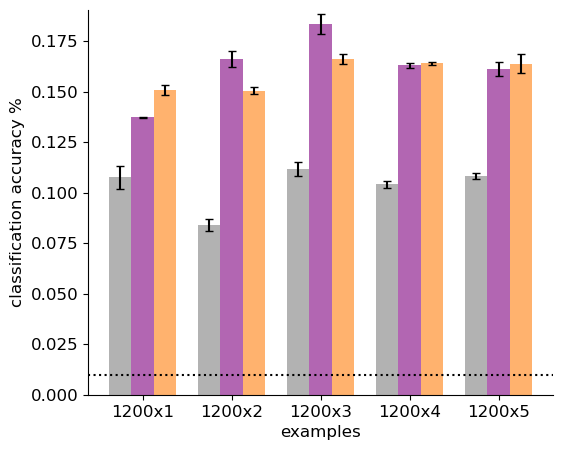

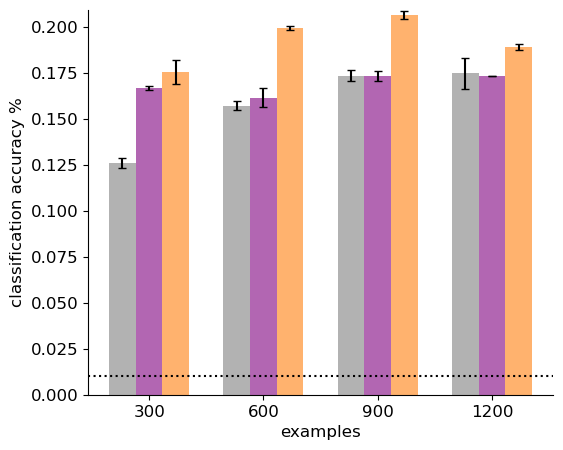

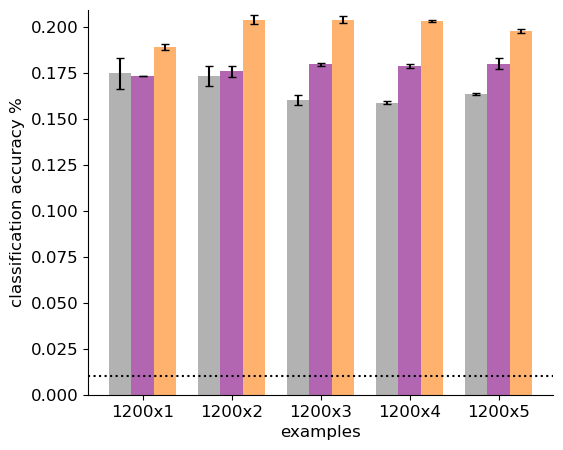

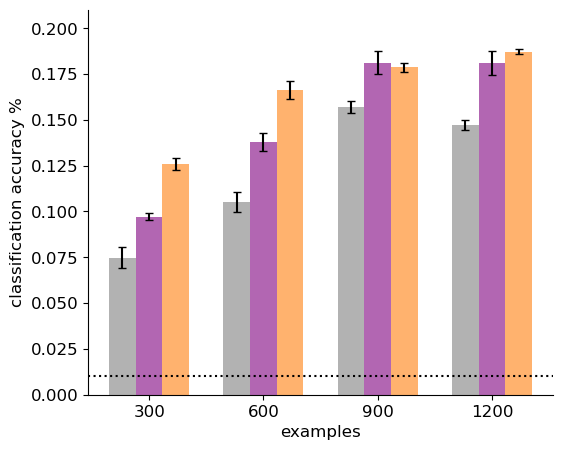

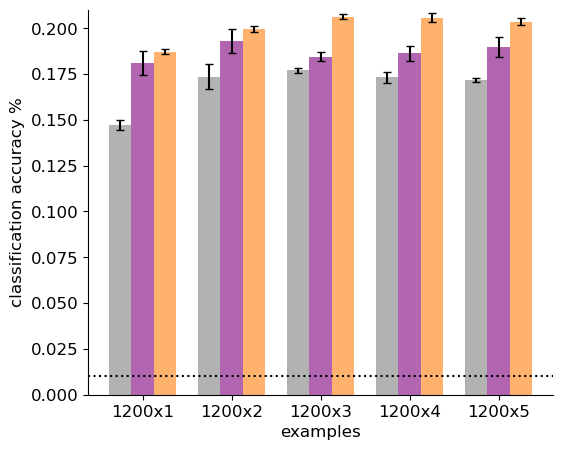

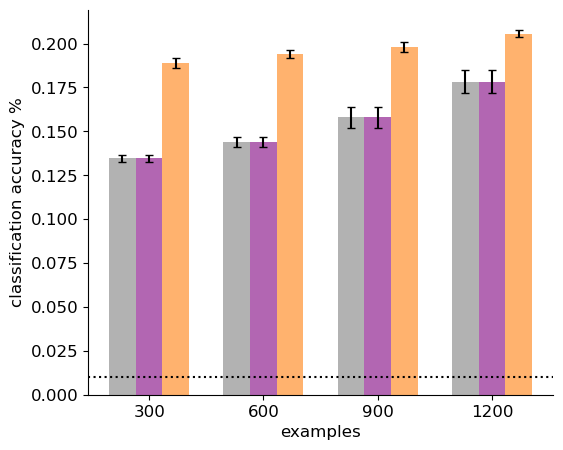

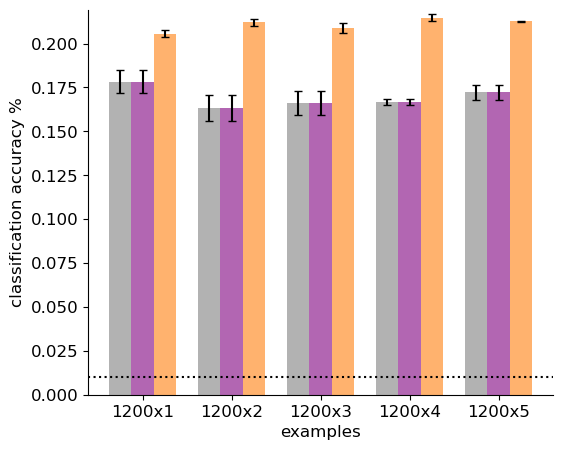

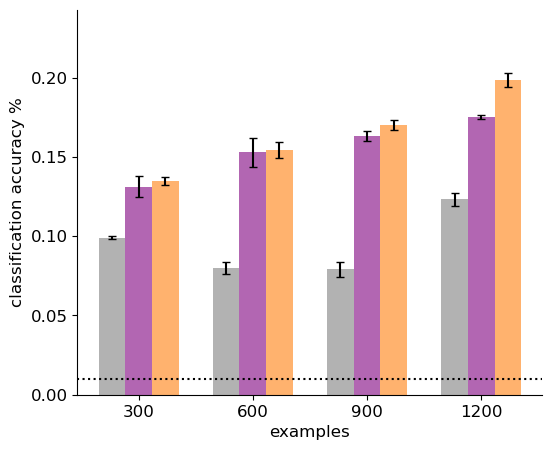

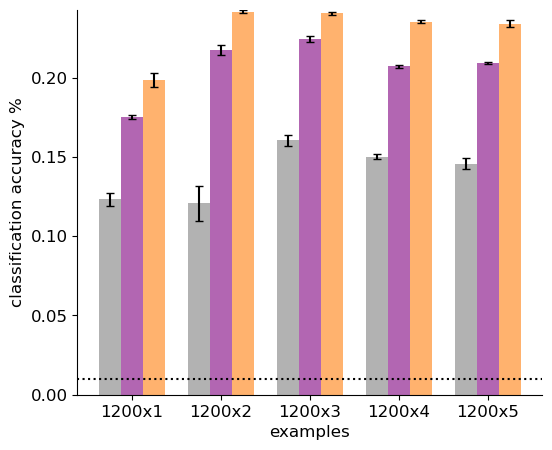

In [60]:
for sub_ind in range(acc_as_arr.shape[2]):
    ymax = acc_as_arr[:, :, sub_ind].max()
    for repeats in [False, True]:
        width = 0.25 if repeats else BAR_WIDTH
        chance_level = 1/100
        
        fig = set_figure()
        for i, num_samples in enumerate(np.arange(exp_arr_Kn_repeats_ticks.size) if repeats else exp_arr_Kn):
            for j, kind in enumerate(kinds):
                plot_bar_with_err(acc_as_arr[j, :, sub_ind, i+len(exp_arr_Kn)-1 if repeats else i].flatten(), 
                                  kind=kind, width=width, loc=num_samples + width*(j-1))
            
        plt.axhline(chance_level, c='k', linestyle=':')
        if not repeats:
            plt.xticks(exp_arr_Kn)
        else:
            plt.xticks(np.arange(exp_arr_Kn_repeats_ticks.size), exp_arr_Kn_repeats_ticks)
        if WITH_LEGEND_AND_AXES:
            plt.xlabel("examples")
            plt.ylabel("classification accuracy %")
        plt.ylim(0, ymax)
        set_ticks_style(fig)
        save_as_pdf(f"encoder_improv_allruns_classifiaction_Kn_sub{sub_ind+1}" + ("_repeats" if repeats else ""))

## Statistical tests

In [61]:
kinds

[<EncoderKinds.Baseline: <__main__.NameAndColor object at 0x7f6ca4a6dc40>>,
 <EncoderKinds.TeacherImageNet: <__main__.NameAndColor object at 0x7f6cdf08f620>>,
 <EncoderKinds.TeacherNSD: <__main__.NameAndColor object at 0x7f6ca4b67530>>]

In [62]:
print("Hypothesis: Classification accuracy EncoderKinds.TeacherImageNet > EncoderKinds.Baseline")

for test in TESTS:
    print(test.__name__)
    t = test(acc_as_arr[kinds.index(EncoderKinds.TeacherImageNet)].flatten(), acc_as_arr[kinds.index(EncoderKinds.Baseline)].flatten())
    print(t.pvalue < 0.05)
    print()

Hypothesis: Classification accuracy EncoderKinds.TeacherImageNet > EncoderKinds.Baseline
permutation_test
Res: group 1 (M=0.16910483333333334, SD=0.024966286915056663), group2 (M=0.1387398333333333, SD=0.03355808424894639), N=120, t_perm=0.030364999999999996, p=9.99990000099999e-06, d=1.015301256421971
True



In [63]:
print("Hypothesis: Classification accuracy EncoderKinds.TeacherNSD > EncoderKinds.TeacherImageNet")
for test in TESTS:
    print(test.__name__)
    t = test(acc_as_arr[kinds.index(EncoderKinds.TeacherNSD)].flatten(), acc_as_arr[kinds.index(EncoderKinds.TeacherImageNet)].flatten())
    print(t.pvalue < 0.05)
    print()

Hypothesis: Classification accuracy EncoderKinds.TeacherNSD > EncoderKinds.TeacherImageNet
permutation_test
Res: group 1 (M=0.18841583333333334, SD=0.02934154617726934), group2 (M=0.16910483333333334, SD=0.024966286915056663), N=120, t_perm=0.019311, p=9.99990000099999e-06, d=0.9866507426311608
True



# Figure S1

## Figure S1b (and S12)

In [64]:
god_snr_fn = os.path.join(DATA_DIR, "snr_GOD.npy")
if os.path.exists(god_snr_fn):
    snr = np.load(god_snr_fn)
else:
    from roy_utils import Subject
    snr = np.array([Subject(s, s_examples=0, ns_examples=300, NSD=False).get_data()['other_SNR'].mean() for s in range(1,6)])
    np.save(god_snr_fn, snr) 

In [65]:
nsd_snr_fn = os.path.join(DATA_DIR, "snr_NSD.npy")
if os.path.exists(nsd_snr_fn):
    snr_NSD = np.load(nsd_snr_fn)
else:
    from roy_utils import Subject
    snr_NSD =  np.array([Subject(s).get_data()['SNR'] for s in range(1,9)]).mean(axis=-1)
    np.save(nsd_snr_fn, snr) 

In [66]:
enc_corr_NSD = np_load("encoders_NSD_corr_calc_mat.npy")[0,...,-1]

In [67]:
from scipy import stats
# (teacher {no teacher, 4k, 1n, 2n}, repeats, statistic {mean, median, 75%, 95%}, subject, examples)
stats.pearsonr(enc_corr_NSD, snr_NSD)

PearsonRResult(statistic=0.9551501413042756, pvalue=0.00021802130780056807)

In [68]:
import numpy as np
improved_encoder_mean_corr_repeats = np_load('GOD_with_NSD_SNR_corr_calc_mat.npy', NEW_DATA_DIR)[1:, :, 0, :, 0]
improved_encoder_mean_corr = np.mean(improved_encoder_mean_corr_repeats, axis=1)
baseline_encoder_mean_corr = np_load('encoder_Kn_ref_corr_mat.npy').mean(axis=-1)[0, ..., 0]
improvement_diff = improved_encoder_mean_corr - baseline_encoder_mean_corr[None]

outlier_subject_mask = snr_NSD != snr_NSD.max()

student 1


/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


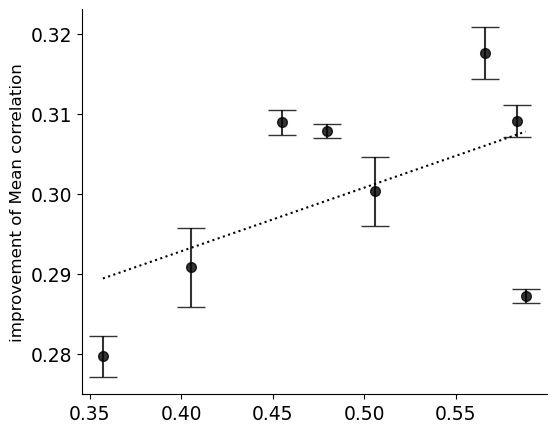

	with outlier subject: R^2=0.26695638161603175, r=0.5166782186390595, p=0.09491674235625093


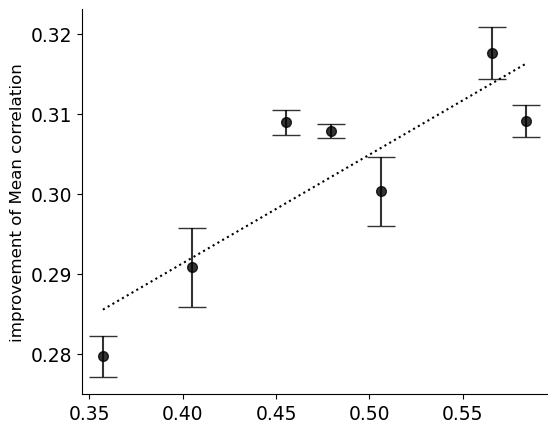

	without outlier subject: R^2=0.7359315171499928, r=0.8578645097857778, p=0.006765247715204607
student 2


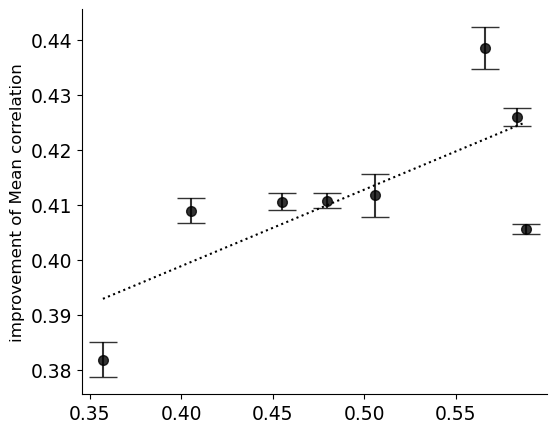

	with outlier subject: R^2=0.5235366703868074, r=0.7235583393112178, p=0.021234776999788617


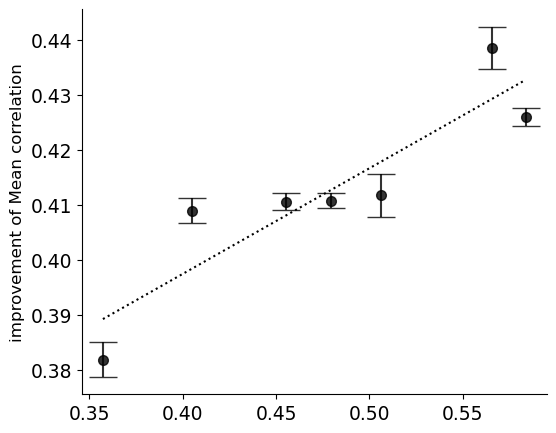

	without outlier subject: R^2=0.8117119210018845, r=0.9009505652375631, p=0.002809384597054854
student 3


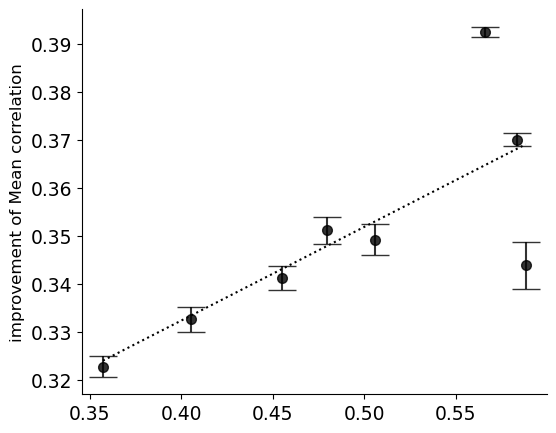

	with outlier subject: R^2=0.5710852816454496, r=0.7557018470570583, p=0.015049009027972432


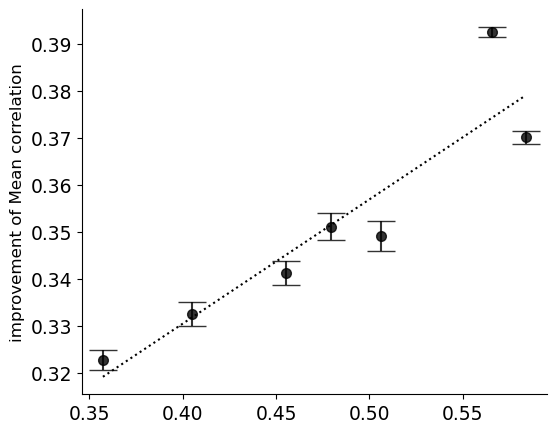

	without outlier subject: R^2=0.8412220262931881, r=0.9171815666994121, p=0.0018121566917723363
student 4


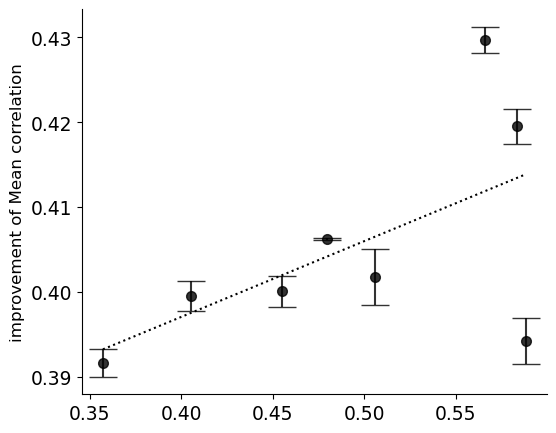

	with outlier subject: R^2=0.34108390189888854, r=0.5840238881234984, p=0.06423876442394374


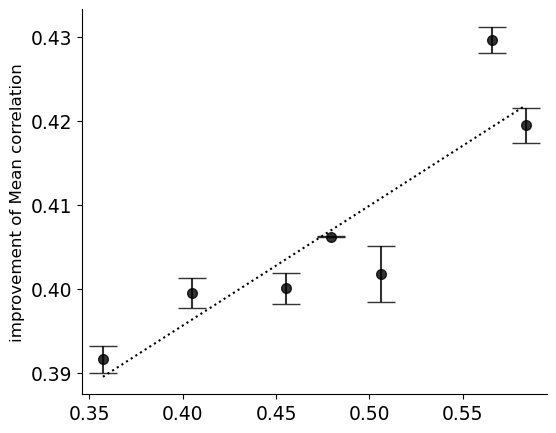

	without outlier subject: R^2=0.787338741656537, r=0.8873211040297289, p=0.0038485577840988543
student 5


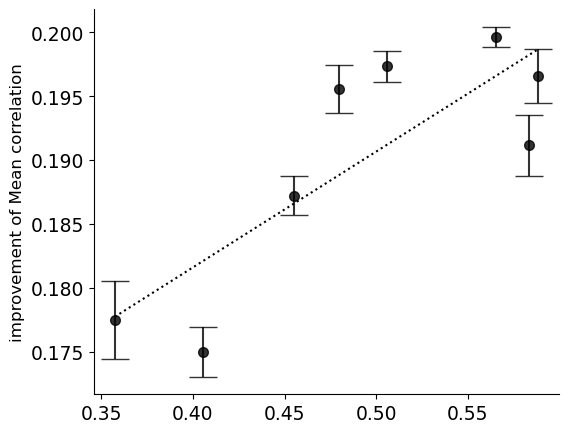

	with outlier subject: R^2=0.6770614111094765, r=0.822837414748185, p=0.006059835882977201


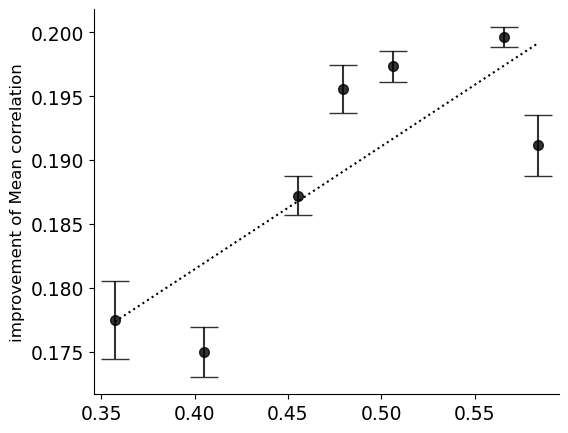

	without outlier subject: R^2=0.6596425773561951, r=0.8121838322425503, p=0.0132312075451572


In [69]:
# Indivudal students

for student in range(1,6):
    print(f"student {student}")
    for with_outlier in (True, False):

        what_to_plot = improved_encoder_mean_corr_repeats[..., student-1] if with_outlier else improved_encoder_mean_corr_repeats[..., student-1][outlier_subject_mask]
        mean_what_to_plot = what_to_plot.mean(axis=-1)
        
        x = snr_NSD if with_outlier else snr_NSD[outlier_subject_mask]
        corr_test = stats.pearsonr(x, mean_what_to_plot, alternative='greater')

        fig = set_figure()
        plot_with_err(x, what_to_plot.T, plot=False, alpha=0.8, c='k')
        x_min_max = np.array([x.min(), x.max()])
        reg_pred = corr_test.statistic * (x_min_max  - x.mean())*mean_what_to_plot.std()/x.std() + mean_what_to_plot.mean()
        plt.plot(x_min_max, reg_pred, c='k', linestyle=':')
        
        
        set_ticks_style(fig, ticksize=BIGGER_TICKSIZE)
        save_as_pdf(f"encoder_improvement_as_function_of_teacher_snr_student{student}" + "_without_annoying" * (not with_outlier))
        plt.show()
        
        print("\twith" + "out"*(not with_outlier) + f" outlier subject: R^2={corr_test.statistic**2}, r={corr_test.statistic}, p={corr_test.pvalue}")



## Figure S1c

In [70]:
enc_corr_Kn_fair_teacher = np_load('NSD_vs_GOD_same_conditions_elaborated_corr_calc_mat.npy', NEW_DATA_DIR)

In [71]:
# (kind {ref,GOD 1200,NSD 1200,NSD 7100}, repeats, statistic {mean, median, 75%, 95%), subjects, num_example {300})
enc_corr_Kn_fair_teacher.shape

(4, 3, 4, 5, 1)

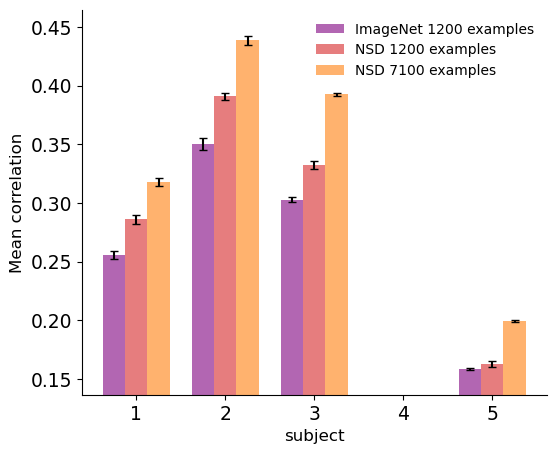

In [72]:
fair_kinds = [EncoderKinds.Baseline, 
              NameAndColor("ImageNet 1200 examples", EncoderKinds.TeacherImageNet.value.c), 
              NameAndColor("NSD 1200 examples", EncoderKinds.TeacherNSDLessExamples.value.c), 
              NameAndColor("NSD 7100 examples", EncoderKinds.TeacherNSD.value.c), 
]

fig = set_figure()
cur_width = 0.25
num_repeats = enc_corr_Kn_fair_teacher.shape[1]
for subject in np.where(subjects_mask)[0] + 1:
    for i in range(1, len(fair_kinds)):
        plot_bar_with_err(enc_corr_Kn_fair_teacher[i, :, 0, subject-1, 0], 
                          kind=fair_kinds[i], loc=subject + (i-2)*cur_width, 
                          width=cur_width, label=subject == 1)
        if num_repeats > 3:
            for j in range(i+1, len(fair_kinds)):   
                print(enc_corr_Kn_fair_teacher[j, :, 0, subject-1, 0], enc_corr_Kn_fair_teacher[i, :, 0, subject-1, 0])
                plot_significance(enc_corr_Kn_fair_teacher[j, :, 0, subject-1, 0], 
                                  enc_corr_Kn_fair_teacher[i, :, 0, subject-1, 0], 
                                  subject + cur_width*(j-2),
                                  subject + cur_width*(i-2), dist=j - i - 1)
set_legend()
if WITH_LEGEND_AND_AXES:
    plt.xlabel("subject")
    plt.ylabel(MEAN_CORRELATION)
set_ticks_style(fig, ticksize=BIGGER_TICKSIZE)
plt.ylim(bottom=enc_corr_Kn_fair_teacher[1:][..., subjects_mask, :].min())
save_as_pdf(f'Kn_mean_encoders_{exp_arr_Kn[0]}_examples_fair_comparison')

## Figure S2d

See Figure 6a

# Figure S2

In [73]:
#axis 1- first is GOD to NSD, the second is NSD to GOD
#axis2 - runs,axis3- mean,median, axis4- GOD subject, axis5- NSD subject, axis 6- one dimension correpsonding to all examples for both subjects
across_ds_corr_calc_mat = np_load("Transformations_Across_datasets_corr_calc_mat", NEW_DATA_DIR)

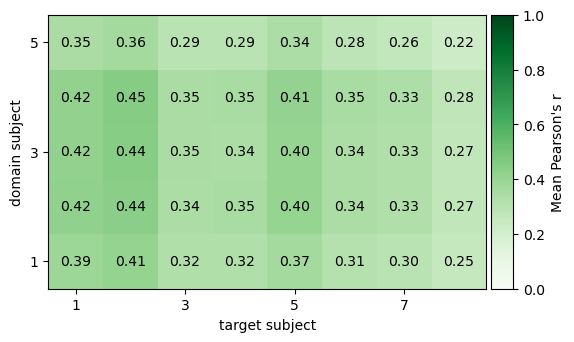

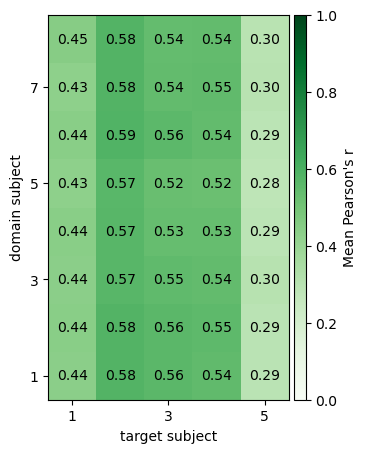

In [74]:
for i in range(2):
    cur = across_ds_corr_calc_mat[i, :, 0, ..., 0].mean(axis=0)
    if i:
        cur = cur.T
    heatmap_individual(mat=cur, is_diff=False, cbar_label="Mean Pearson's r", ranges=True)
    save_as_pdf(name=f'transformations_across_datasets_{"GOD_to_NSD" if not i else "NSD_to_GOD"}')

# Figure S3

See Figure 4b

# Figure S4

In [75]:
def plot_single_example_NSD_transformations_new(dfs, other_baselines={}, fsaverage=False, examples=None, save=True,
                                                example_num=0, s1s=s1s4, s2s=s2s4, with_ns=False, with_only_ns=True, ylim=None):
    mask_shared = dfs.shared > 0
    shared = np.max(dfs.shared)
    fig = set_figure()
    other_baselines[TransfKinds.S] = (shared, dfs.test_corr[0][example_num])
    xticks = []
    for kind, (shared_cur, v) in sorted(other_baselines.items(), key=lambda x: x[1][0], reverse=True):
        if kind == TransfKinds.Anatomical:
            continue
        plt.axhline(v, 0, np.max(dfs.non_shared), color=kind.value.c, linestyle=':', label=f'{shared_cur} shared' if kind != TransfKinds.Anatomical else 'anatomical', linewidth=4)    
    if with_ns:
        plt.plot(dfs.shared[mask_shared] + dfs.non_shared[mask_shared], 
                 get_df_from_dfs(dfs, 'test_corr', mask_shared, example_num), c=TransfKinds.S_NS_E.value.c,
                 label=f'{shared} shared+non-shared', marker='.', markersize=10, alpha=0.8)
        xticks.append(dfs.shared[mask_shared] + dfs.non_shared[mask_shared])
    if with_only_ns:
        plt.plot(dfs.shared[~mask_shared] + dfs.non_shared[~mask_shared], 
             get_df_from_dfs(dfs, 'test_corr', ~mask_shared, example_num), 
             c=TransfKinds.NS_E.value.c, label='only non-shared', marker='.', markersize=10, alpha=0.8)
        xticks.append(dfs.shared[~mask_shared] + dfs.non_shared[~mask_shared])
    if TransfKinds.Anatomical in other_baselines:
        kind, (shared_cur, v) = TransfKinds.Anatomical, other_baselines[TransfKinds.Anatomical]
        plt.axhline(v, 0, np.max(dfs.non_shared), color=kind.value.c, linestyle=':', label=f'{shared_cur} shared' if kind != TransfKinds.Anatomical else 'anatomical', linewidth=4)    
    set_legend()
    if ylim is not None:
        plt.ylim(ylim)
    plt.xticks(np.unique(np.concatenate(xticks)))
    if WITH_LEGEND_AND_AXES:
        plt.xlabel(X_LABEL_NS_EXPS)
        plt.ylabel(MEAN_CORRELATION)
    set_ticks_style(fig)
    if save:
        save_as_pdf(f'NSD_transf_single_example_{s1s[example_num]}to{s2s[example_num]}_new' + (f'_{examples}s' if examples else '') + '_fsaverage'*fsaverage)    

subject 1 to 2


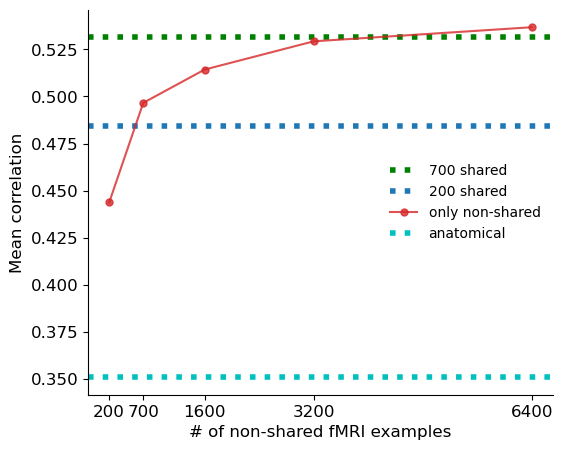

subject 1 to 3


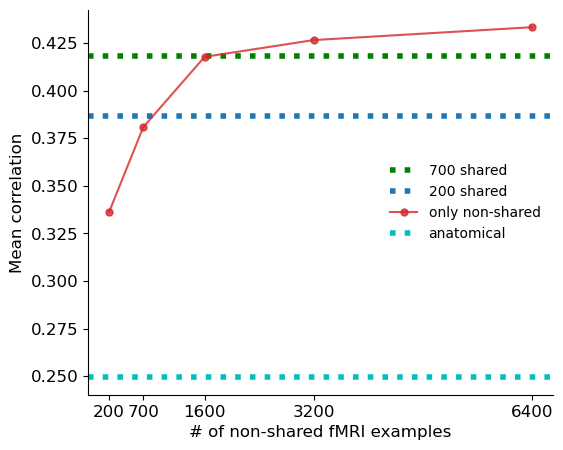

subject 1 to 4


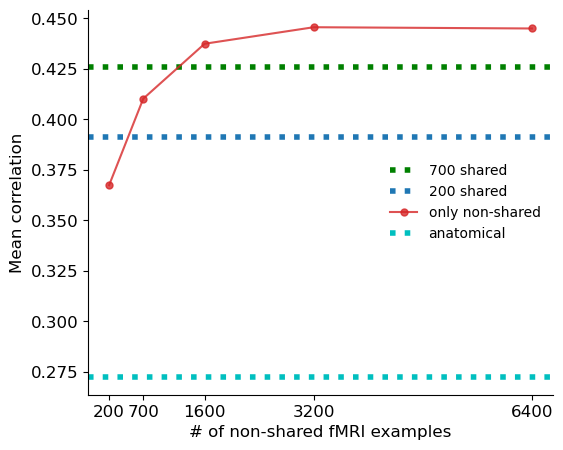

subject 1 to 5


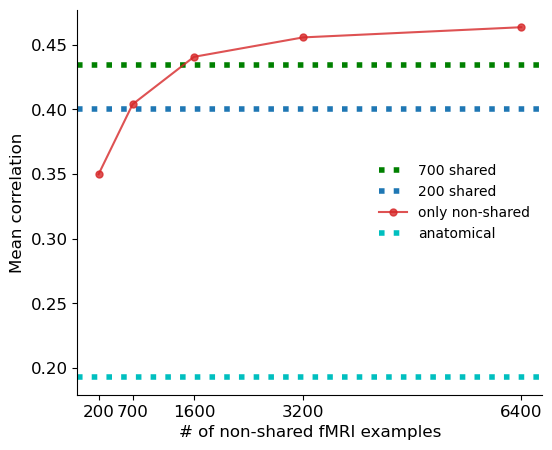

subject 1 to 6


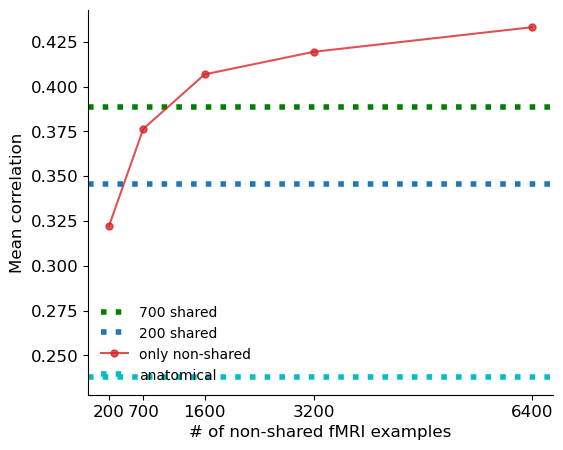

subject 1 to 7


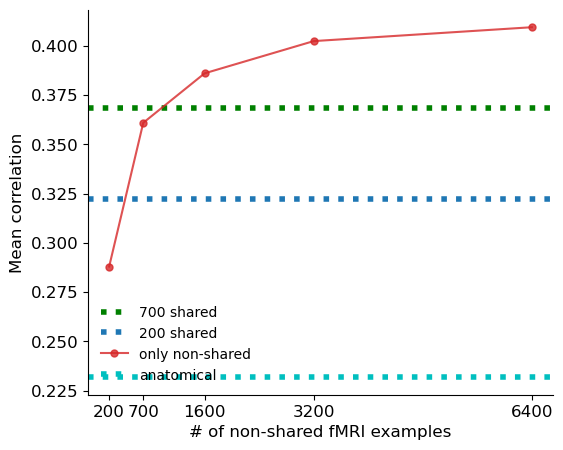

subject 1 to 8


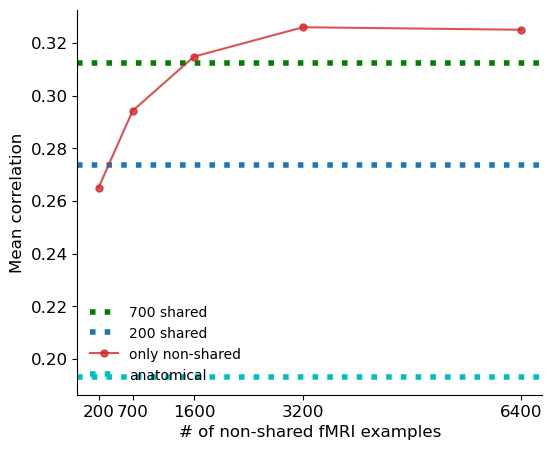

subject 2 to 1


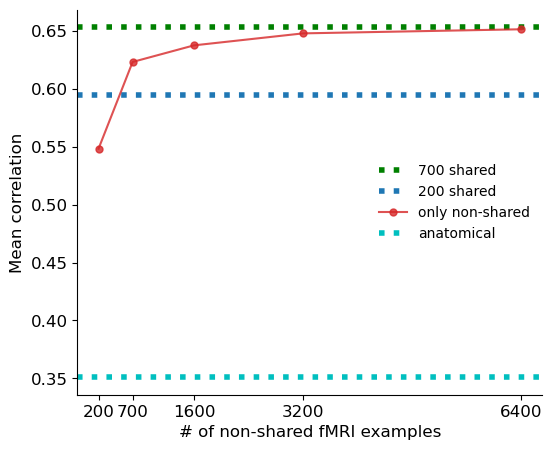

subject 2 to 3


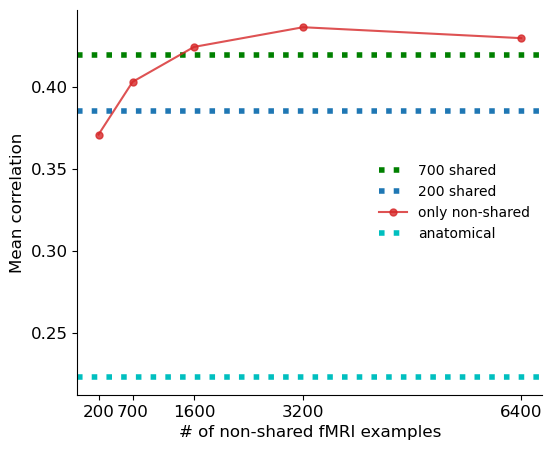

subject 2 to 4


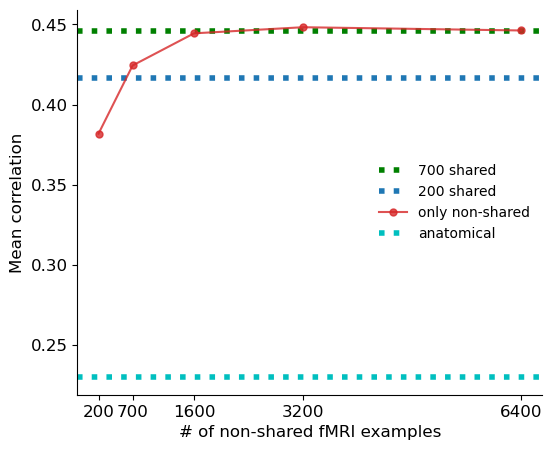

subject 2 to 5


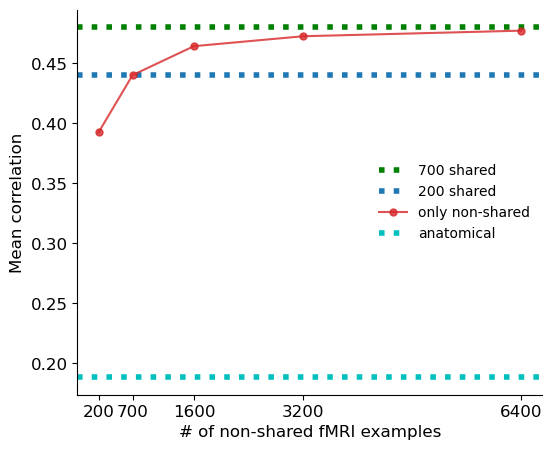

subject 2 to 6


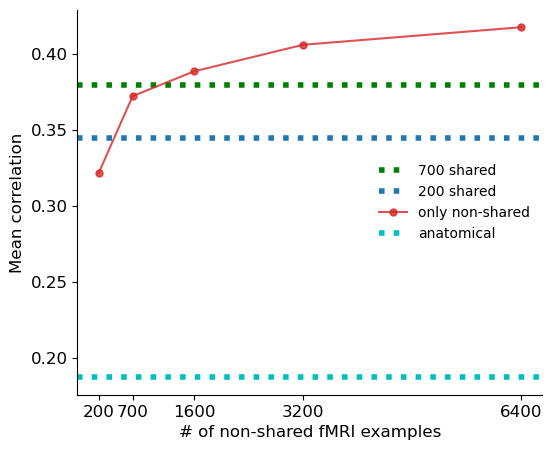

subject 2 to 7


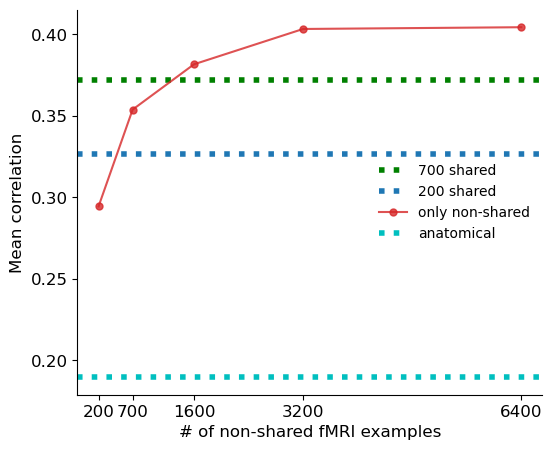

subject 2 to 8


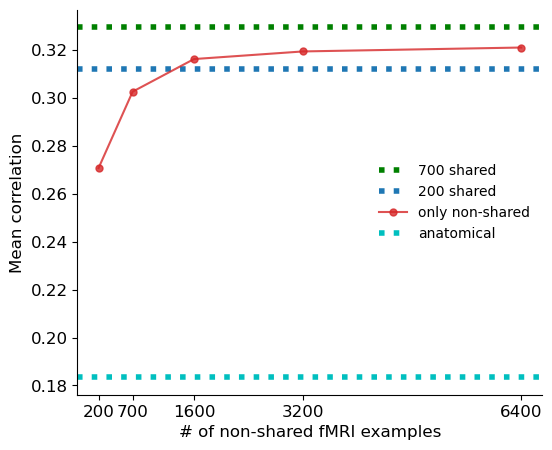

subject 3 to 1


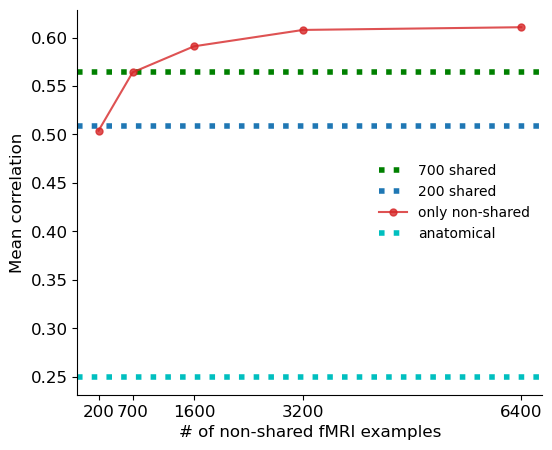

subject 3 to 2


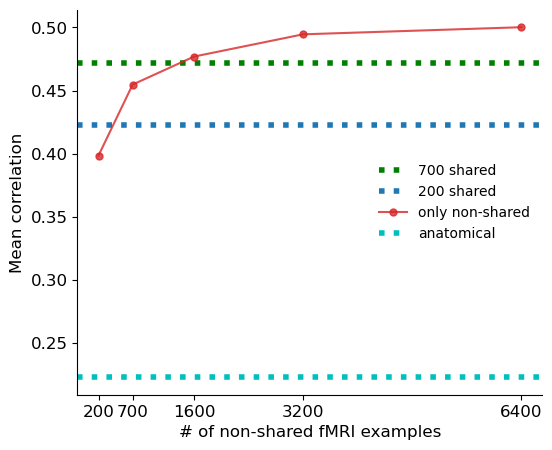

subject 3 to 4


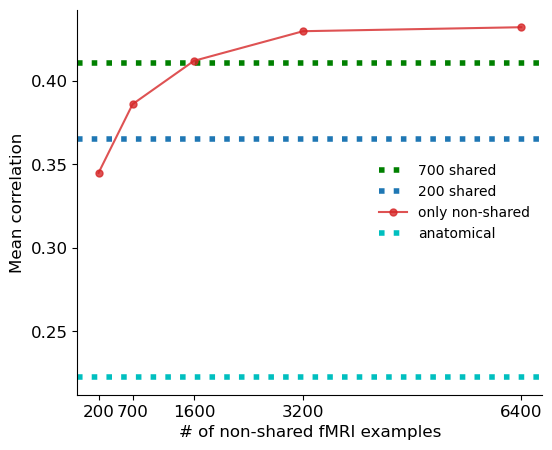

subject 3 to 5


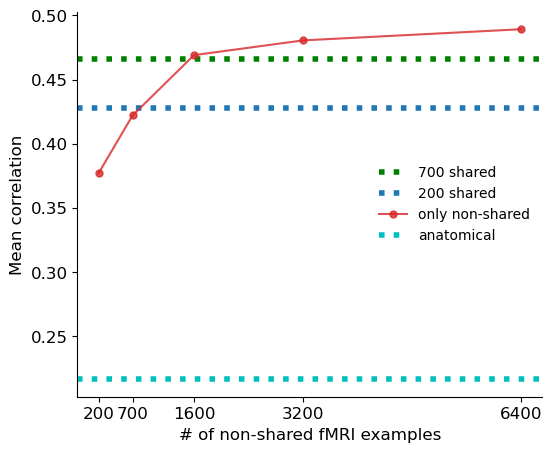

subject 3 to 6


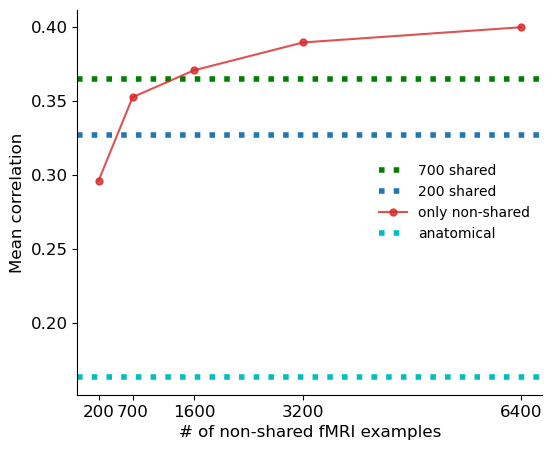

subject 3 to 7


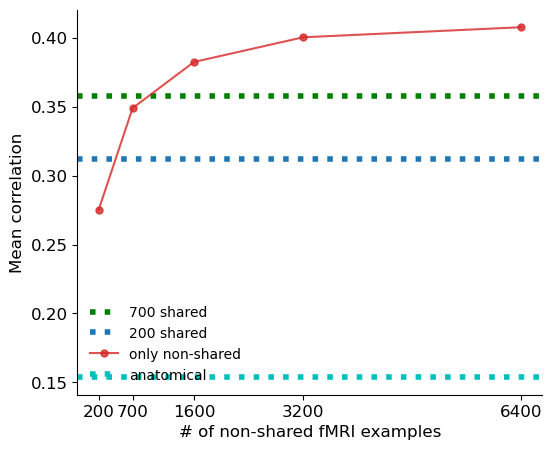

subject 3 to 8


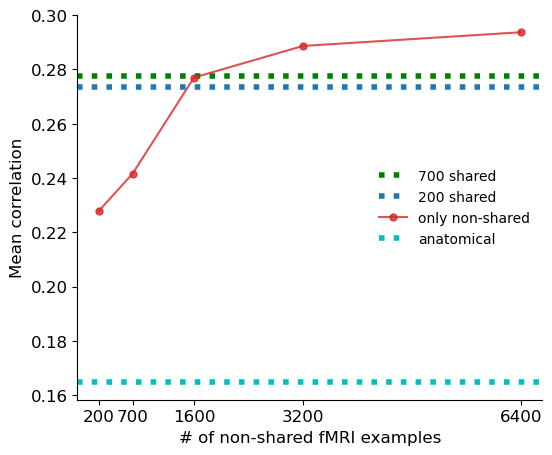

subject 4 to 1


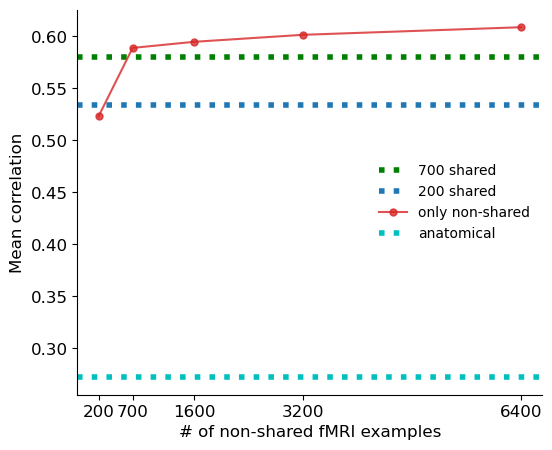

subject 4 to 2


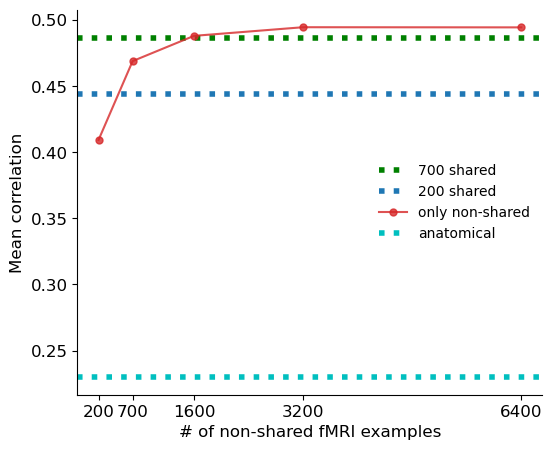

subject 4 to 3


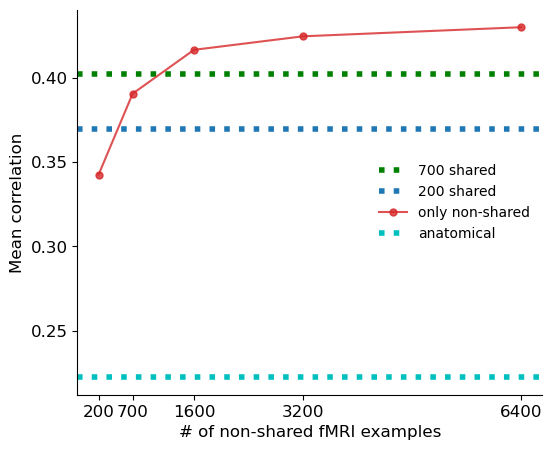

subject 4 to 5


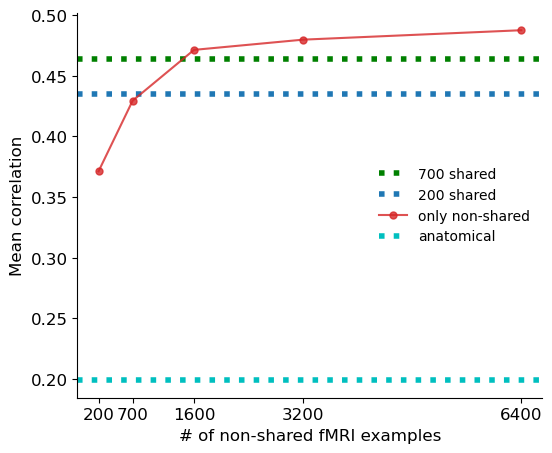

subject 4 to 6


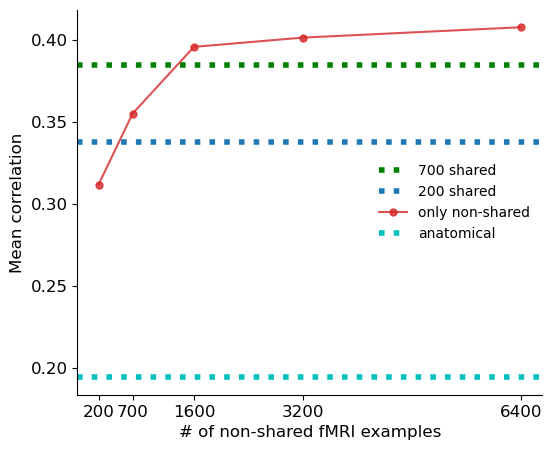

subject 4 to 7


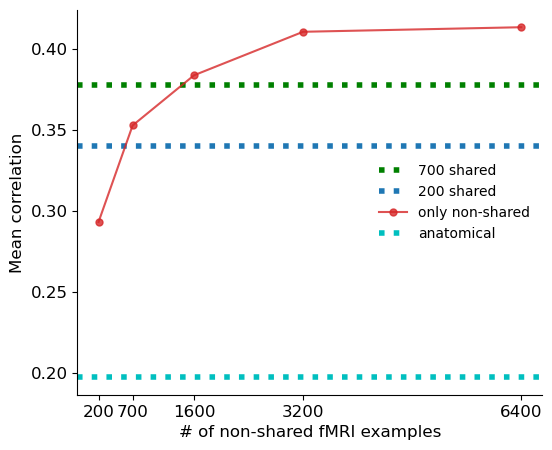

subject 4 to 8


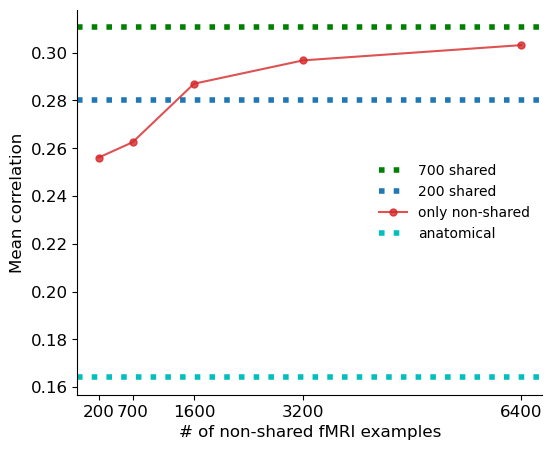

subject 5 to 1


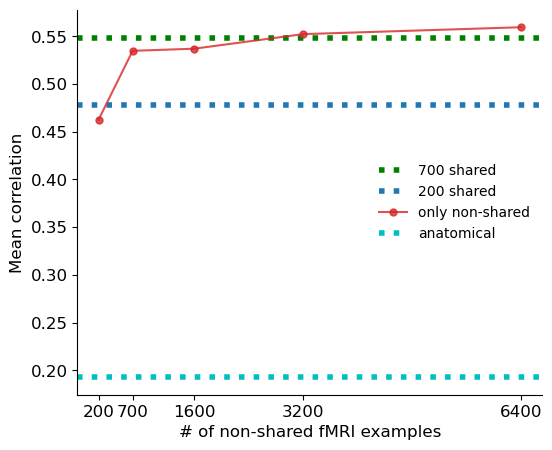

subject 5 to 2


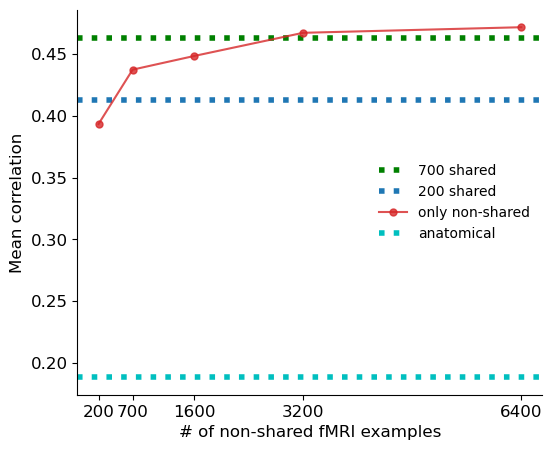

subject 5 to 3


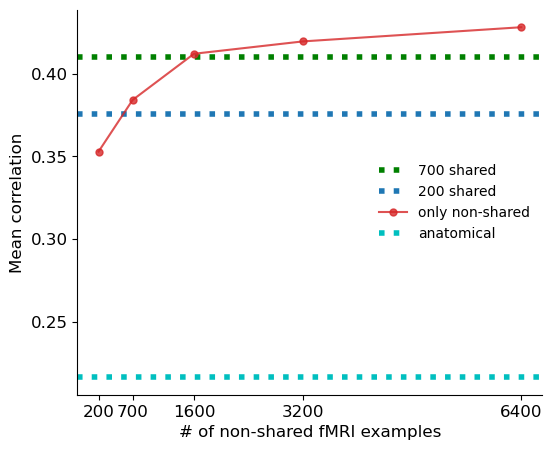

subject 5 to 4


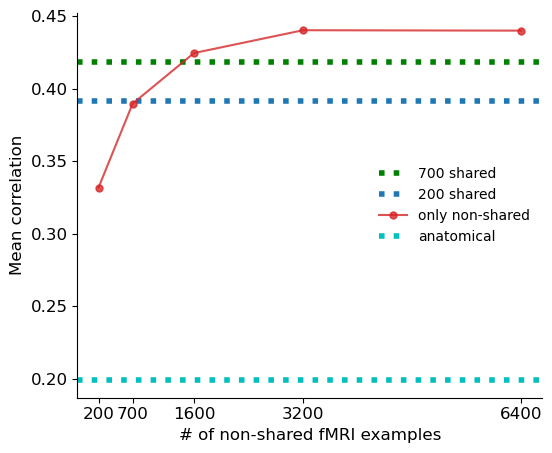

subject 5 to 6


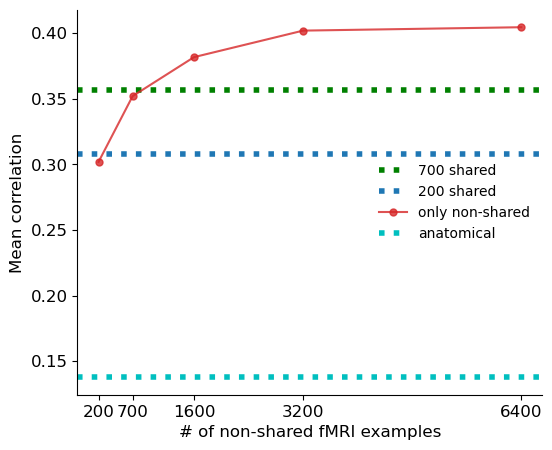

subject 5 to 7


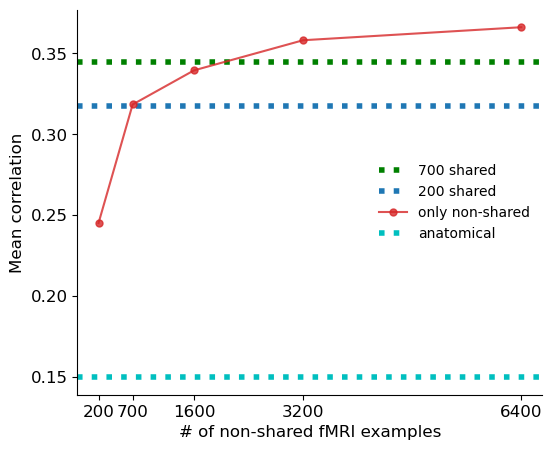

subject 5 to 8


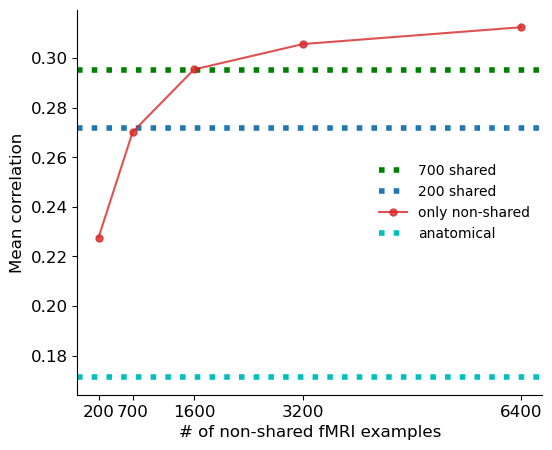

subject 6 to 1


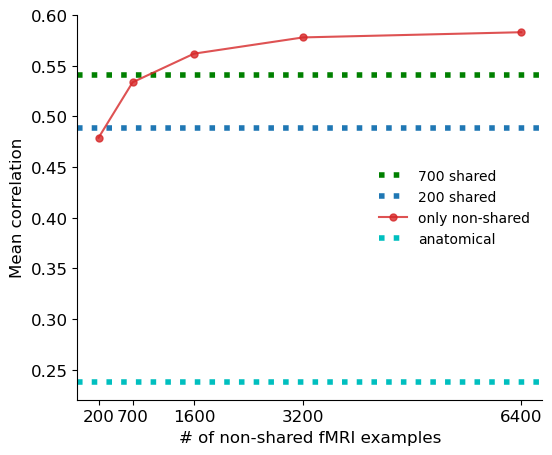

subject 6 to 2


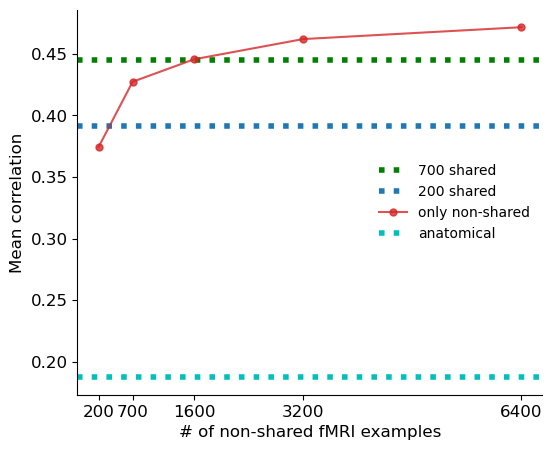

subject 6 to 3


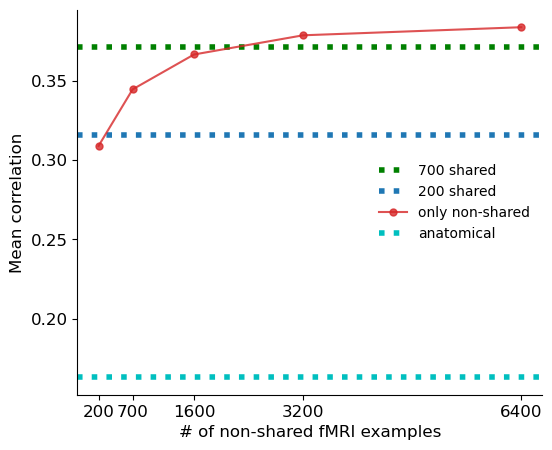

subject 6 to 4


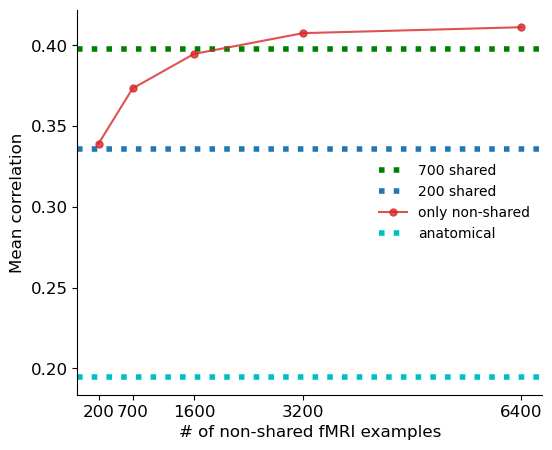

subject 6 to 5


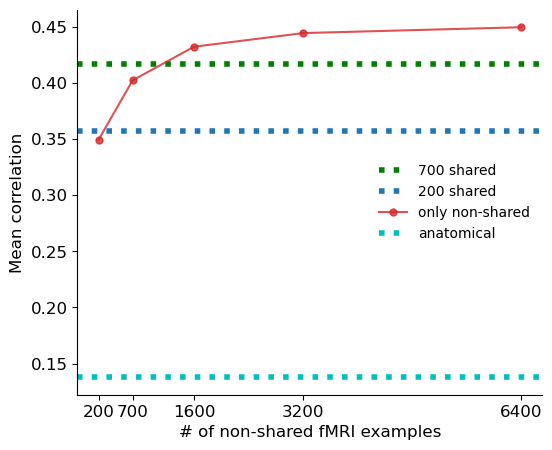

subject 6 to 7


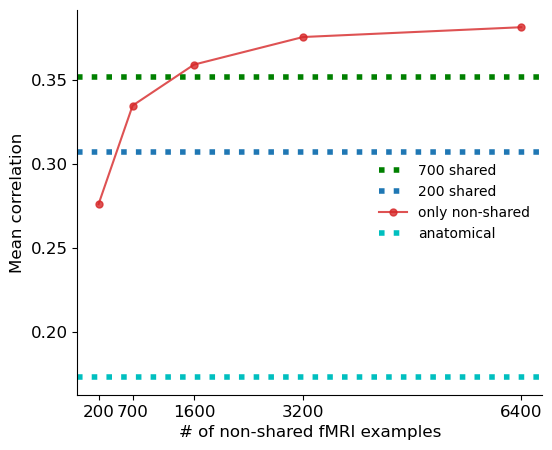

subject 6 to 8


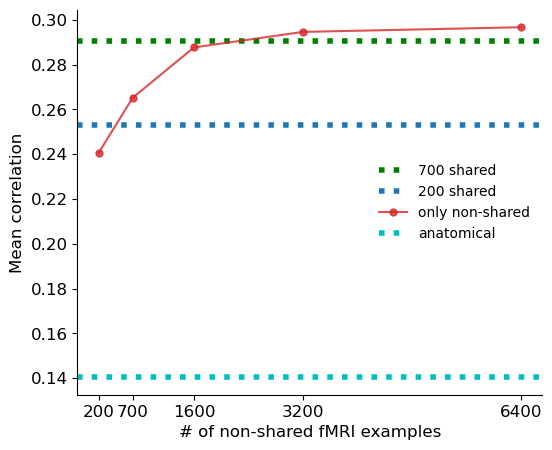

subject 7 to 1


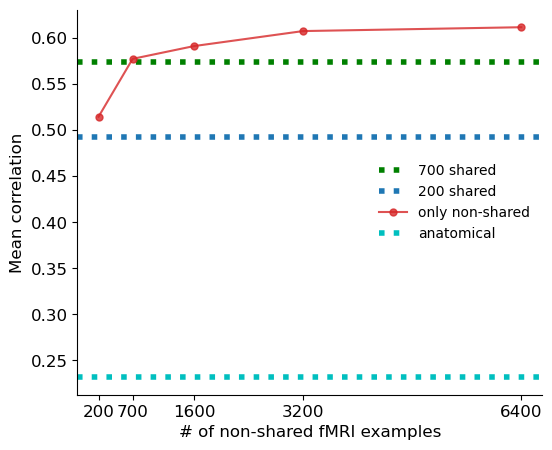

subject 7 to 2


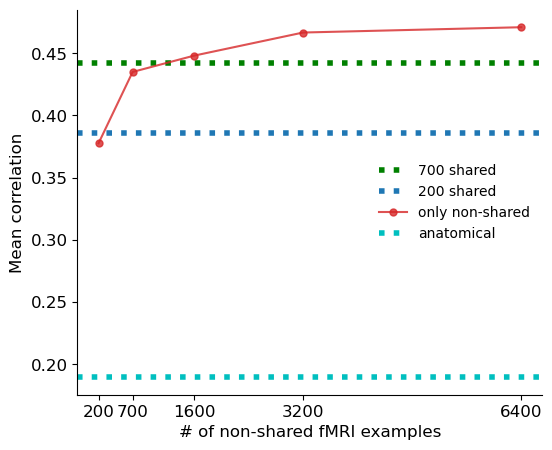

subject 7 to 3


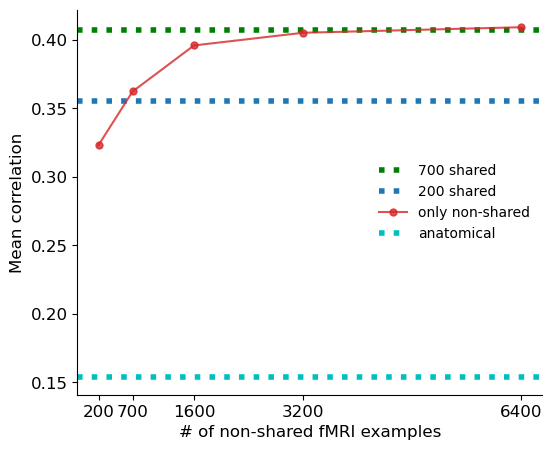

subject 7 to 4


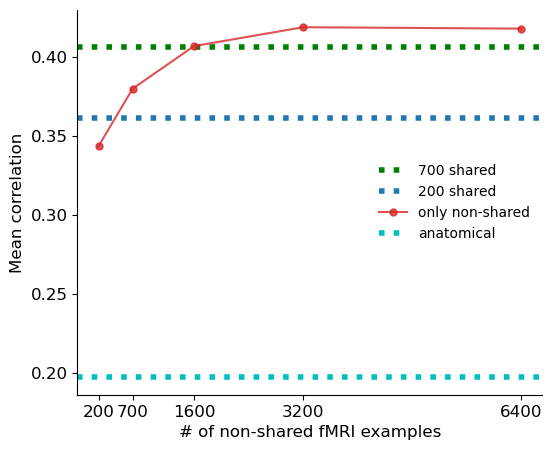

subject 7 to 5


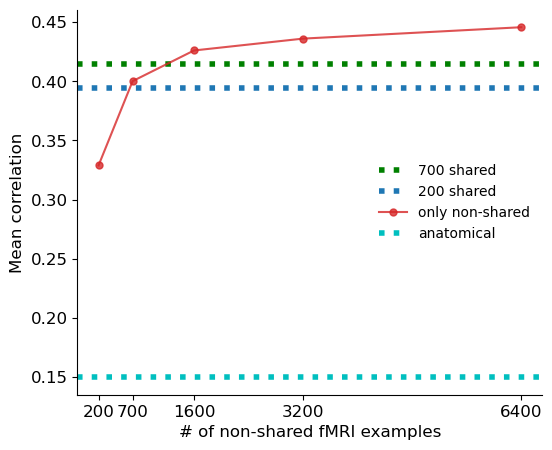

subject 7 to 6


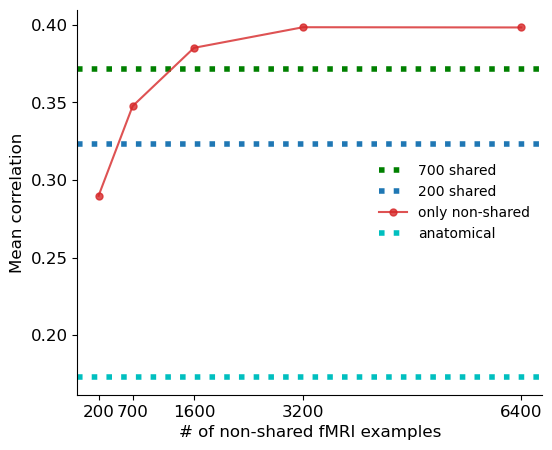

subject 7 to 8


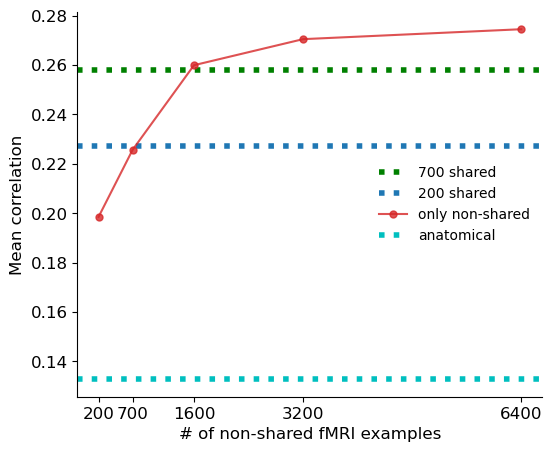

subject 8 to 1


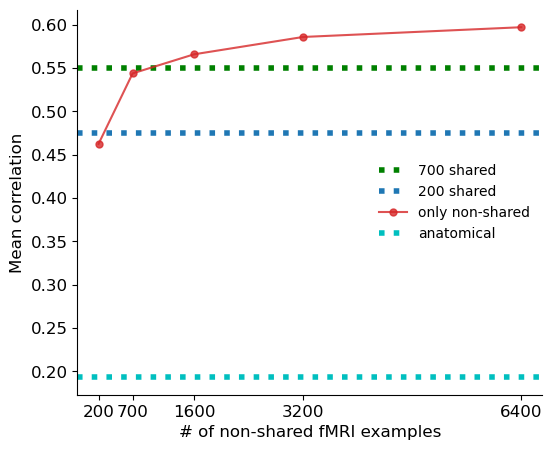

subject 8 to 2


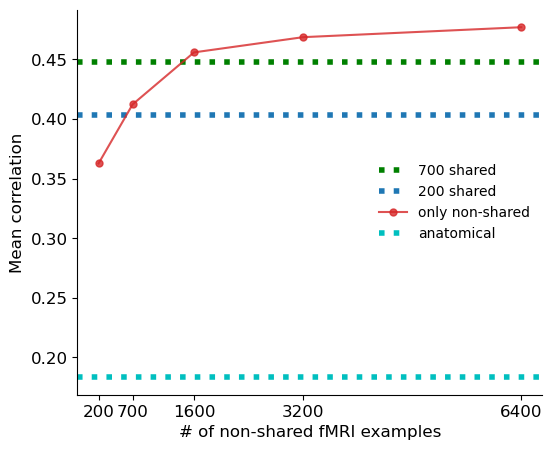

subject 8 to 3


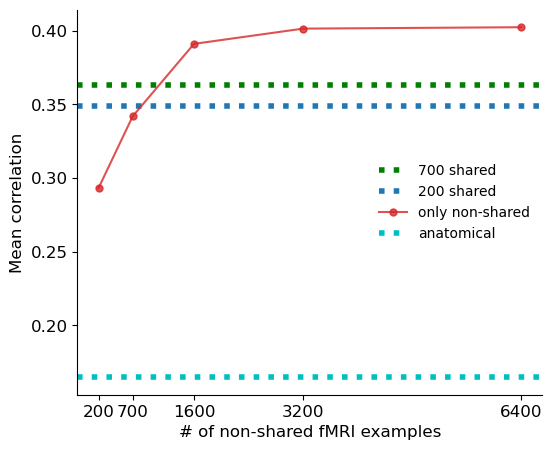

subject 8 to 4


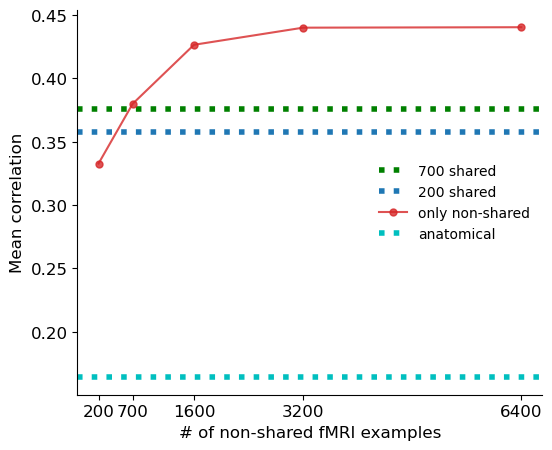

subject 8 to 5


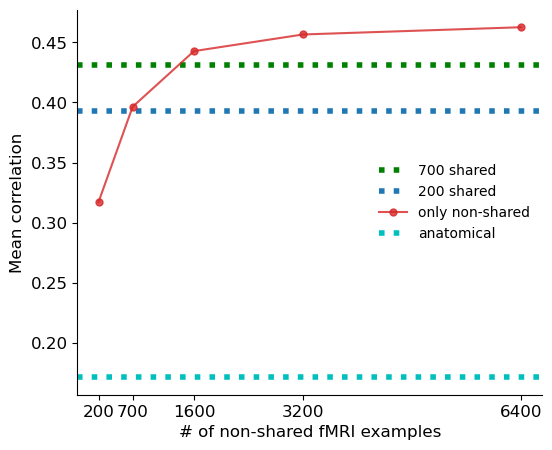

subject 8 to 6


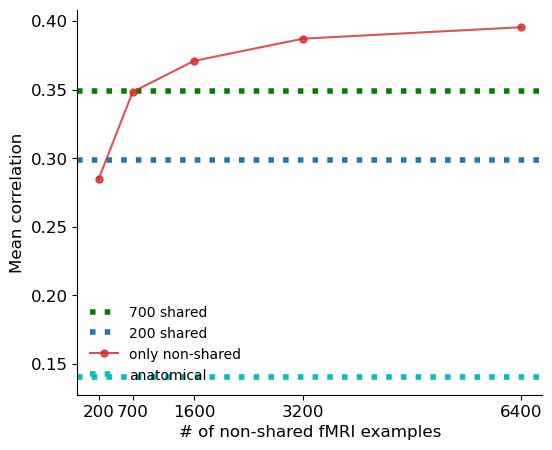

subject 8 to 7


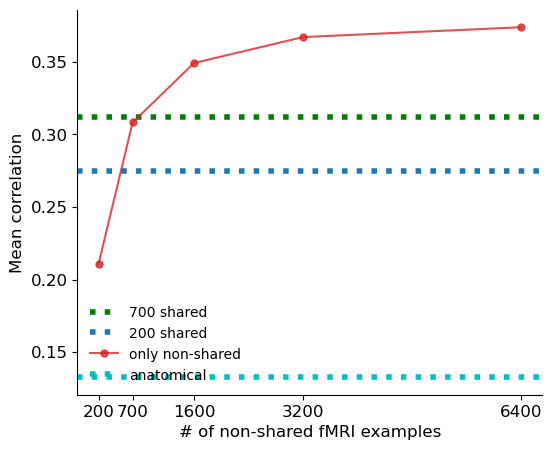

In [76]:
df4_ylim = df4_fsaverage.test_corr.apply(lambda arr: arr.min()).min(), df4_fsaverage.test_corr.apply(lambda arr: arr.max()).max()
df6_ylim = df6_fsaverage.test_corr[0].min(), df6_fsaverage.test_corr[0].max()
anatomical_ylim = np.nanmin(NSD_transf_anatomical_corr_calc_mat[0]), np.nanmax(NSD_transf_anatomical_corr_calc_mat[0])
ylim = min(df4_ylim[0], df6_ylim[0], anatomical_ylim[0]), max(df4_ylim[1], df6_ylim[1], anatomical_ylim[1]) if SHAREY else None
for i in range(s1s4.size):
    dct = {TransfKinds.S_Small: (200, df6_fsaverage.test_corr[0][np.logical_and(s1s6_fsaverage == s1s4_fsaverage[i], s2s6_fsaverage == s2s4_fsaverage[i])]),
          TransfKinds.Anatomical: (0, NSD_transf_anatomical_corr_calc_mat[0][s1s4_fsaverage-1, s2s4_fsaverage-1][i])}
    print("subject", s1s4[i], "to", s2s4[i])
    plot_single_example_NSD_transformations_new(df4_fsaverage, example_num=i, other_baselines=dct, 
                                                s1s=s1s4_fsaverage, s2s=s2s4_fsaverage, fsaverage=True, ylim=ylim if SHAREY else None)
    plt.show()

# Figure S5

## Figure S5a

/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


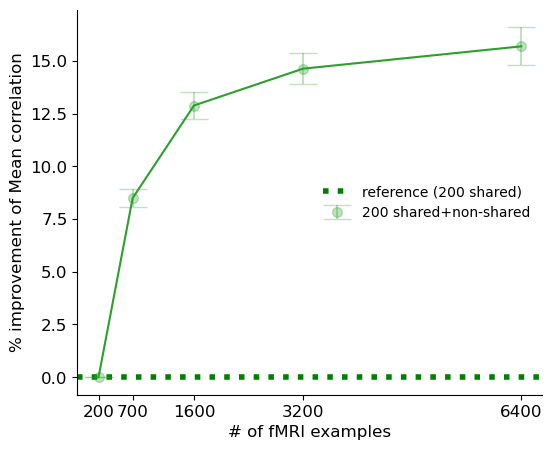

In [77]:
save_name = 'transf_NSD_plot_diff_example_shared_200'
plot_how_the_amount_non_shared_examples_affect_transformations(df6, percents=True, with_only_ns=False,
                                                               calc_delta=True, save_name=save_name, xlabel=X_LABEL_EXPS)

## Figure S5b-d (and the remaining subjects)

subject 1 to 2


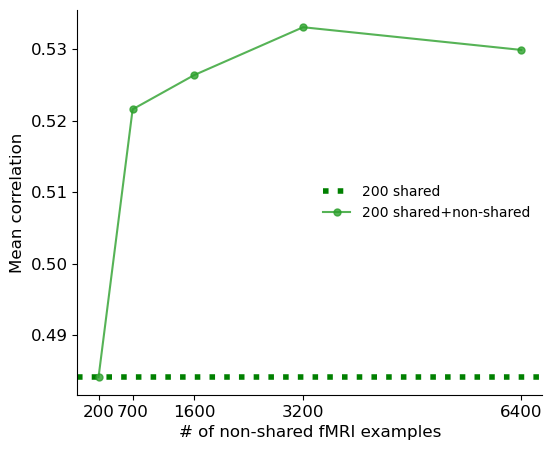

subject 1 to 3


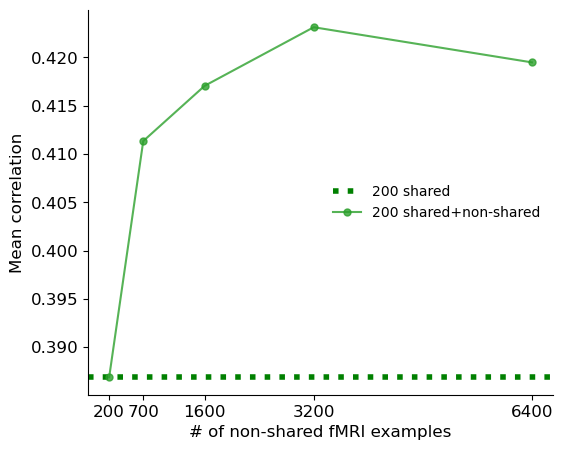

subject 1 to 4


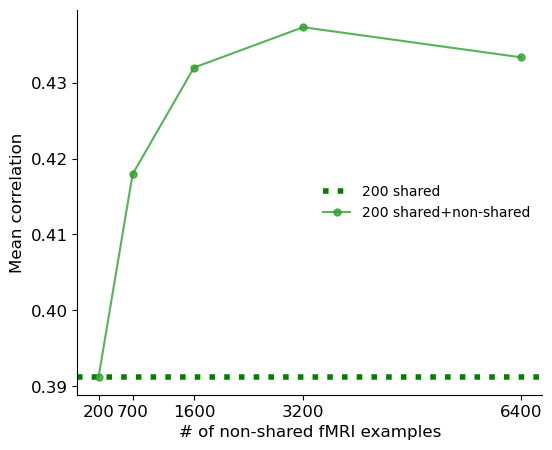

subject 1 to 5


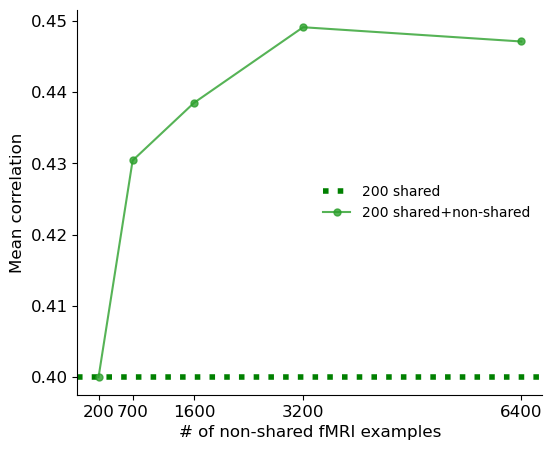

subject 1 to 6


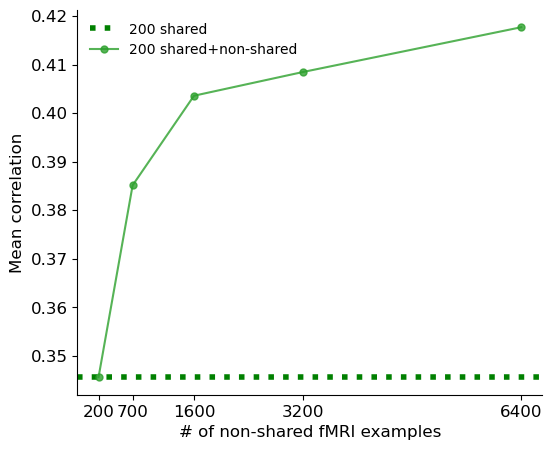

subject 1 to 7


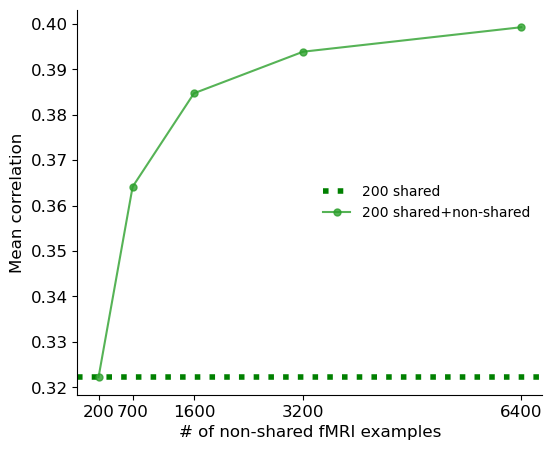

subject 1 to 8


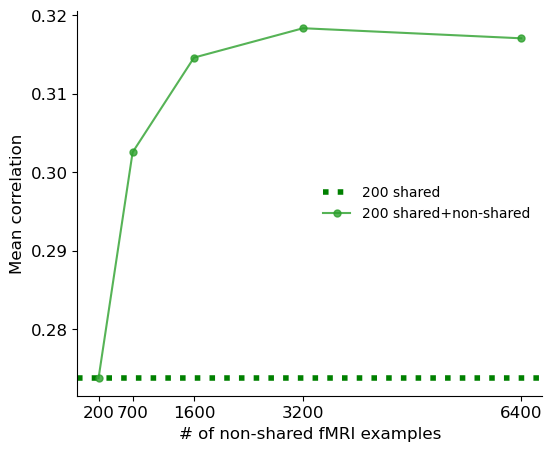

subject 2 to 1


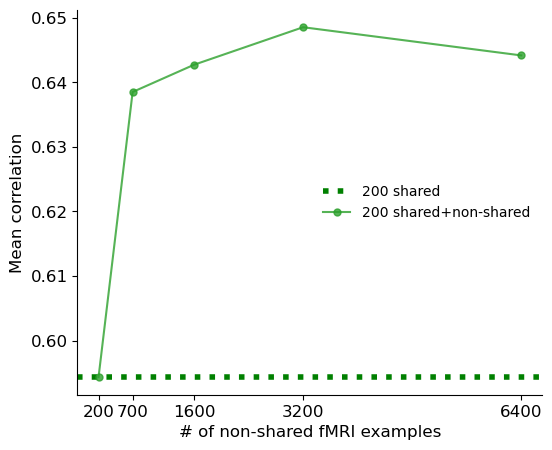

subject 2 to 3


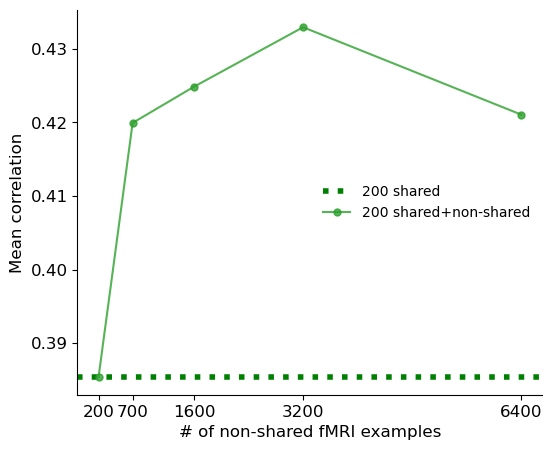

subject 2 to 4


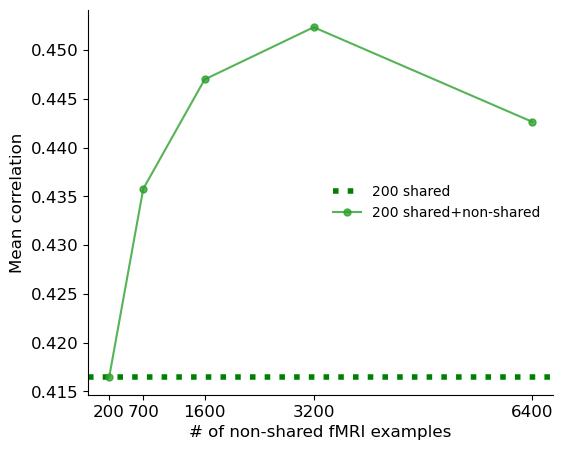

subject 2 to 5


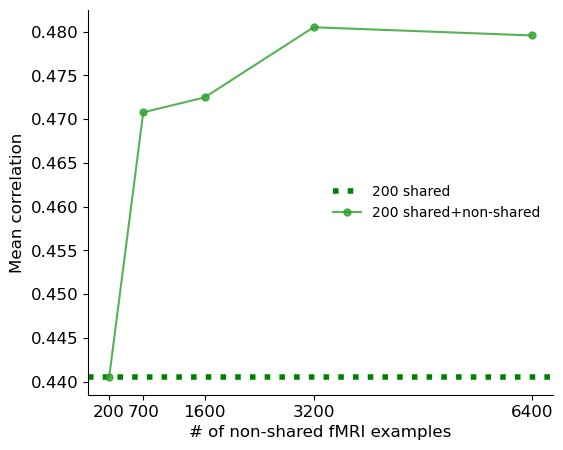

subject 2 to 6


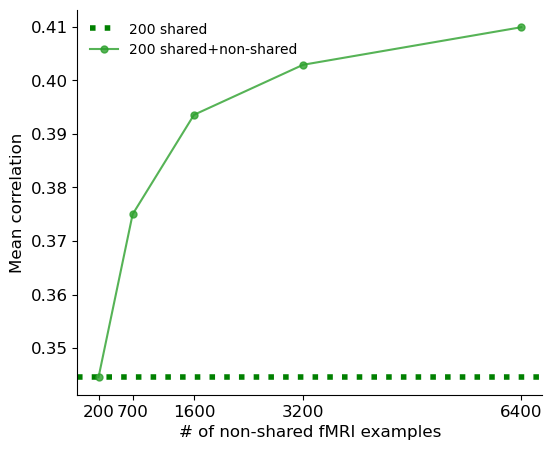

subject 2 to 7


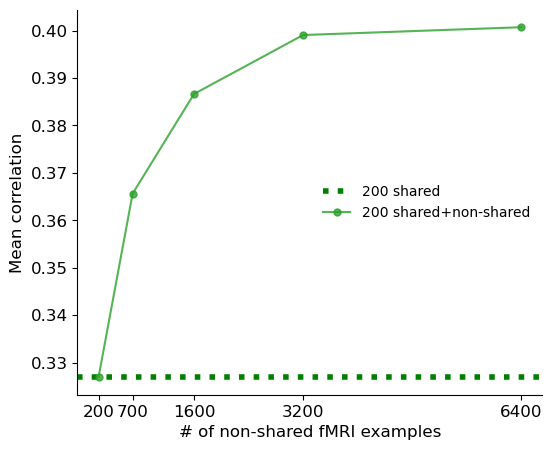

subject 2 to 8


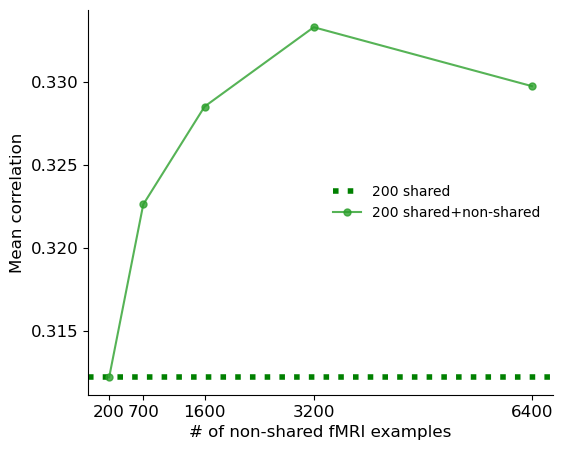

subject 3 to 1


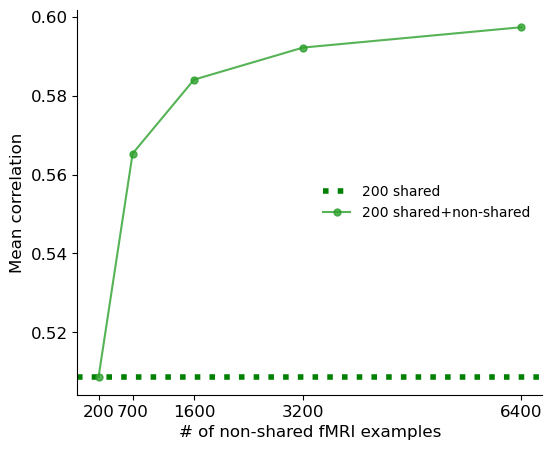

subject 3 to 2


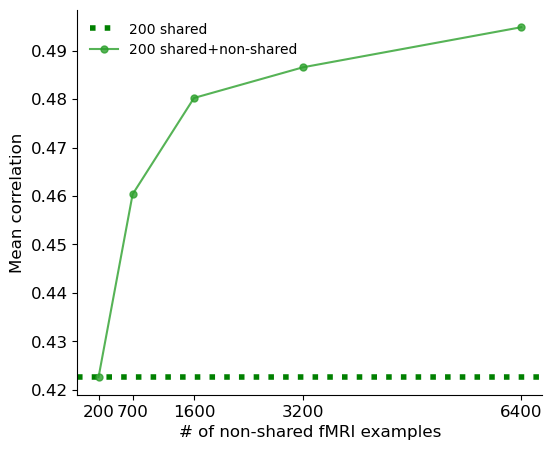

subject 3 to 4


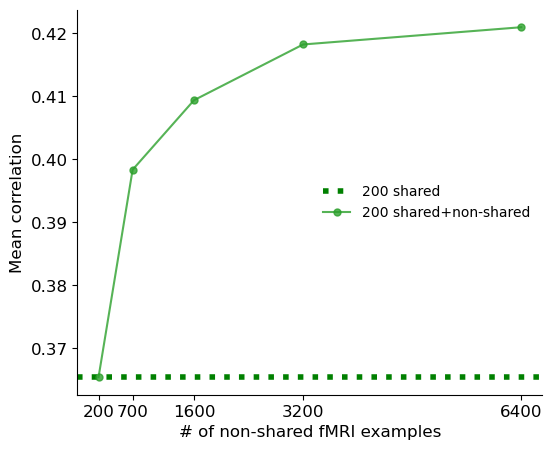

subject 3 to 5


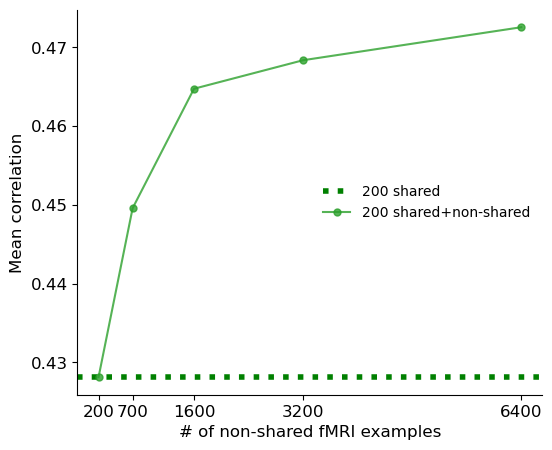

subject 3 to 6


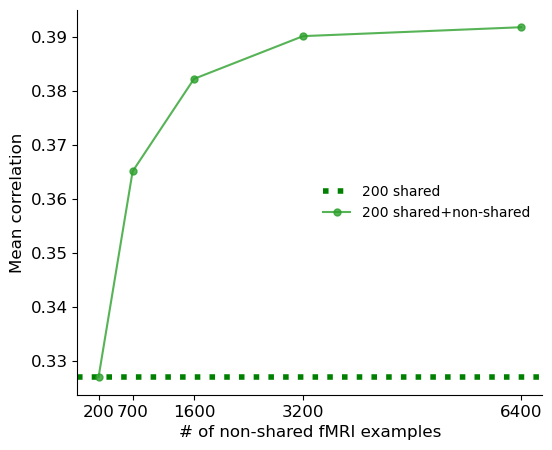

subject 3 to 7


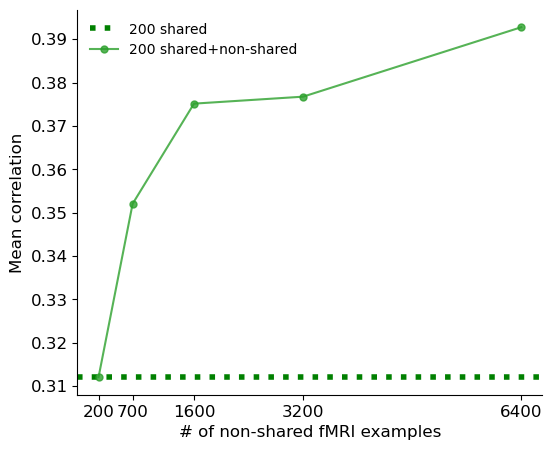

subject 3 to 8


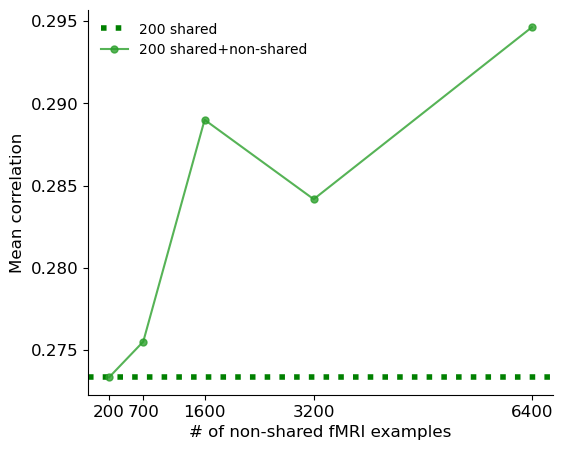

subject 4 to 1


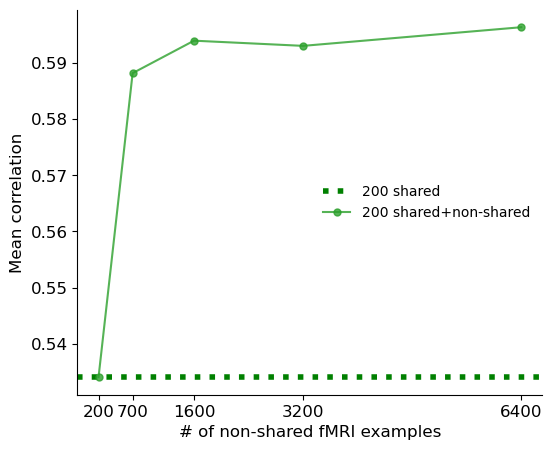

subject 4 to 2


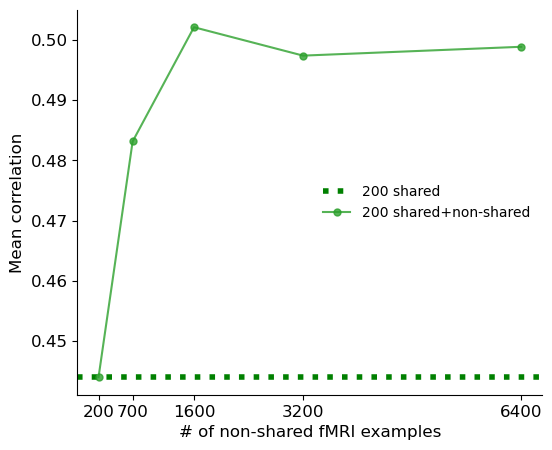

subject 4 to 3


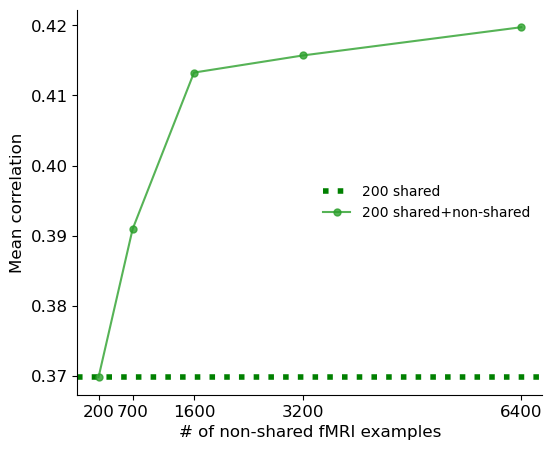

subject 4 to 5


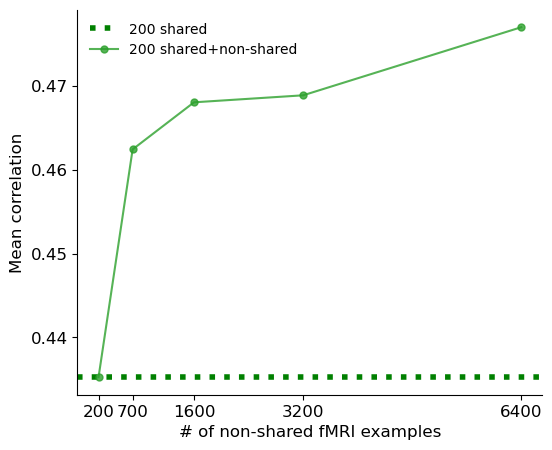

subject 4 to 6


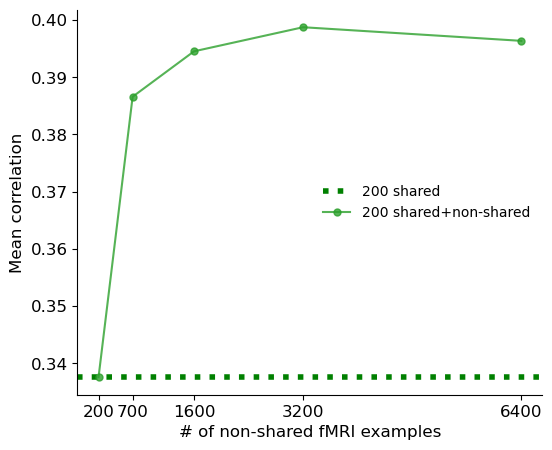

subject 4 to 7


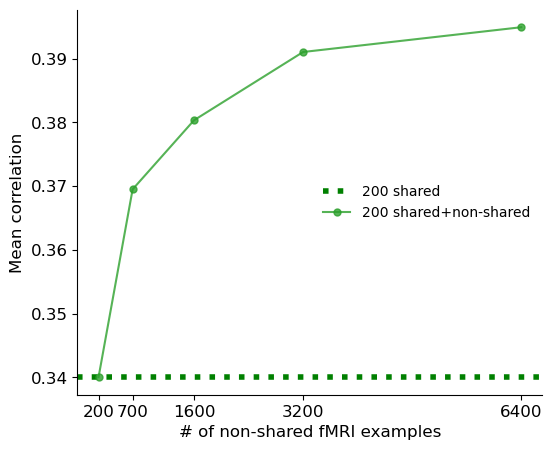

subject 4 to 8


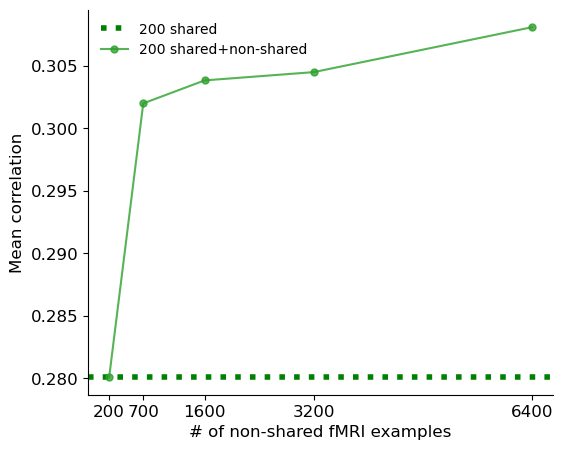

subject 5 to 1


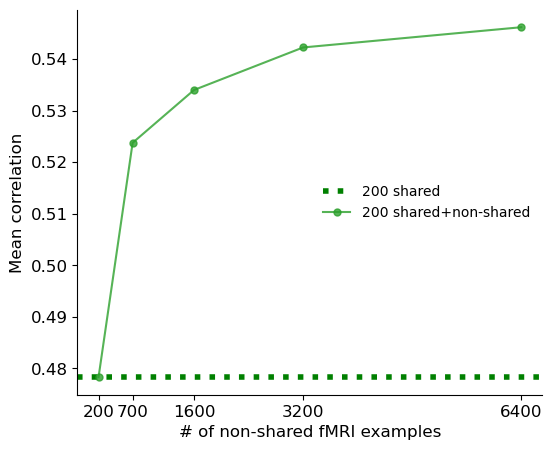

subject 5 to 2


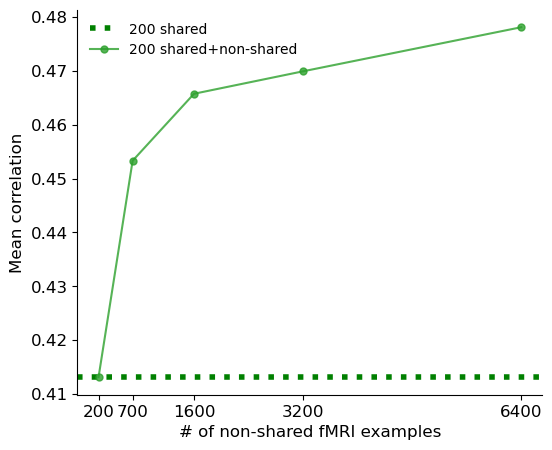

subject 5 to 3


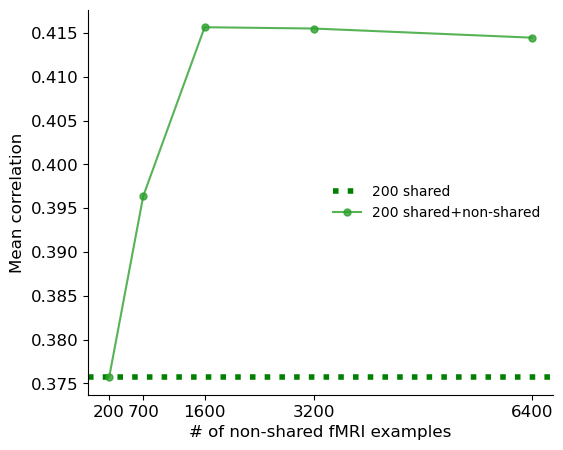

subject 5 to 4


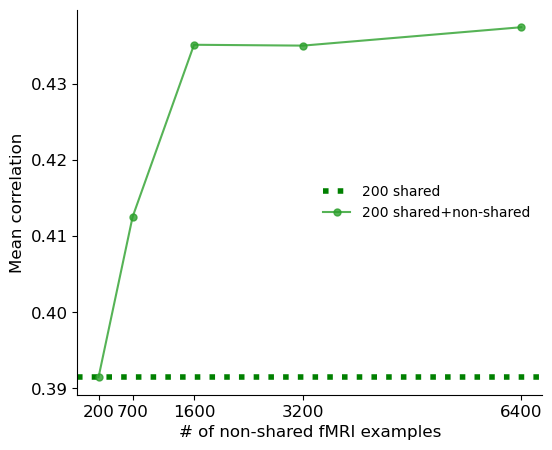

subject 5 to 6


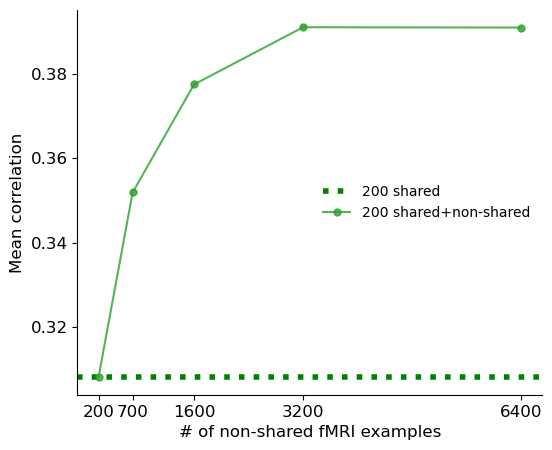

subject 5 to 7


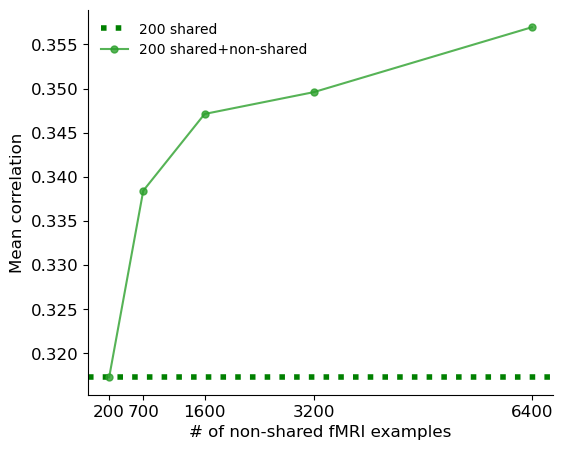

subject 5 to 8


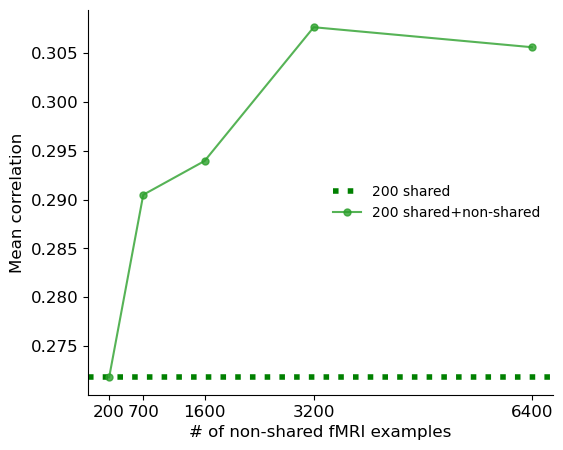

subject 6 to 1


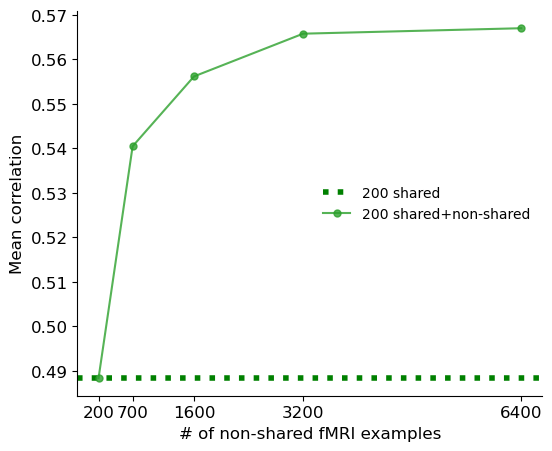

subject 6 to 2


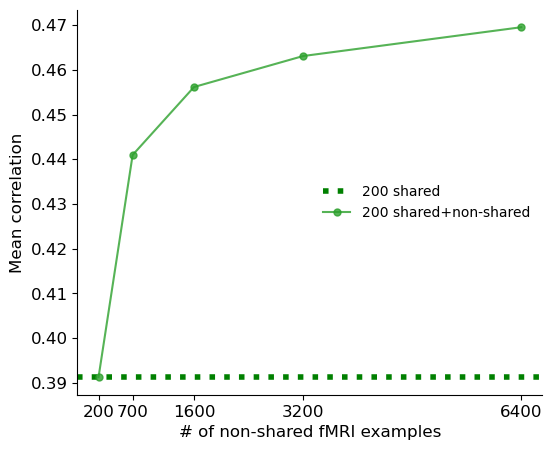

subject 6 to 3


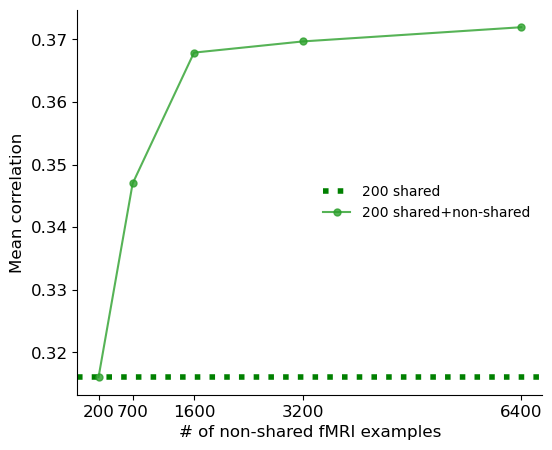

subject 6 to 4


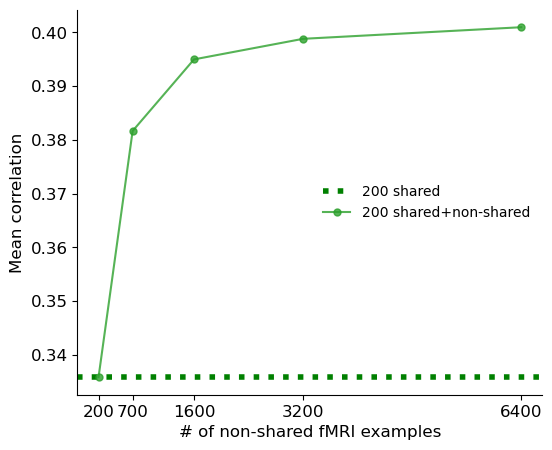

subject 6 to 5


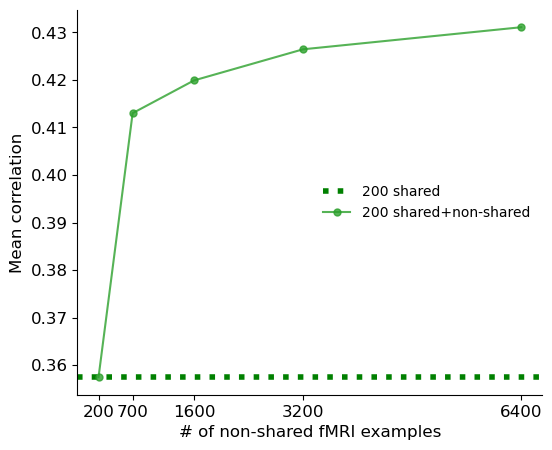

subject 6 to 7


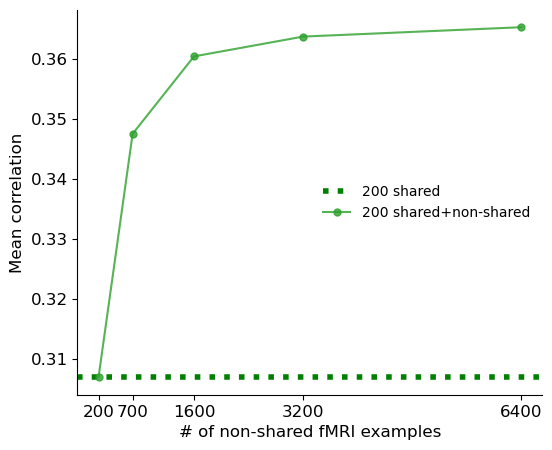

subject 6 to 8


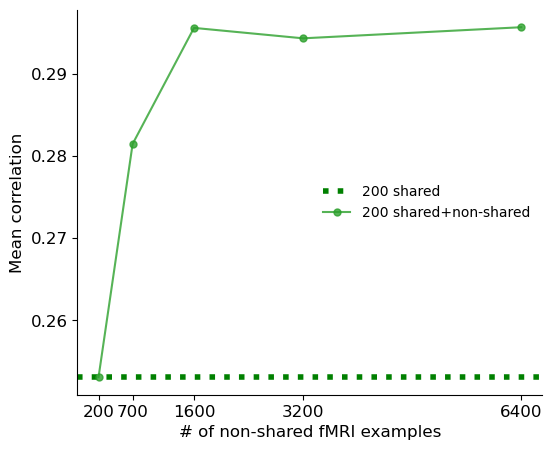

subject 7 to 1


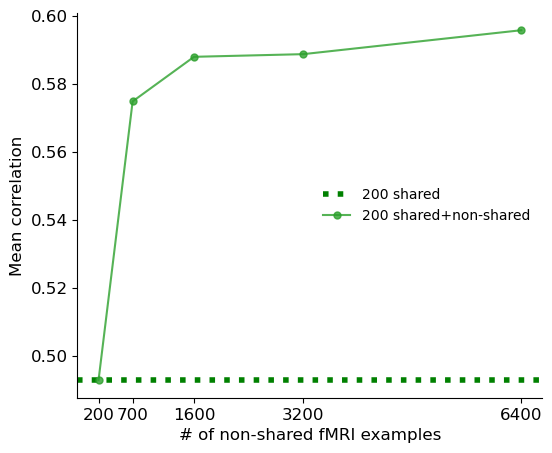

subject 7 to 2


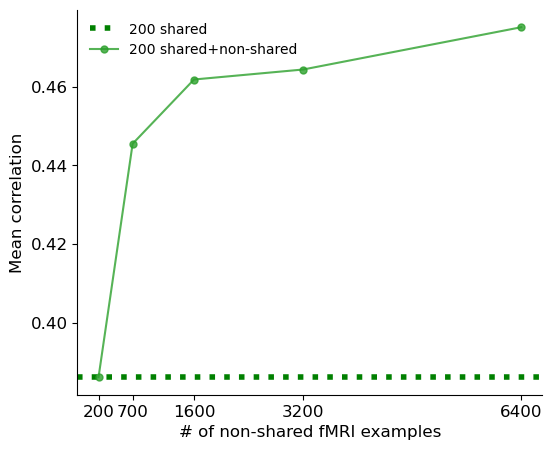

subject 7 to 3


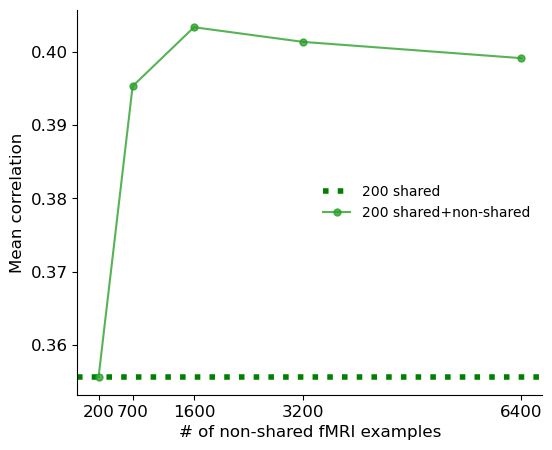

subject 7 to 4


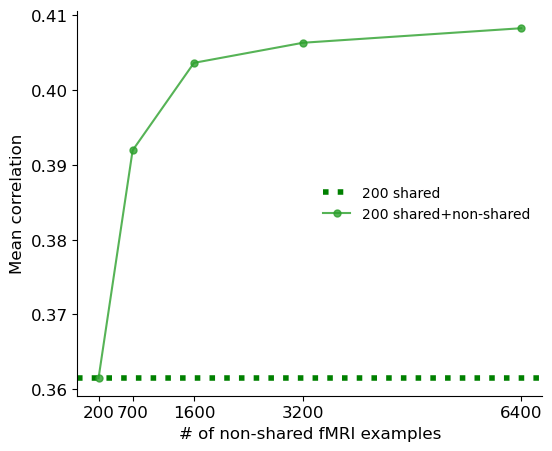

subject 7 to 5


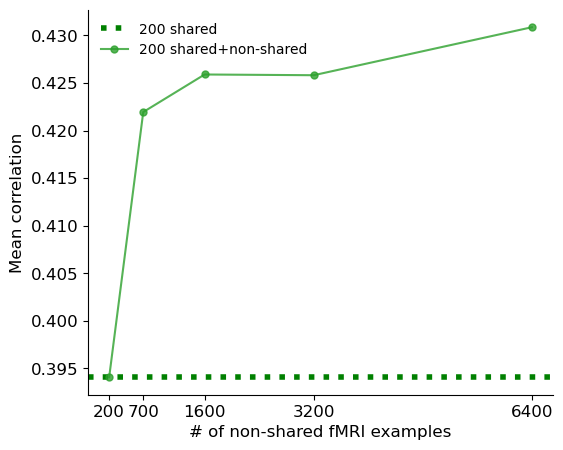

subject 7 to 6


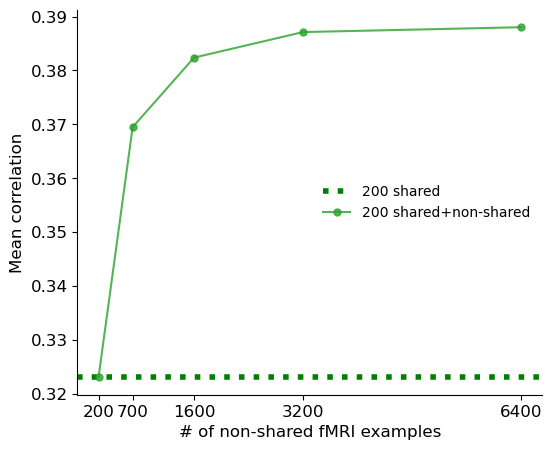

subject 7 to 8


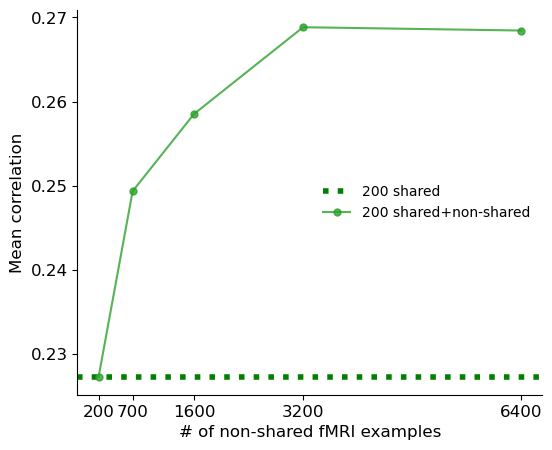

subject 8 to 1


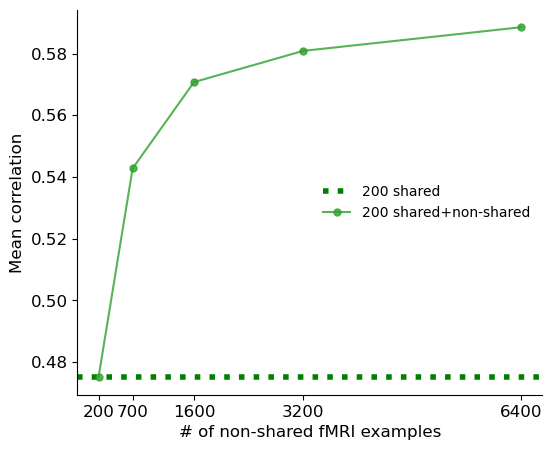

subject 8 to 2


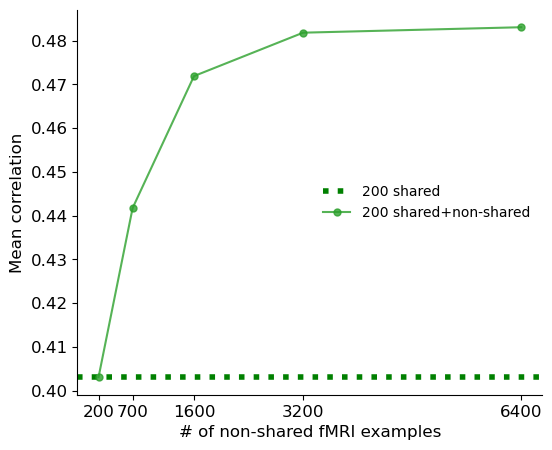

subject 8 to 3


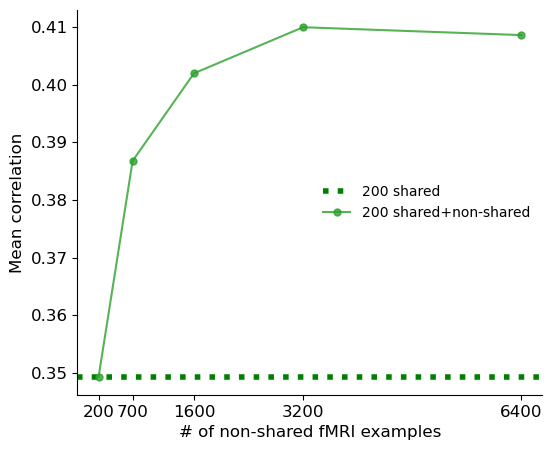

subject 8 to 4


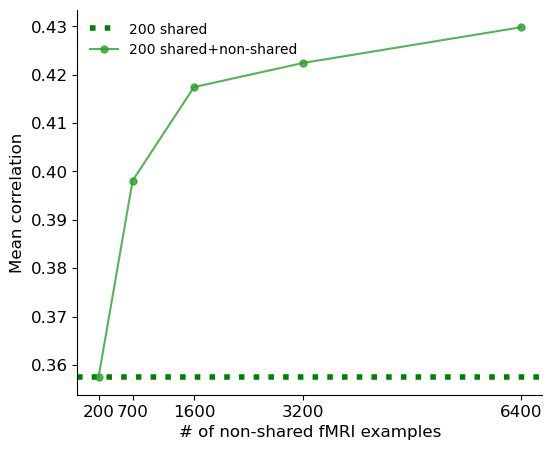

subject 8 to 5


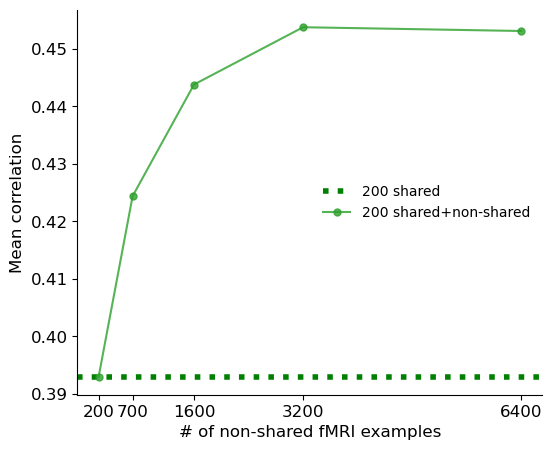

subject 8 to 6


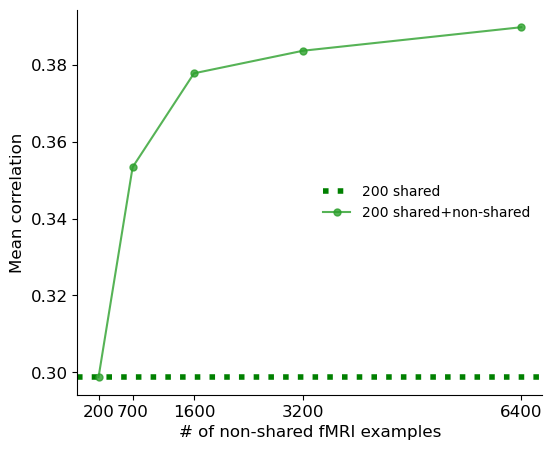

subject 8 to 7


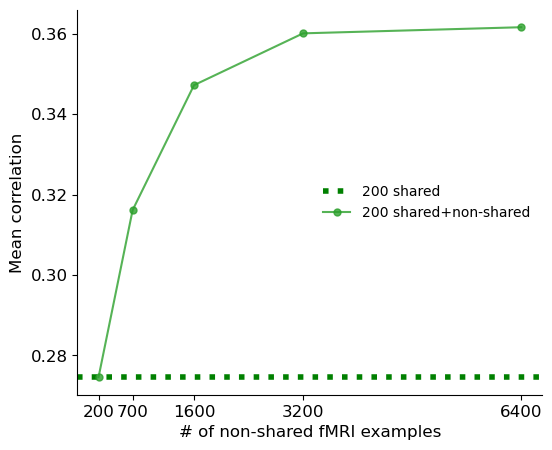

In [78]:
examples = 200
ylim = [f(df6_fsaverage[df6_fsaverage.shared == examples].test_corr.apply(lambda x: f(x))) for f in (np.nanmin, np.nanmax)]
for i in range(s1s4.size):
    print("subject", s1s4[i], "to", s2s4[i])
    plot_single_example_NSD_transformations_new(df6_fsaverage, example_num=i, save=True,
                                                s1s=s1s6_fsaverage, s2s=s2s6_fsaverage, examples=examples,
                                                fsaverage=True, with_only_ns=False, with_ns=True, ylim=ylim if SHAREY else None)
    plt.show()

# Figure S6

## Figure S6a

/tmp/ipykernel_156676/178157320.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x, y.mean(axis=0), err_plot, alpha=alpha, color=c, marker='o',


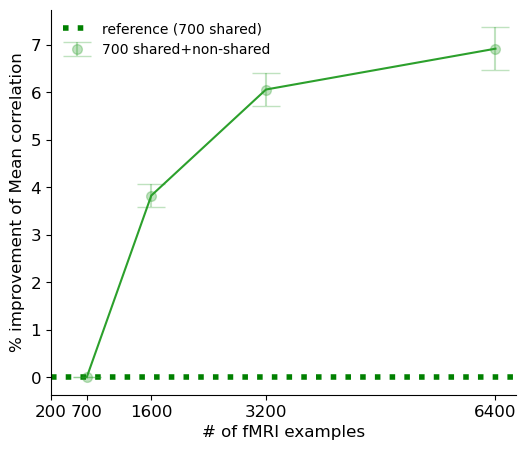

In [79]:
plot_how_the_amount_non_shared_examples_affect_transformations(df4, percents=True, with_only_ns=False,
                                                               calc_delta=True, save_name='transf_NSD_plot_diff_example_shared_700', 
                                                               xlabel=X_LABEL_EXPS)

## Figure S6b-d (and the remaining subjects)

subject 1 to 2


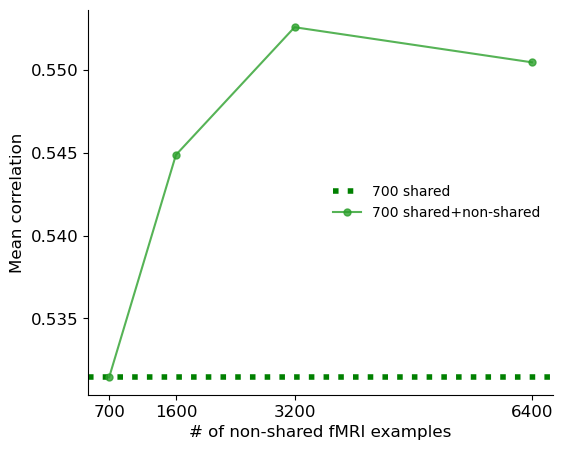

subject 1 to 3


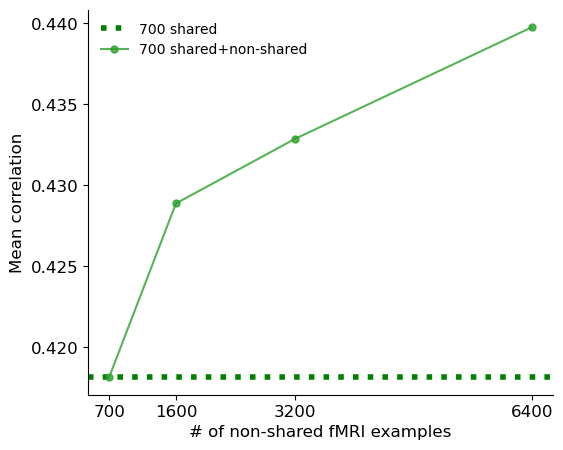

subject 1 to 4


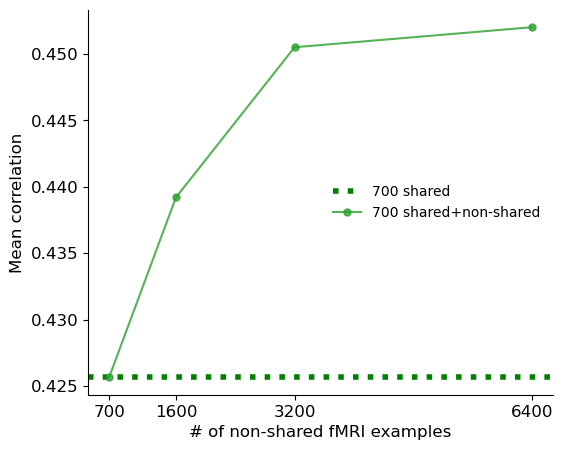

subject 1 to 5


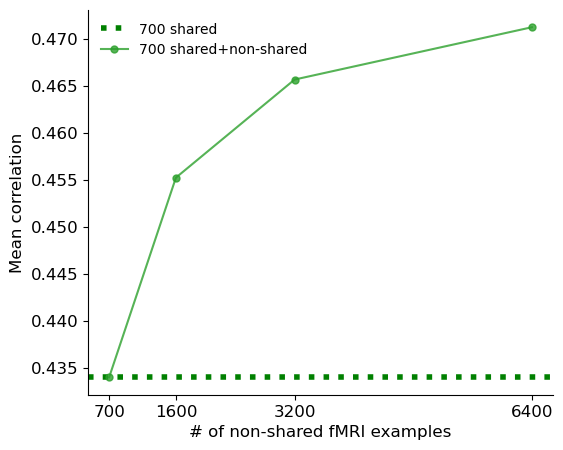

subject 1 to 6


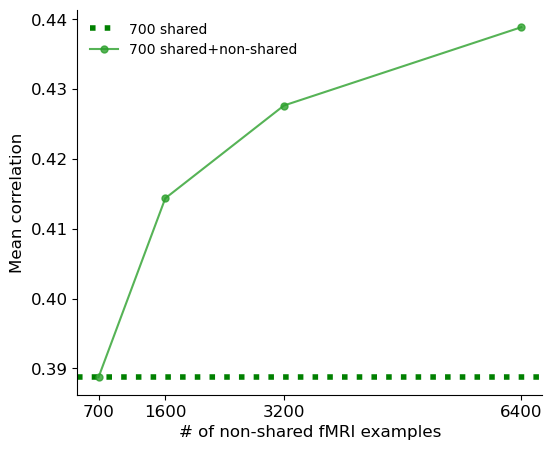

subject 1 to 7


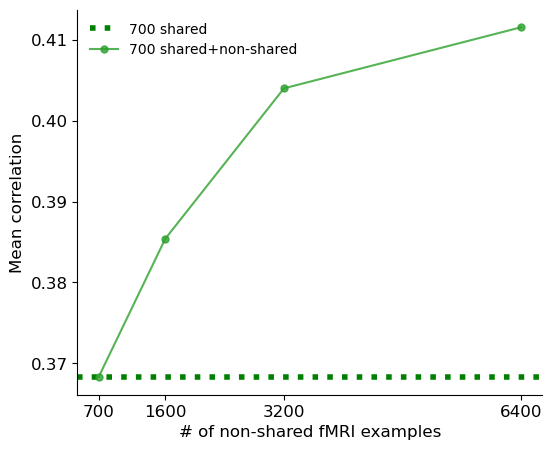

subject 1 to 8


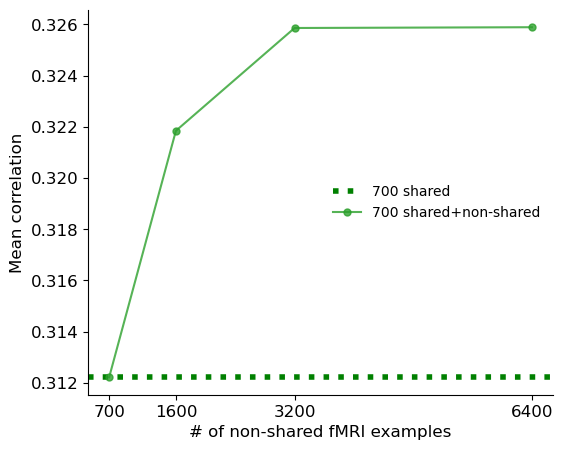

subject 2 to 1


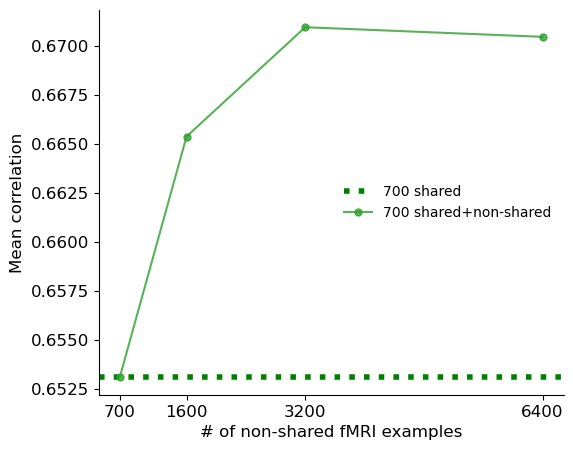

subject 2 to 3


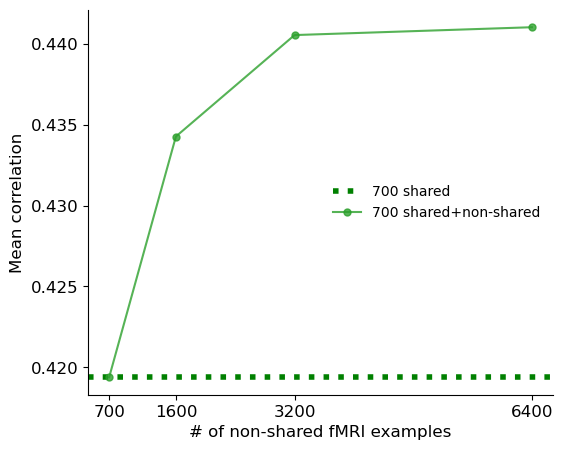

subject 2 to 4


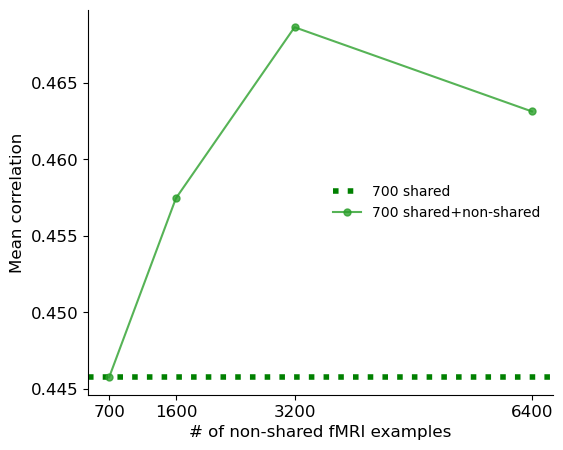

subject 2 to 5


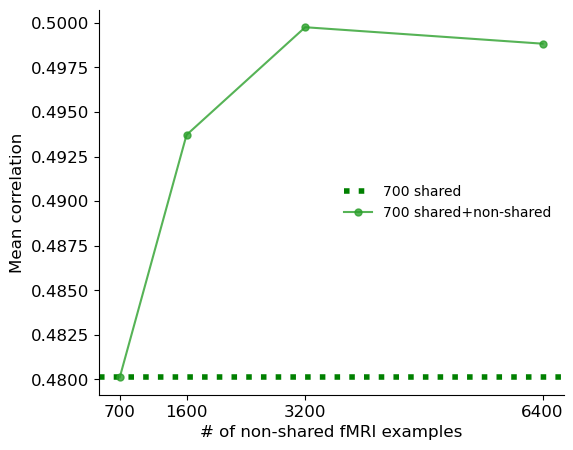

subject 2 to 6


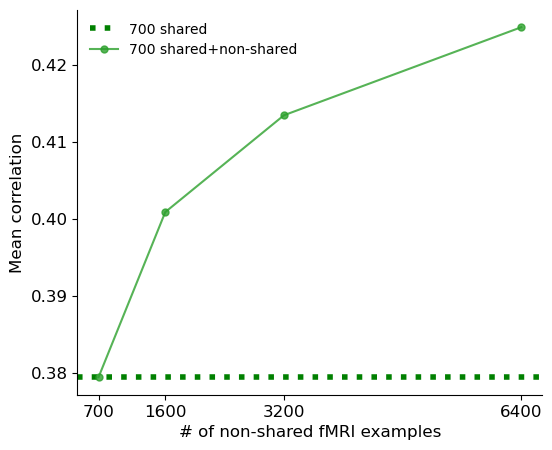

subject 2 to 7


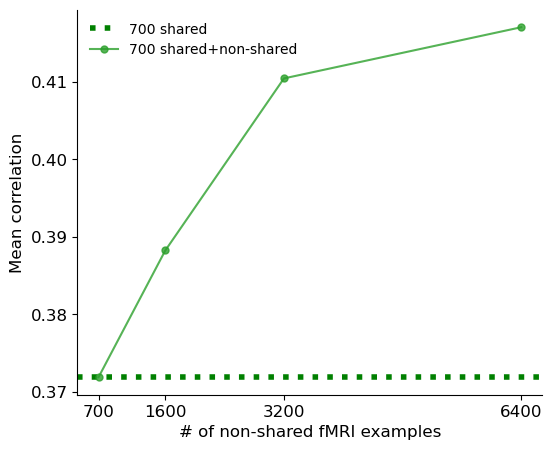

subject 2 to 8


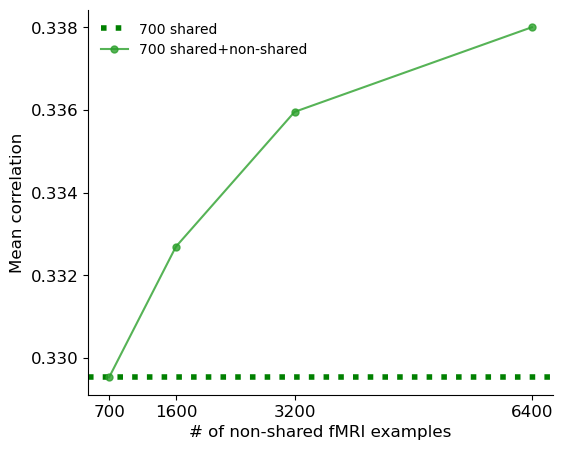

subject 3 to 1


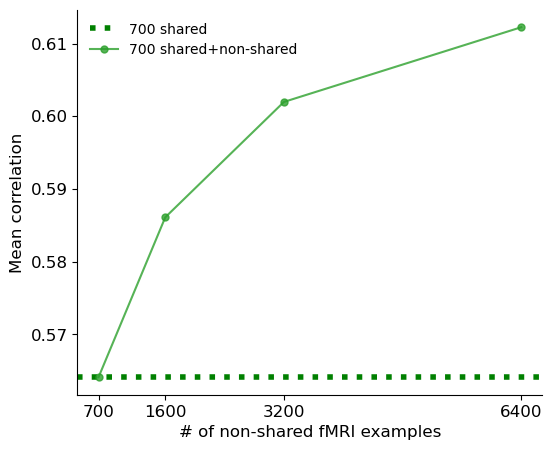

subject 3 to 2


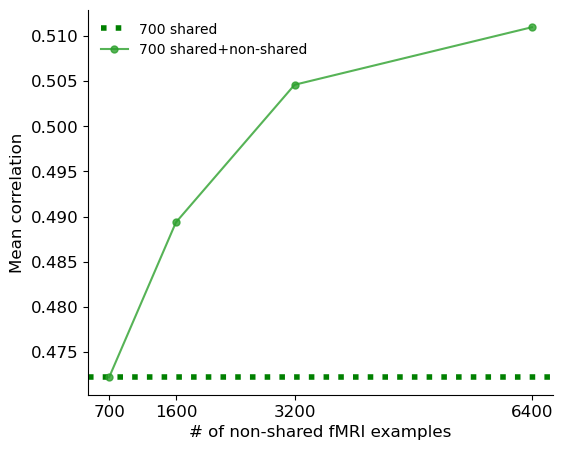

subject 3 to 4


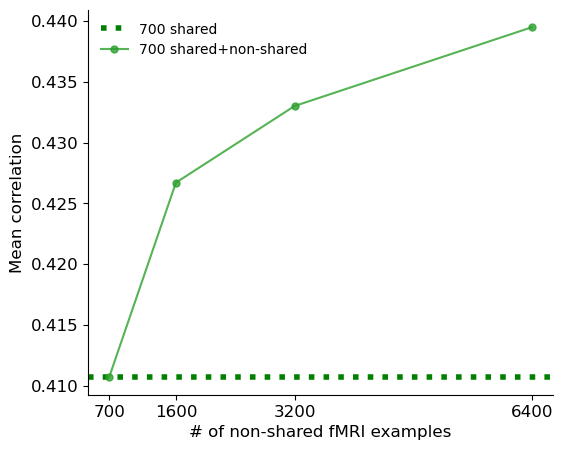

subject 3 to 5


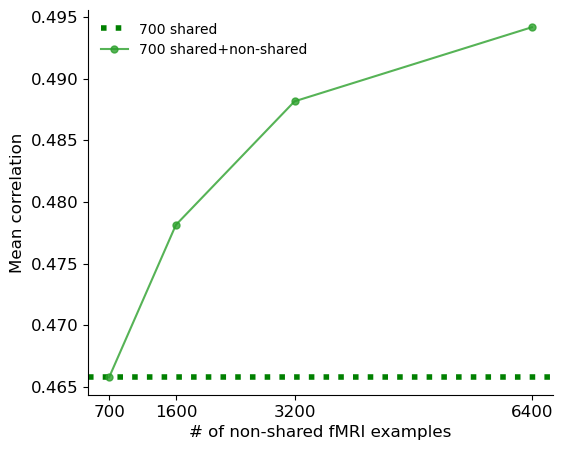

subject 3 to 6


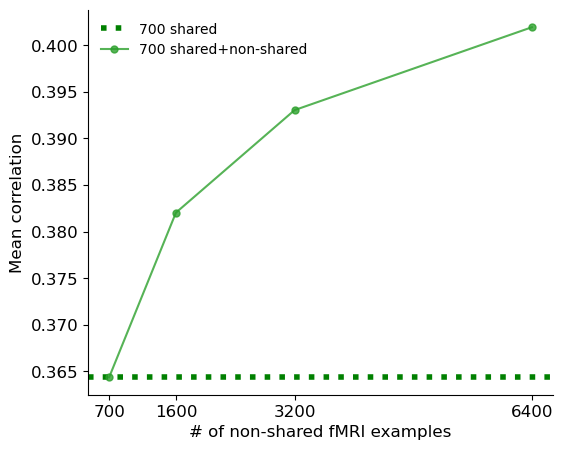

subject 3 to 7


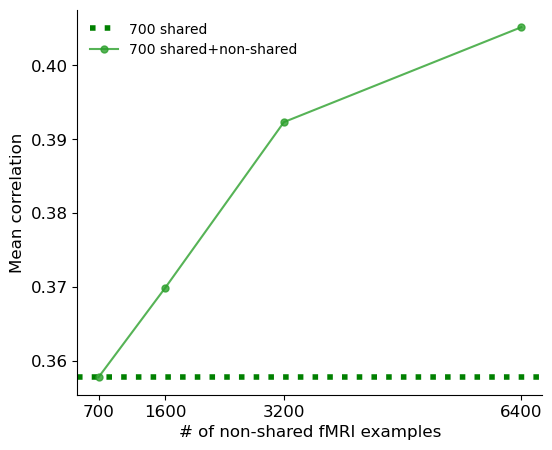

subject 3 to 8


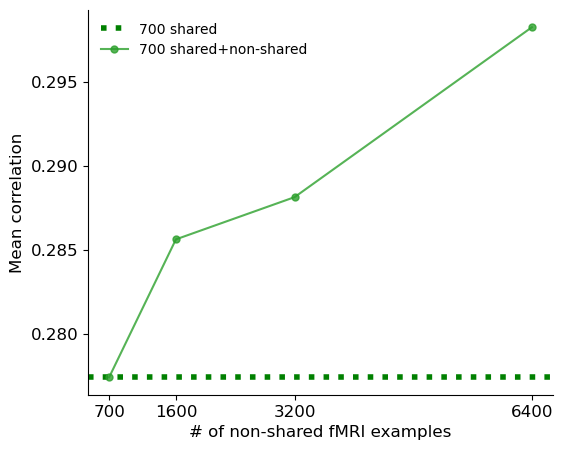

subject 4 to 1


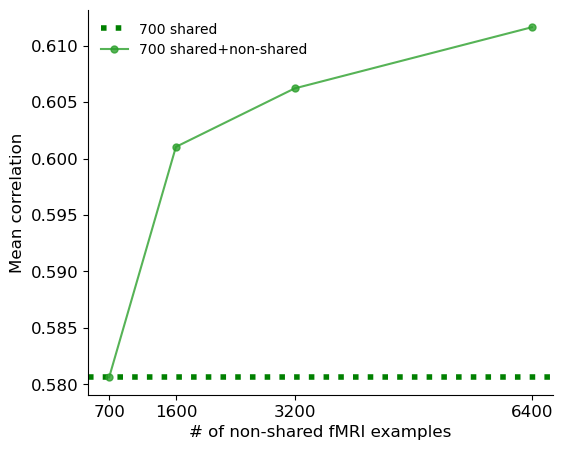

subject 4 to 2


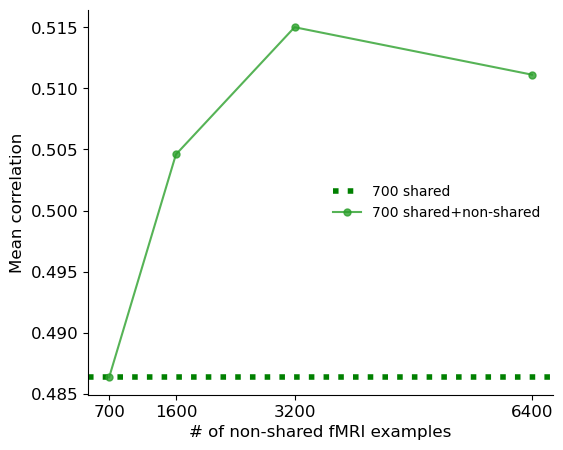

subject 4 to 3


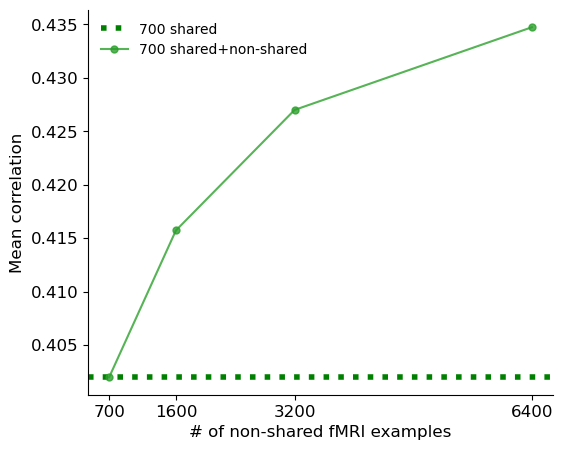

subject 4 to 5


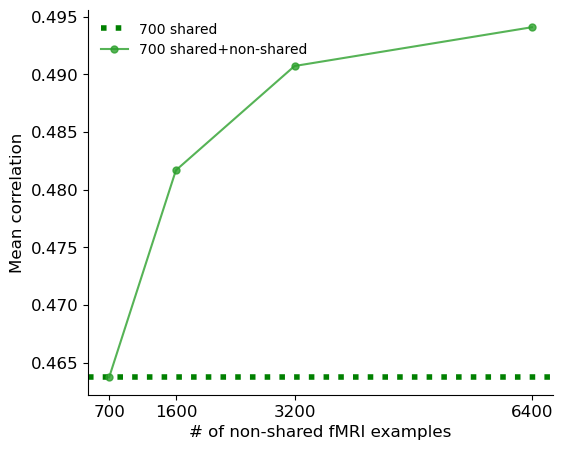

subject 4 to 6


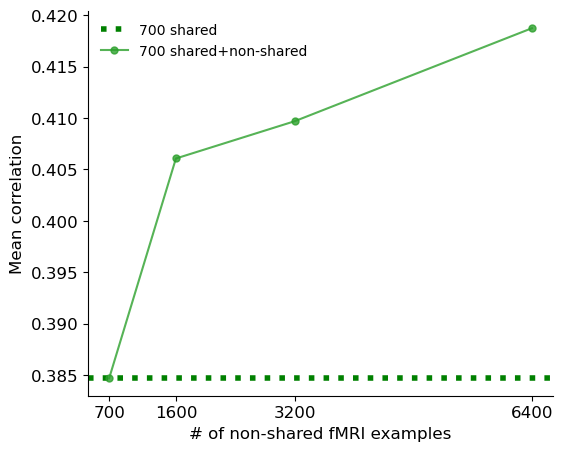

subject 4 to 7


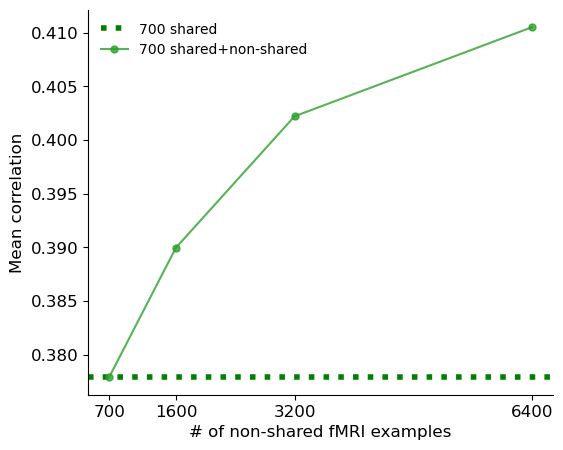

subject 4 to 8


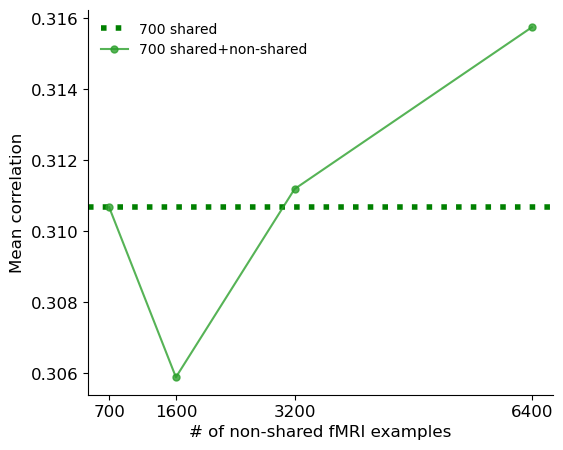

subject 5 to 1


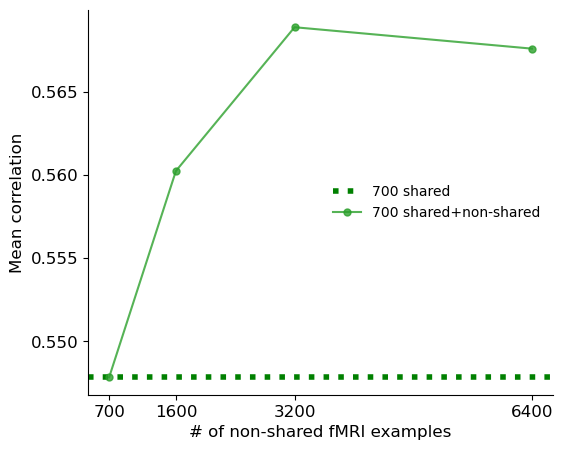

subject 5 to 2


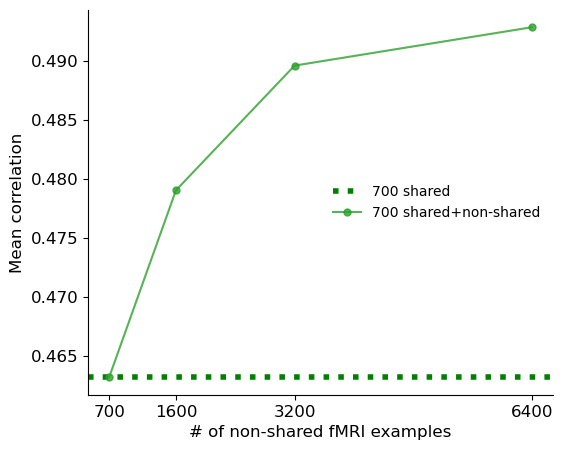

subject 5 to 3


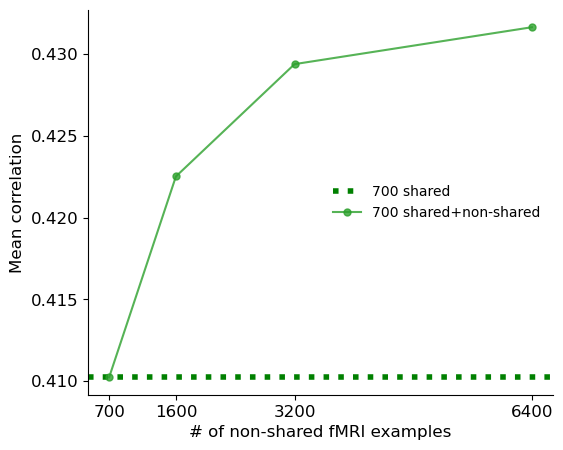

subject 5 to 4


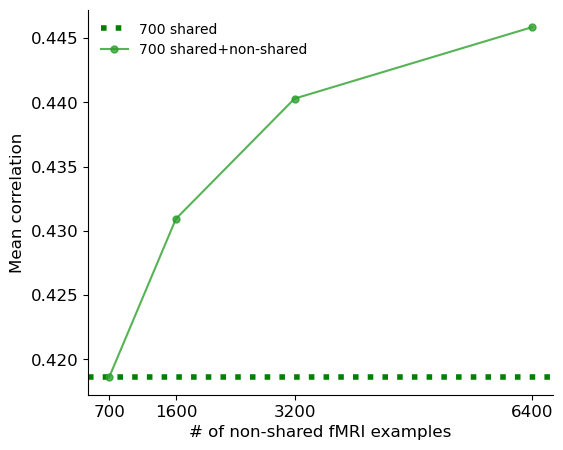

subject 5 to 6


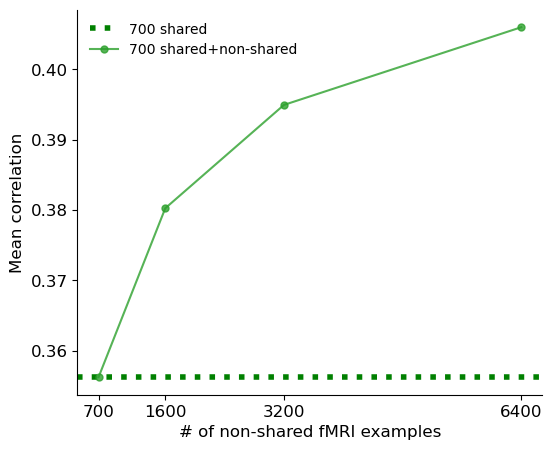

subject 5 to 7


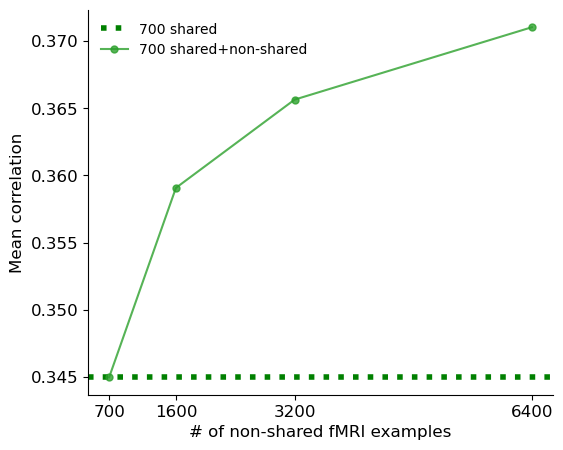

subject 5 to 8


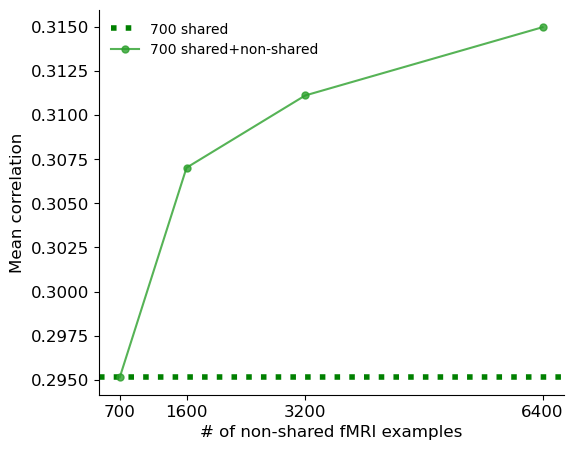

subject 6 to 1


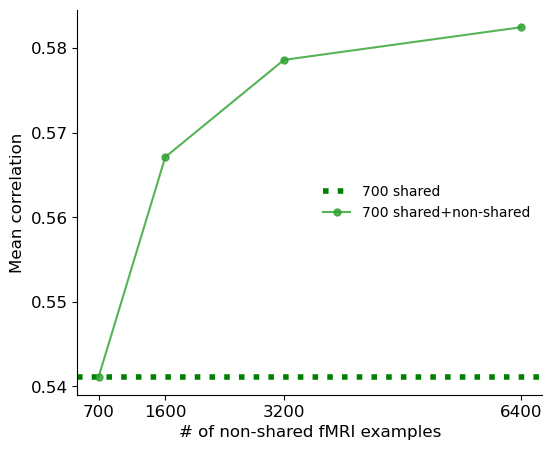

subject 6 to 2


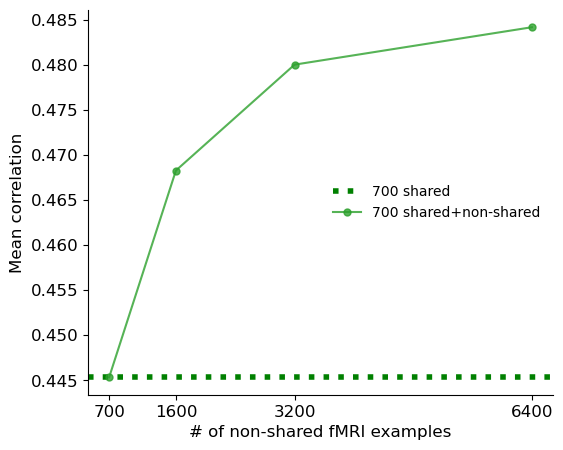

subject 6 to 3


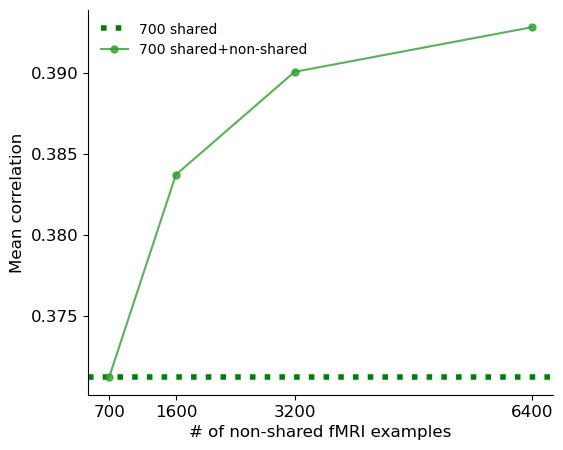

subject 6 to 4


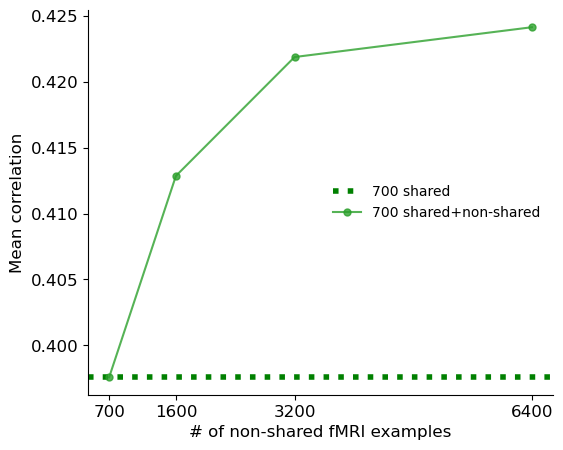

subject 6 to 5


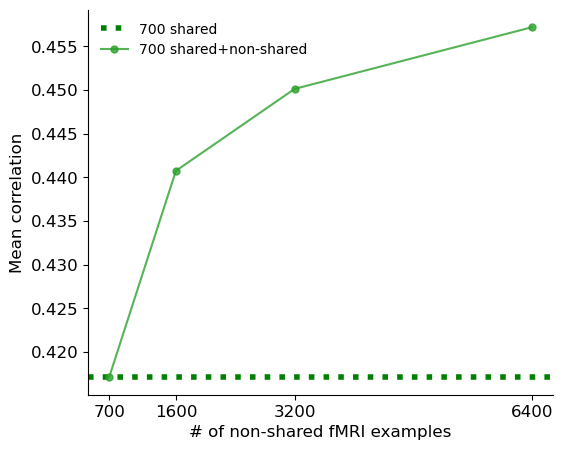

subject 6 to 7


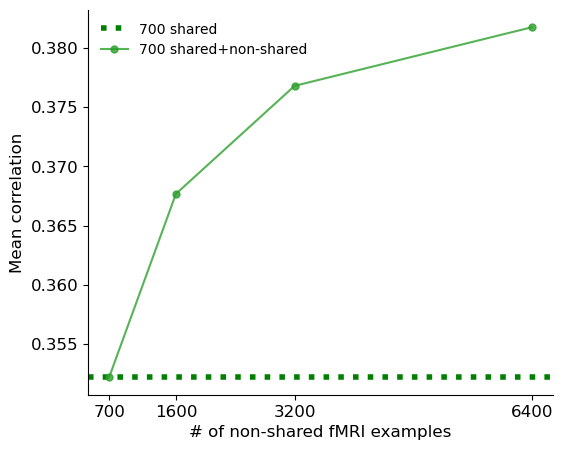

subject 6 to 8


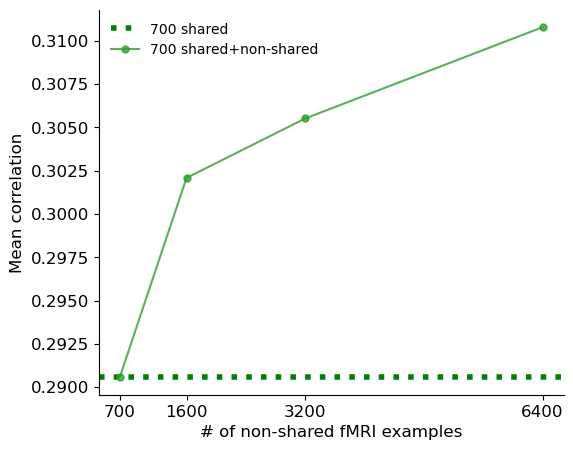

subject 7 to 1


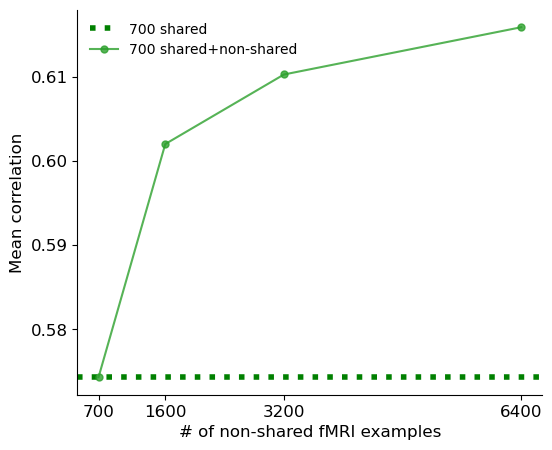

subject 7 to 2


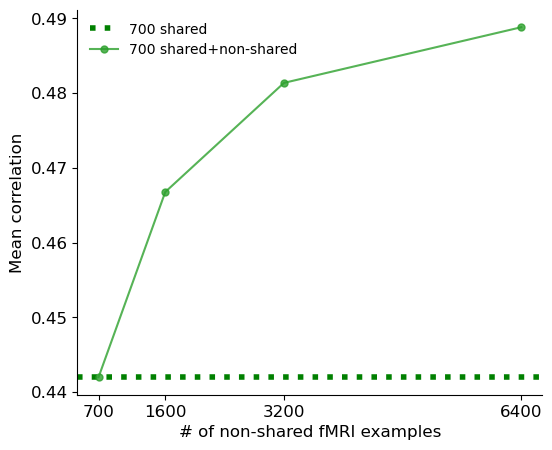

subject 7 to 3


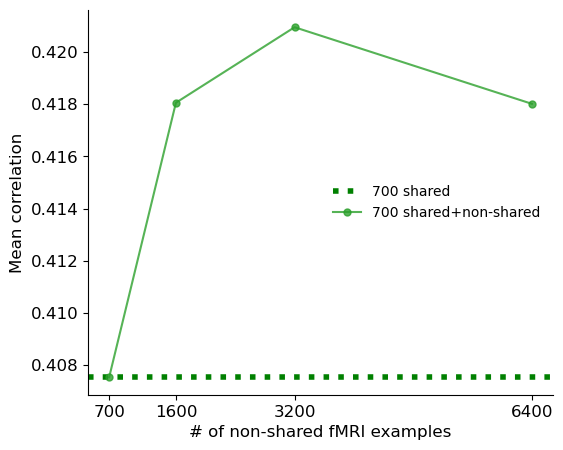

subject 7 to 4


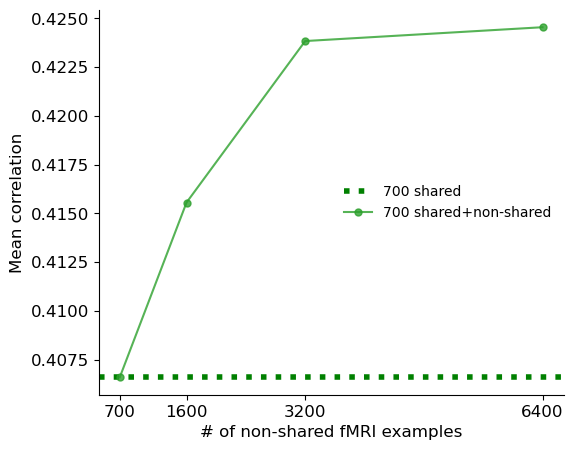

subject 7 to 5


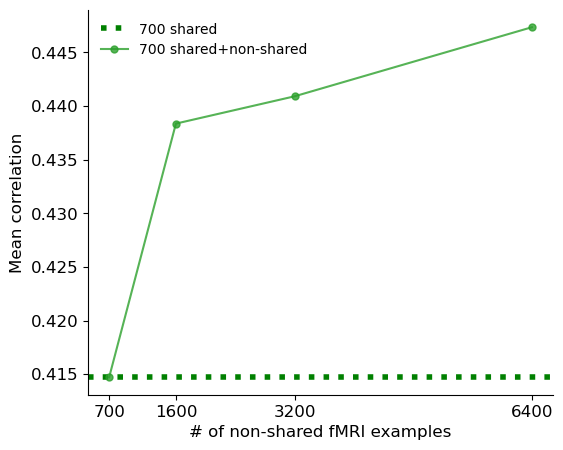

subject 7 to 6


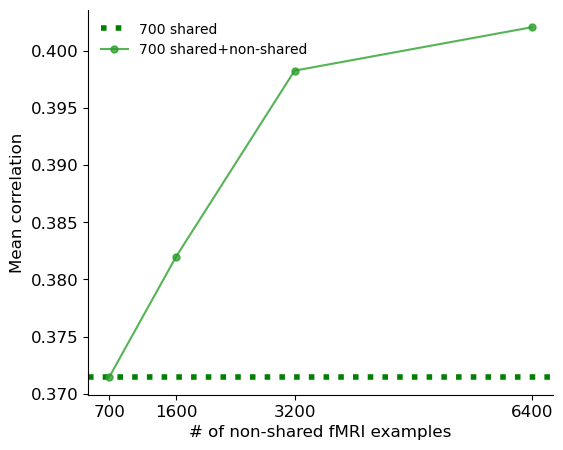

subject 7 to 8


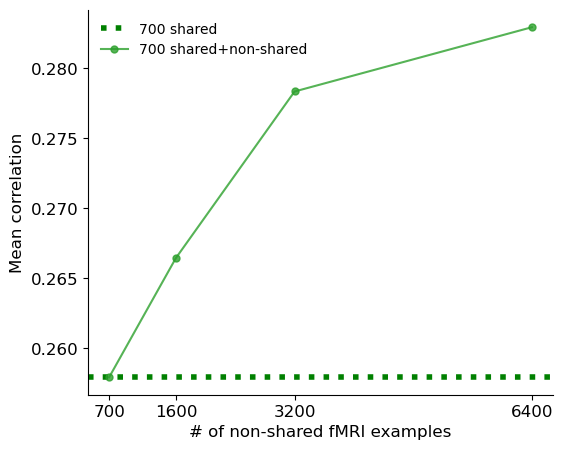

subject 8 to 1


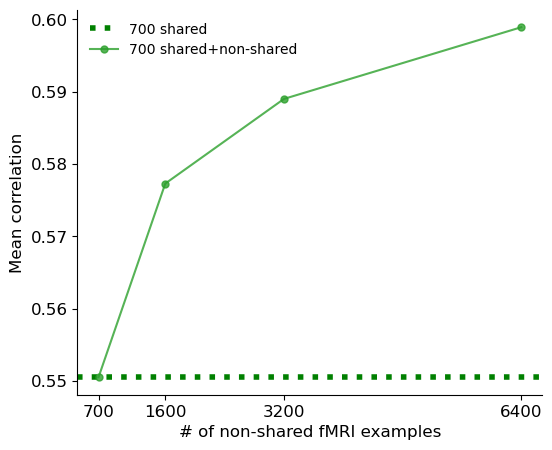

subject 8 to 2


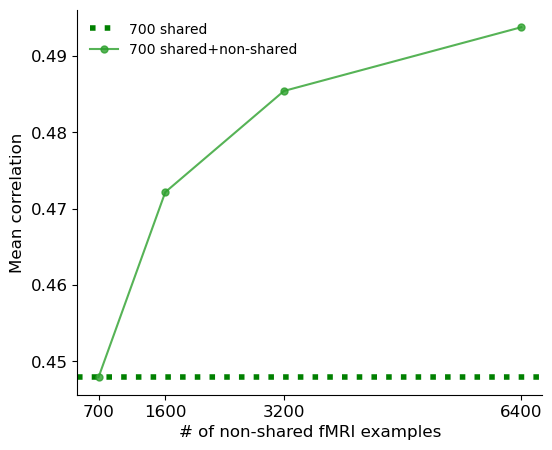

subject 8 to 3


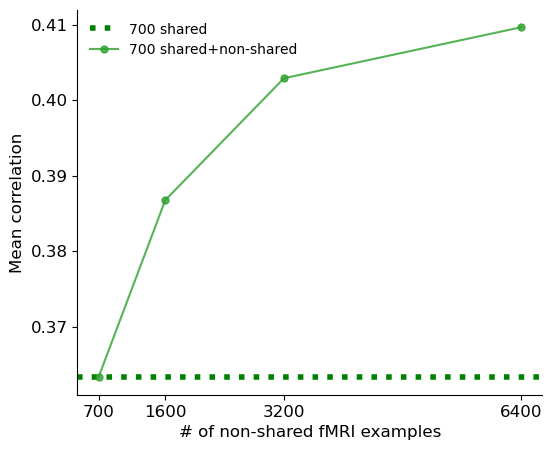

subject 8 to 4


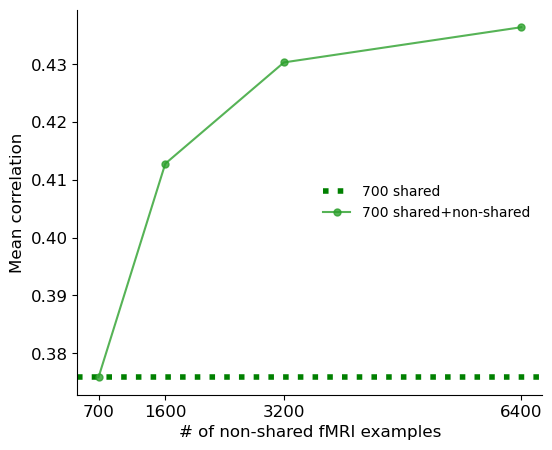

subject 8 to 5


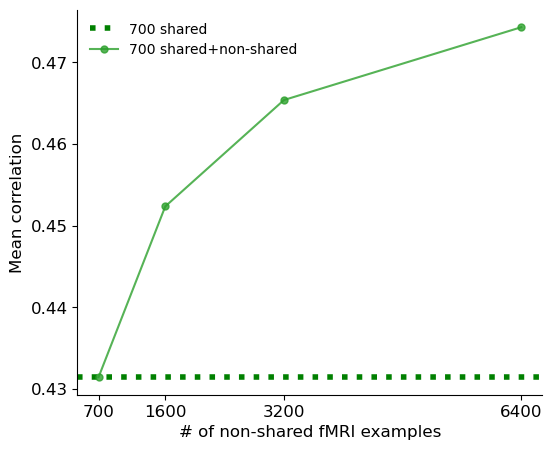

subject 8 to 6


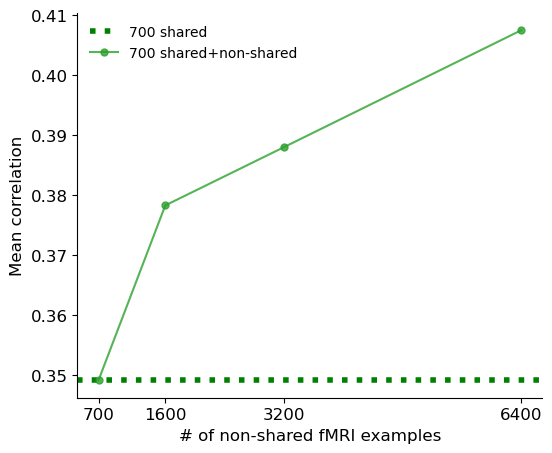

subject 8 to 7


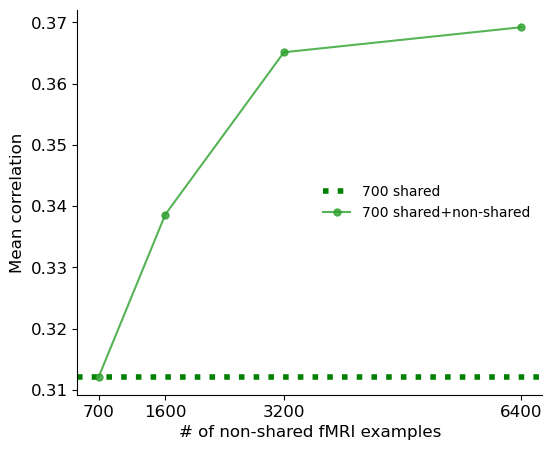

In [80]:
examples = 700
ylim = [f(df4_fsaverage[df4_fsaverage.shared == examples].test_corr.apply(lambda x: f(x))) for f in (np.nanmin, np.nanmax)]
for i in range(s1s4.size):
    print("subject", s1s4[i], "to", s2s4[i])
    plot_single_example_NSD_transformations_new(df4_fsaverage, example_num=i, save=True,
                                                s1s=s1s4_fsaverage, s2s=s2s4_fsaverage, examples=examples,
                                                fsaverage=True, with_only_ns=False, with_ns=True, ylim=ylim if SHAREY else None)
    plt.show()

# Figure S9

## Figure S9 left

See figure 6a

## Figure S9 left

See figure 7a

# Figure S11

See figure 8

# Figure S12

See figure S1b